In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import time
from modelutility_v2 import *


# define folder location
model_name = 'CNN_1.0_Log_Spaced'
dir_path = os.getcwd()
data_folder = os.path.join(dir_path, "data_pred_expanded","log_spaced")
output_folder = os.path.join('models',model_name)

#define file location
image_log_trainval_path = os.path.join(data_folder,'image_log_trainval.npy')
pv_log_trainval_path = os.path.join(data_folder,'pv_log_trainval.npy')
pv_pred_trainval_path = os.path.join(data_folder,'pv_pred_trainval.npy')
times_trainval_path = os.path.join(data_folder,'times_trainval.npy')

image_log_test_path = os.path.join(data_folder,'image_log_test.npy')
pv_log_test_path = os.path.join(data_folder,'pv_log_test.npy')
pv_pred_test_path = os.path.join(data_folder,'pv_pred_test.npy')
times_test_path = os.path.join(data_folder,'times_test.npy')

first_cloudy_test = datetime.datetime(2017,3,15)

# define model characteristics
width = 24
filter_size = [3,3]
dense_size = 1024
drop_rate = 0.4

# define training time parameters
num_epochs = 100
num_rep = 10
plotting = True
learning_rate = 3e-6
batch_size = 256

# Set random seed for repeatability
np.random.seed(1)

In [2]:
# The model
def cnn_33_model(X,X2, y, is_training):
    # CBP sandwich 1
    conv1 = tf.layers.conv2d(
        inputs=X,
        filters=width,
        kernel_size=filter_size,
        padding="same",
        activation=tf.nn.relu)
    bn1 = tf.layers.batch_normalization(inputs=conv1, axis= -1, training = is_training)
    pool1 = tf.layers.max_pooling2d(inputs=bn1, pool_size=[2, 2], strides=2)

    # CBP sandwich 2
    conv3 = tf.layers.conv2d(
        inputs=pool1,
        filters=width*2,
        kernel_size=filter_size,
        padding="same",
        activation=tf.nn.relu)
    bn3 = tf.layers.batch_normalization(inputs=conv3, axis= -1,training = is_training)
    pool2 = tf.layers.max_pooling2d(inputs=bn3, pool_size=[2, 2], strides=2)

    down_rate = 4
        
    # Two fully connected nets
    pool2_flat = tf.reshape(pool2, [-1, int(side_len/down_rate*side_len/down_rate*width*2)])
    pool2_flat_aug = tf.concat([pool2_flat,X2],axis=1)
    
    dense1 = tf.layers.dense(inputs=pool2_flat_aug, units=dense_size, activation=tf.nn.relu)
    dropout1 = tf.layers.dropout(inputs=dense1, rate=drop_rate, training = is_training)
    dense2 = tf.layers.dense(inputs=dropout1, units=dense_size, activation=tf.nn.relu)
    dropout2 = tf.layers.dropout(inputs=dense2, rate=drop_rate, training = is_training)
    
    regression = tf.layers.dense(inputs=dropout2, units=1)
    regression = tf.reshape(regression, [-1])
    return regression

In [3]:
# load PV output and images for the trainval set
pv_log_trainval = np.load(pv_log_trainval_path)
images_trainval = np.load(image_log_trainval_path)
pv_pred_trainval = np.load(pv_pred_trainval_path)
times_trainval = np.load(times_trainval_path)

#Side length is important for the model
side_len = images_trainval.shape[2]

# stack up the history and colors into a unified channel
images_trainval = images_trainval.transpose((0,2,3,4,1))
images_trainval = images_trainval.reshape((images_trainval.shape[0],
                                           images_trainval.shape[1],images_trainval.shape[2],-1))


# shuffling of the data by day
shuffled_indices = day_block_shuffle(times_trainval)
pv_log_trainval = pv_log_trainval[shuffled_indices]
pv_pred_trainval = pv_pred_trainval[shuffled_indices]
images_trainval = images_trainval[shuffled_indices]

# normalization of the pv data

In [4]:
# Build computational graph
tf.reset_default_graph()  # Reset computational graph

# x,y, pred_y 
x_var = tf.placeholder(tf.float32, [None, side_len, side_len, images_trainval.shape[3]])  # x variable
x2_var = tf.placeholder(tf.float32, [None, pv_log_trainval.shape[1]])
y_var = tf.placeholder(tf.float32, [None])  # y variable
is_training = tf.placeholder(tf.bool) # a flag

pred_y_var = cnn_33_model(x_var,x2_var, y_var, is_training)  # model in use

# loss and other accuracy indicator
loss_var = tf.losses.mean_squared_error(y_var, pred_y_var)  # loss in use
y_var_std = tf.reduce_mean(tf.square(y_var-tf.reduce_mean(y_var)))
rel_err_var = tf.sqrt(tf.divide(loss_var, y_var_std))

# Define optimizer and optimize session parameter
optimizer = tf.train.AdamOptimizer(learning_rate)

# batch normalization in tensorflow requires this extra dependency
# update_ops consist of calculating running average
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

# make sure every time during training the moving average is updated
with tf.control_dependencies(extra_update_ops):
    train_step = optimizer.minimize(loss_var)
pass

Training
Iteration 0: with minibatch training loss = 199 and relative error of 1.6
Iteration 20: with minibatch training loss = 113 and relative error of 1.2
Iteration 40: with minibatch training loss = 84.5 and relative error of 1
Iteration 60: with minibatch training loss = 61.4 and relative error of 0.89
Iteration 80: with minibatch training loss = 44.2 and relative error of 0.74
Iteration 100: with minibatch training loss = 34 and relative error of 0.65
Iteration 120: with minibatch training loss = 21.1 and relative error of 0.54
Iteration 140: with minibatch training loss = 20.9 and relative error of 0.52
Iteration 160: with minibatch training loss = 23 and relative error of 0.53
Iteration 180: with minibatch training loss = 16.5 and relative error of 0.46
Iteration 200: with minibatch training loss = 18.4 and relative error of 0.48
Iteration 220: with minibatch training loss = 14.8 and relative error of 0.44
Epoch 1, Overall loss = 44.9, relative error = 0.704, and process time o

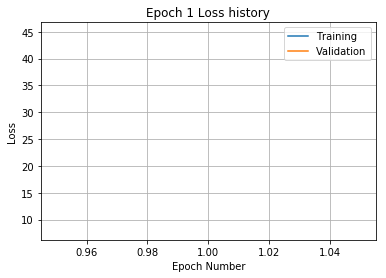

Training
Iteration 0: with minibatch training loss = 15.6 and relative error of 0.44
Iteration 20: with minibatch training loss = 12.1 and relative error of 0.4
Iteration 40: with minibatch training loss = 14.6 and relative error of 0.44
Iteration 60: with minibatch training loss = 12.2 and relative error of 0.4
Iteration 80: with minibatch training loss = 11 and relative error of 0.39
Iteration 100: with minibatch training loss = 12.5 and relative error of 0.39
Iteration 120: with minibatch training loss = 14.7 and relative error of 0.44
Iteration 140: with minibatch training loss = 13 and relative error of 0.41
Iteration 160: with minibatch training loss = 12.4 and relative error of 0.4
Iteration 180: with minibatch training loss = 9.58 and relative error of 0.35
Iteration 200: with minibatch training loss = 12 and relative error of 0.4
Iteration 220: with minibatch training loss = 11.2 and relative error of 0.37
Epoch 2, Overall loss = 12.7, relative error = 0.404, and process time 

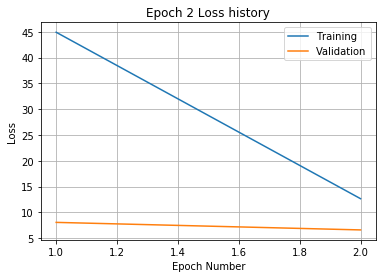

Training
Iteration 0: with minibatch training loss = 10.1 and relative error of 0.36
Iteration 20: with minibatch training loss = 10.8 and relative error of 0.37
Iteration 40: with minibatch training loss = 9.89 and relative error of 0.34
Iteration 60: with minibatch training loss = 11.3 and relative error of 0.39
Iteration 80: with minibatch training loss = 8.87 and relative error of 0.33
Iteration 100: with minibatch training loss = 13.1 and relative error of 0.41
Iteration 120: with minibatch training loss = 8.84 and relative error of 0.35
Iteration 140: with minibatch training loss = 8.81 and relative error of 0.34
Iteration 160: with minibatch training loss = 8.81 and relative error of 0.34
Iteration 180: with minibatch training loss = 11.5 and relative error of 0.4
Iteration 200: with minibatch training loss = 11.9 and relative error of 0.39
Iteration 220: with minibatch training loss = 9.64 and relative error of 0.35
Epoch 3, Overall loss = 10.3, relative error = 0.365, and proc

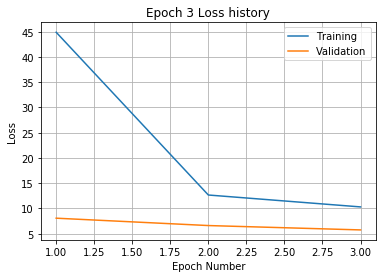

Training
Iteration 0: with minibatch training loss = 9.64 and relative error of 0.35
Iteration 20: with minibatch training loss = 10.3 and relative error of 0.38
Iteration 40: with minibatch training loss = 9.39 and relative error of 0.34
Iteration 60: with minibatch training loss = 7.67 and relative error of 0.31
Iteration 80: with minibatch training loss = 10.8 and relative error of 0.38
Iteration 100: with minibatch training loss = 12.5 and relative error of 0.4
Iteration 120: with minibatch training loss = 7.74 and relative error of 0.31
Iteration 140: with minibatch training loss = 5.87 and relative error of 0.27
Iteration 160: with minibatch training loss = 12.2 and relative error of 0.38
Iteration 180: with minibatch training loss = 9.98 and relative error of 0.37
Iteration 200: with minibatch training loss = 8.06 and relative error of 0.33
Iteration 220: with minibatch training loss = 8.8 and relative error of 0.34
Epoch 4, Overall loss = 9.02, relative error = 0.341, and proce

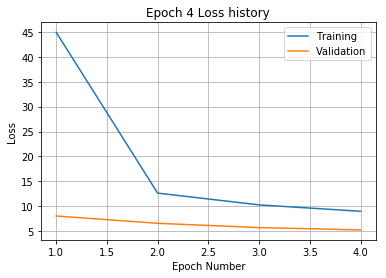

Training
Iteration 0: with minibatch training loss = 9.4 and relative error of 0.35
Iteration 20: with minibatch training loss = 6.14 and relative error of 0.29
Iteration 40: with minibatch training loss = 6.24 and relative error of 0.28
Iteration 60: with minibatch training loss = 8.75 and relative error of 0.33
Iteration 80: with minibatch training loss = 8.9 and relative error of 0.35
Iteration 100: with minibatch training loss = 8.18 and relative error of 0.32
Iteration 120: with minibatch training loss = 7.84 and relative error of 0.32
Iteration 140: with minibatch training loss = 9.29 and relative error of 0.35
Iteration 160: with minibatch training loss = 8.17 and relative error of 0.33
Iteration 180: with minibatch training loss = 8.46 and relative error of 0.33
Iteration 200: with minibatch training loss = 7.25 and relative error of 0.3
Iteration 220: with minibatch training loss = 6.42 and relative error of 0.29
Epoch 5, Overall loss = 8.23, relative error = 0.326, and proces

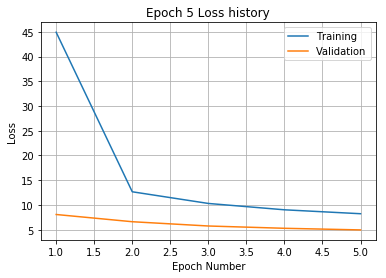

Training
Iteration 0: with minibatch training loss = 8.7 and relative error of 0.33
Iteration 20: with minibatch training loss = 5.71 and relative error of 0.28
Iteration 40: with minibatch training loss = 8.05 and relative error of 0.33
Iteration 60: with minibatch training loss = 7.7 and relative error of 0.32
Iteration 80: with minibatch training loss = 7.26 and relative error of 0.29
Iteration 100: with minibatch training loss = 9.15 and relative error of 0.35
Iteration 120: with minibatch training loss = 7.67 and relative error of 0.31
Iteration 140: with minibatch training loss = 7.2 and relative error of 0.3
Iteration 160: with minibatch training loss = 8.67 and relative error of 0.34
Iteration 180: with minibatch training loss = 9.64 and relative error of 0.35
Iteration 200: with minibatch training loss = 8.14 and relative error of 0.33
Iteration 220: with minibatch training loss = 7.96 and relative error of 0.33
Epoch 6, Overall loss = 7.61, relative error = 0.313, and process

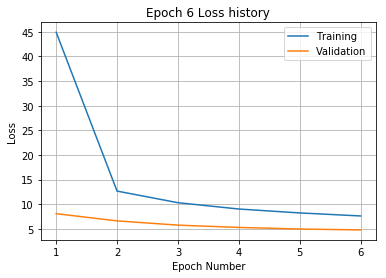

Training
Iteration 0: with minibatch training loss = 7.52 and relative error of 0.32
Iteration 20: with minibatch training loss = 9.31 and relative error of 0.34
Iteration 40: with minibatch training loss = 7.08 and relative error of 0.29
Iteration 60: with minibatch training loss = 5.87 and relative error of 0.28
Iteration 80: with minibatch training loss = 7.48 and relative error of 0.31
Iteration 100: with minibatch training loss = 7.63 and relative error of 0.31
Iteration 120: with minibatch training loss = 6.34 and relative error of 0.28
Iteration 140: with minibatch training loss = 9.4 and relative error of 0.36
Iteration 160: with minibatch training loss = 8.46 and relative error of 0.32
Iteration 180: with minibatch training loss = 7.46 and relative error of 0.31
Iteration 200: with minibatch training loss = 6.81 and relative error of 0.29
Iteration 220: with minibatch training loss = 7.63 and relative error of 0.31
Epoch 7, Overall loss = 7.21, relative error = 0.305, and proc

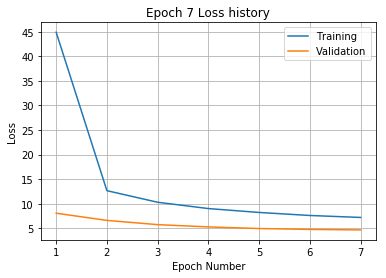

Training
Iteration 0: with minibatch training loss = 6.15 and relative error of 0.29
Iteration 20: with minibatch training loss = 6.68 and relative error of 0.29
Iteration 40: with minibatch training loss = 8.36 and relative error of 0.33
Iteration 60: with minibatch training loss = 5.33 and relative error of 0.26
Iteration 80: with minibatch training loss = 5.51 and relative error of 0.27
Iteration 100: with minibatch training loss = 7.01 and relative error of 0.3
Iteration 120: with minibatch training loss = 6.13 and relative error of 0.27
Iteration 140: with minibatch training loss = 7.13 and relative error of 0.3
Iteration 160: with minibatch training loss = 7.87 and relative error of 0.32
Iteration 180: with minibatch training loss = 7.45 and relative error of 0.31
Iteration 200: with minibatch training loss = 6.55 and relative error of 0.29
Iteration 220: with minibatch training loss = 6.04 and relative error of 0.28
Epoch 8, Overall loss = 6.86, relative error = 0.297, and proce

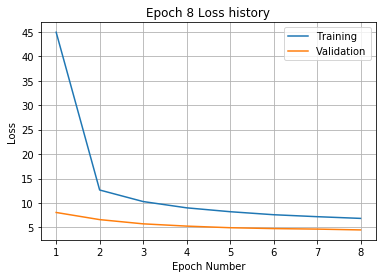

Training
Iteration 0: with minibatch training loss = 6.9 and relative error of 0.29
Iteration 20: with minibatch training loss = 9.32 and relative error of 0.36
Iteration 40: with minibatch training loss = 5.68 and relative error of 0.27
Iteration 60: with minibatch training loss = 4.85 and relative error of 0.25
Iteration 80: with minibatch training loss = 6.51 and relative error of 0.29
Iteration 100: with minibatch training loss = 5.8 and relative error of 0.27
Iteration 120: with minibatch training loss = 4.8 and relative error of 0.25
Iteration 140: with minibatch training loss = 6.51 and relative error of 0.28
Iteration 160: with minibatch training loss = 8.54 and relative error of 0.32
Iteration 180: with minibatch training loss = 5.5 and relative error of 0.26
Iteration 200: with minibatch training loss = 6.74 and relative error of 0.3
Iteration 220: with minibatch training loss = 7.48 and relative error of 0.3
Epoch 9, Overall loss = 6.64, relative error = 0.292, and process t

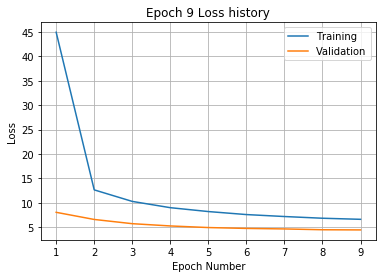

Training
Iteration 0: with minibatch training loss = 5.53 and relative error of 0.27
Iteration 20: with minibatch training loss = 4.84 and relative error of 0.25
Iteration 40: with minibatch training loss = 7.13 and relative error of 0.3
Iteration 60: with minibatch training loss = 7.22 and relative error of 0.31
Iteration 80: with minibatch training loss = 5.71 and relative error of 0.28
Iteration 100: with minibatch training loss = 5.55 and relative error of 0.27
Iteration 120: with minibatch training loss = 8.71 and relative error of 0.34
Iteration 140: with minibatch training loss = 5.69 and relative error of 0.28
Iteration 160: with minibatch training loss = 4.91 and relative error of 0.26
Iteration 180: with minibatch training loss = 5.59 and relative error of 0.27
Iteration 200: with minibatch training loss = 5.51 and relative error of 0.27
Iteration 220: with minibatch training loss = 5.33 and relative error of 0.26
Epoch 10, Overall loss = 6.35, relative error = 0.286, and pro

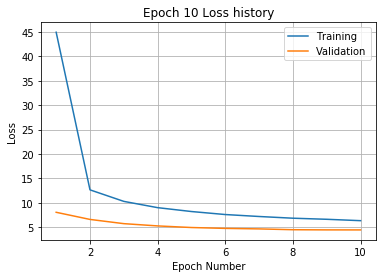

Training
Iteration 0: with minibatch training loss = 7.79 and relative error of 0.31
Iteration 20: with minibatch training loss = 3.77 and relative error of 0.22
Iteration 40: with minibatch training loss = 5.04 and relative error of 0.27
Iteration 60: with minibatch training loss = 4.78 and relative error of 0.24
Iteration 80: with minibatch training loss = 5.85 and relative error of 0.28
Iteration 100: with minibatch training loss = 5.57 and relative error of 0.27
Iteration 120: with minibatch training loss = 5.57 and relative error of 0.25
Iteration 140: with minibatch training loss = 5.49 and relative error of 0.27
Iteration 160: with minibatch training loss = 7.21 and relative error of 0.31
Iteration 180: with minibatch training loss = 8.58 and relative error of 0.33
Iteration 200: with minibatch training loss = 5.51 and relative error of 0.27
Iteration 220: with minibatch training loss = 5.51 and relative error of 0.27
Epoch 11, Overall loss = 6.19, relative error = 0.282, and pr

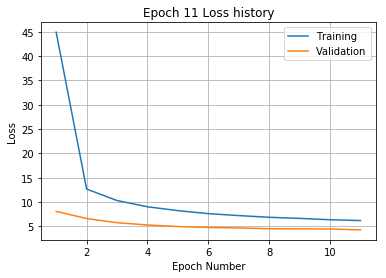

Training
Iteration 0: with minibatch training loss = 8.03 and relative error of 0.34
Iteration 20: with minibatch training loss = 6.64 and relative error of 0.29
Iteration 40: with minibatch training loss = 5.25 and relative error of 0.26
Iteration 60: with minibatch training loss = 6.29 and relative error of 0.28
Iteration 80: with minibatch training loss = 5.54 and relative error of 0.26
Iteration 100: with minibatch training loss = 6.73 and relative error of 0.3
Iteration 120: with minibatch training loss = 5.23 and relative error of 0.26
Iteration 140: with minibatch training loss = 4.32 and relative error of 0.23
Iteration 160: with minibatch training loss = 4.83 and relative error of 0.24
Iteration 180: with minibatch training loss = 5.92 and relative error of 0.28
Iteration 200: with minibatch training loss = 7.07 and relative error of 0.31
Iteration 220: with minibatch training loss = 6.54 and relative error of 0.29
Epoch 12, Overall loss = 5.99, relative error = 0.277, and pro

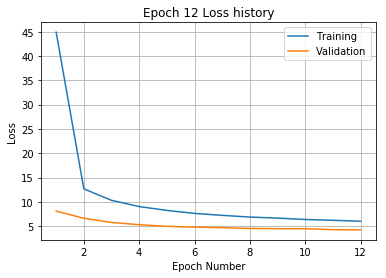

Training
Iteration 0: with minibatch training loss = 8.65 and relative error of 0.33
Iteration 20: with minibatch training loss = 5.24 and relative error of 0.27
Iteration 40: with minibatch training loss = 6.18 and relative error of 0.28
Iteration 60: with minibatch training loss = 4.53 and relative error of 0.24
Iteration 80: with minibatch training loss = 6.27 and relative error of 0.28
Iteration 100: with minibatch training loss = 4.92 and relative error of 0.26
Iteration 120: with minibatch training loss = 5.34 and relative error of 0.27
Iteration 140: with minibatch training loss = 4.28 and relative error of 0.23
Iteration 160: with minibatch training loss = 5.58 and relative error of 0.27
Iteration 180: with minibatch training loss = 6.53 and relative error of 0.29
Iteration 200: with minibatch training loss = 6.13 and relative error of 0.28
Iteration 220: with minibatch training loss = 5.63 and relative error of 0.27
Epoch 13, Overall loss = 5.78, relative error = 0.273, and pr

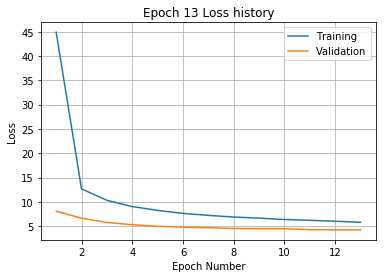

Training
Iteration 0: with minibatch training loss = 5.99 and relative error of 0.28
Iteration 20: with minibatch training loss = 5.16 and relative error of 0.25
Iteration 40: with minibatch training loss = 6.27 and relative error of 0.28
Iteration 60: with minibatch training loss = 5.15 and relative error of 0.26
Iteration 80: with minibatch training loss = 6.03 and relative error of 0.28
Iteration 100: with minibatch training loss = 6.92 and relative error of 0.3
Iteration 120: with minibatch training loss = 4.96 and relative error of 0.25
Iteration 140: with minibatch training loss = 4.91 and relative error of 0.26
Iteration 160: with minibatch training loss = 5.64 and relative error of 0.27
Iteration 180: with minibatch training loss = 7.82 and relative error of 0.31
Iteration 200: with minibatch training loss = 4.34 and relative error of 0.24
Iteration 220: with minibatch training loss = 6.15 and relative error of 0.29
Epoch 14, Overall loss = 5.68, relative error = 0.27, and proc

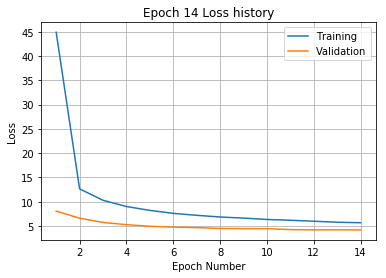

Training
Iteration 0: with minibatch training loss = 5.36 and relative error of 0.26
Iteration 20: with minibatch training loss = 5.38 and relative error of 0.26
Iteration 40: with minibatch training loss = 6.62 and relative error of 0.29
Iteration 60: with minibatch training loss = 5.6 and relative error of 0.27
Iteration 80: with minibatch training loss = 5.55 and relative error of 0.26
Iteration 100: with minibatch training loss = 5.67 and relative error of 0.28
Iteration 120: with minibatch training loss = 5.35 and relative error of 0.26
Iteration 140: with minibatch training loss = 7.8 and relative error of 0.32
Iteration 160: with minibatch training loss = 5.82 and relative error of 0.27
Iteration 180: with minibatch training loss = 7.48 and relative error of 0.32
Iteration 200: with minibatch training loss = 5.73 and relative error of 0.26
Iteration 220: with minibatch training loss = 5.94 and relative error of 0.28
Epoch 15, Overall loss = 5.51, relative error = 0.266, and proc

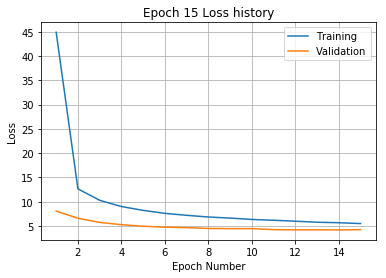

Training
Iteration 0: with minibatch training loss = 6.83 and relative error of 0.3
Iteration 20: with minibatch training loss = 5.41 and relative error of 0.26
Iteration 40: with minibatch training loss = 4.02 and relative error of 0.23
Iteration 60: with minibatch training loss = 4.31 and relative error of 0.24
Iteration 80: with minibatch training loss = 3.36 and relative error of 0.21
Iteration 100: with minibatch training loss = 5.65 and relative error of 0.27
Iteration 120: with minibatch training loss = 6.2 and relative error of 0.29
Iteration 140: with minibatch training loss = 5.19 and relative error of 0.26
Iteration 160: with minibatch training loss = 5 and relative error of 0.26
Iteration 180: with minibatch training loss = 4.62 and relative error of 0.25
Iteration 200: with minibatch training loss = 8.11 and relative error of 0.33
Iteration 220: with minibatch training loss = 4.09 and relative error of 0.23
Epoch 16, Overall loss = 5.38, relative error = 0.263, and process

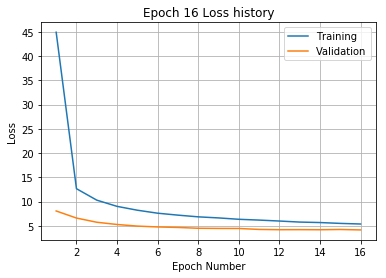

Training
Iteration 0: with minibatch training loss = 7.96 and relative error of 0.31
Iteration 20: with minibatch training loss = 5.26 and relative error of 0.25
Iteration 40: with minibatch training loss = 5.65 and relative error of 0.27
Iteration 60: with minibatch training loss = 6.35 and relative error of 0.28
Iteration 80: with minibatch training loss = 3.59 and relative error of 0.21
Iteration 100: with minibatch training loss = 6.07 and relative error of 0.28
Iteration 120: with minibatch training loss = 3.44 and relative error of 0.21
Iteration 140: with minibatch training loss = 6.16 and relative error of 0.29
Iteration 160: with minibatch training loss = 3.53 and relative error of 0.21
Iteration 180: with minibatch training loss = 5.88 and relative error of 0.27
Iteration 200: with minibatch training loss = 6.3 and relative error of 0.29
Iteration 220: with minibatch training loss = 4.39 and relative error of 0.24
Epoch 17, Overall loss = 5.33, relative error = 0.262, and pro

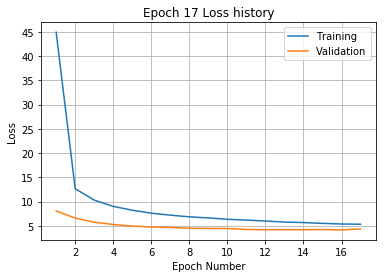

Training
Iteration 0: with minibatch training loss = 4.01 and relative error of 0.22
Iteration 20: with minibatch training loss = 5.8 and relative error of 0.28
Iteration 40: with minibatch training loss = 6.92 and relative error of 0.32
Iteration 60: with minibatch training loss = 5.9 and relative error of 0.27
Iteration 80: with minibatch training loss = 3.51 and relative error of 0.21
Iteration 100: with minibatch training loss = 4.01 and relative error of 0.23
Iteration 120: with minibatch training loss = 6.98 and relative error of 0.3
Iteration 140: with minibatch training loss = 5.06 and relative error of 0.26
Iteration 160: with minibatch training loss = 5.32 and relative error of 0.27
Iteration 180: with minibatch training loss = 7.27 and relative error of 0.3
Iteration 200: with minibatch training loss = 6.01 and relative error of 0.28
Iteration 220: with minibatch training loss = 5.51 and relative error of 0.26
Epoch 18, Overall loss = 5.18, relative error = 0.258, and proces

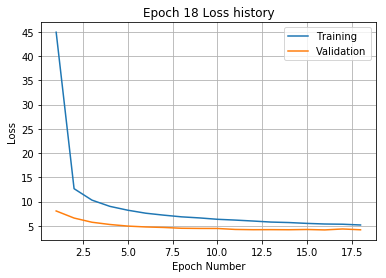

Training
Iteration 0: with minibatch training loss = 5.86 and relative error of 0.27
Iteration 20: with minibatch training loss = 5.82 and relative error of 0.28
Iteration 40: with minibatch training loss = 4.88 and relative error of 0.26
Iteration 60: with minibatch training loss = 4.61 and relative error of 0.25
Iteration 80: with minibatch training loss = 5.81 and relative error of 0.27
Iteration 100: with minibatch training loss = 5.84 and relative error of 0.28
Iteration 120: with minibatch training loss = 3.03 and relative error of 0.2
Iteration 140: with minibatch training loss = 3.76 and relative error of 0.22
Iteration 160: with minibatch training loss = 6.87 and relative error of 0.3
Iteration 180: with minibatch training loss = 6.46 and relative error of 0.29
Iteration 200: with minibatch training loss = 4.2 and relative error of 0.24
Iteration 220: with minibatch training loss = 4.21 and relative error of 0.23
Epoch 19, Overall loss = 5.1, relative error = 0.256, and proces

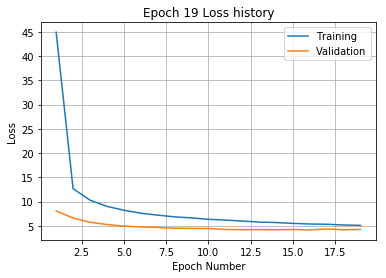

Training
Iteration 0: with minibatch training loss = 5.13 and relative error of 0.25
Iteration 20: with minibatch training loss = 3.72 and relative error of 0.21
Iteration 40: with minibatch training loss = 4.7 and relative error of 0.26
Iteration 60: with minibatch training loss = 5.31 and relative error of 0.27
Iteration 80: with minibatch training loss = 4.63 and relative error of 0.24
Iteration 100: with minibatch training loss = 5.96 and relative error of 0.27
Iteration 120: with minibatch training loss = 4.25 and relative error of 0.24
Iteration 140: with minibatch training loss = 4.79 and relative error of 0.25
Iteration 160: with minibatch training loss = 6.51 and relative error of 0.29
Iteration 180: with minibatch training loss = 5.6 and relative error of 0.26
Iteration 200: with minibatch training loss = 4.6 and relative error of 0.24
Iteration 220: with minibatch training loss = 3.54 and relative error of 0.21
Epoch 20, Overall loss = 4.98, relative error = 0.253, and proce

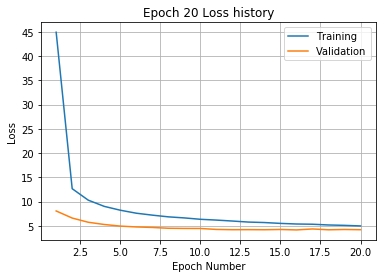

Training
Iteration 0: with minibatch training loss = 4.17 and relative error of 0.23
Iteration 20: with minibatch training loss = 4.27 and relative error of 0.23
Iteration 40: with minibatch training loss = 5.24 and relative error of 0.26
Iteration 60: with minibatch training loss = 4.63 and relative error of 0.24
Iteration 80: with minibatch training loss = 5.55 and relative error of 0.26
Iteration 100: with minibatch training loss = 4.69 and relative error of 0.24
Iteration 120: with minibatch training loss = 3.69 and relative error of 0.22
Iteration 140: with minibatch training loss = 4.55 and relative error of 0.24
Iteration 160: with minibatch training loss = 3.6 and relative error of 0.21
Iteration 180: with minibatch training loss = 4.47 and relative error of 0.24
Iteration 200: with minibatch training loss = 3.43 and relative error of 0.22
Iteration 220: with minibatch training loss = 3.58 and relative error of 0.22
Epoch 21, Overall loss = 4.88, relative error = 0.251, and pro

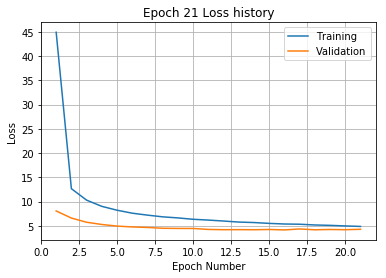

Validation error has stopped improving! Training on repetition 1 stopped!
Training
Iteration 0: with minibatch training loss = 266 and relative error of 1.8
Iteration 20: with minibatch training loss = 140 and relative error of 1.4
Iteration 40: with minibatch training loss = 79 and relative error of 1
Iteration 60: with minibatch training loss = 60.7 and relative error of 0.87
Iteration 80: with minibatch training loss = 44 and relative error of 0.77
Iteration 100: with minibatch training loss = 27.9 and relative error of 0.62
Iteration 120: with minibatch training loss = 25.6 and relative error of 0.57
Iteration 140: with minibatch training loss = 21.9 and relative error of 0.52
Iteration 160: with minibatch training loss = 16.2 and relative error of 0.47
Iteration 180: with minibatch training loss = 16.1 and relative error of 0.45
Iteration 200: with minibatch training loss = 16.5 and relative error of 0.47
Iteration 220: with minibatch training loss = 16.2 and relative error of 0.4

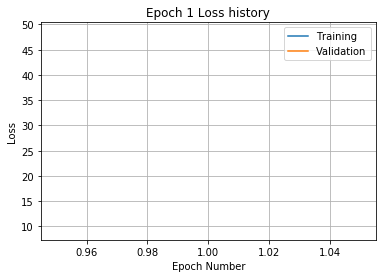

Training
Iteration 0: with minibatch training loss = 14 and relative error of 0.43
Iteration 20: with minibatch training loss = 13.3 and relative error of 0.42
Iteration 40: with minibatch training loss = 12 and relative error of 0.4
Iteration 60: with minibatch training loss = 11.3 and relative error of 0.4
Iteration 80: with minibatch training loss = 14.7 and relative error of 0.44
Iteration 100: with minibatch training loss = 11.5 and relative error of 0.4
Iteration 120: with minibatch training loss = 11.1 and relative error of 0.38
Iteration 140: with minibatch training loss = 11.2 and relative error of 0.38
Iteration 160: with minibatch training loss = 13.5 and relative error of 0.43
Iteration 180: with minibatch training loss = 12.7 and relative error of 0.4
Iteration 200: with minibatch training loss = 10.1 and relative error of 0.36
Iteration 220: with minibatch training loss = 12.8 and relative error of 0.41
Epoch 2, Overall loss = 12.1, relative error = 0.4, and process time 

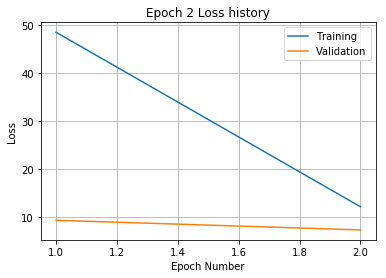

Training
Iteration 0: with minibatch training loss = 13.1 and relative error of 0.4
Iteration 20: with minibatch training loss = 11.8 and relative error of 0.38
Iteration 40: with minibatch training loss = 9.08 and relative error of 0.35
Iteration 60: with minibatch training loss = 10.6 and relative error of 0.36
Iteration 80: with minibatch training loss = 10.3 and relative error of 0.37
Iteration 100: with minibatch training loss = 10 and relative error of 0.36
Iteration 120: with minibatch training loss = 10.9 and relative error of 0.38
Iteration 140: with minibatch training loss = 10.4 and relative error of 0.37
Iteration 160: with minibatch training loss = 9.74 and relative error of 0.37
Iteration 180: with minibatch training loss = 8.59 and relative error of 0.33
Iteration 200: with minibatch training loss = 9.06 and relative error of 0.35
Iteration 220: with minibatch training loss = 9.12 and relative error of 0.35
Epoch 3, Overall loss = 9.85, relative error = 0.36, and process

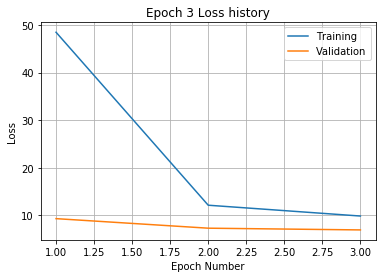

Training
Iteration 0: with minibatch training loss = 9.32 and relative error of 0.36
Iteration 20: with minibatch training loss = 11.6 and relative error of 0.38
Iteration 40: with minibatch training loss = 9.88 and relative error of 0.37
Iteration 60: with minibatch training loss = 8.91 and relative error of 0.35
Iteration 80: with minibatch training loss = 8.74 and relative error of 0.34
Iteration 100: with minibatch training loss = 7.46 and relative error of 0.31
Iteration 120: with minibatch training loss = 6.71 and relative error of 0.3
Iteration 140: with minibatch training loss = 8.08 and relative error of 0.33
Iteration 160: with minibatch training loss = 8 and relative error of 0.32
Iteration 180: with minibatch training loss = 7.96 and relative error of 0.33
Iteration 200: with minibatch training loss = 8.94 and relative error of 0.34
Iteration 220: with minibatch training loss = 6.1 and relative error of 0.29
Epoch 4, Overall loss = 8.67, relative error = 0.337, and process 

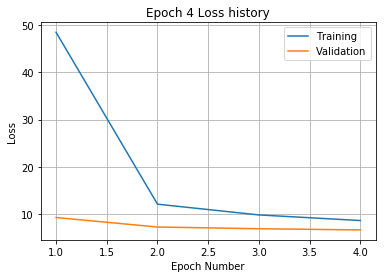

Training
Iteration 0: with minibatch training loss = 8.14 and relative error of 0.33
Iteration 20: with minibatch training loss = 7.62 and relative error of 0.31
Iteration 40: with minibatch training loss = 7.47 and relative error of 0.32
Iteration 60: with minibatch training loss = 7.42 and relative error of 0.34
Iteration 80: with minibatch training loss = 7.68 and relative error of 0.31
Iteration 100: with minibatch training loss = 7.05 and relative error of 0.31
Iteration 120: with minibatch training loss = 6.43 and relative error of 0.31
Iteration 140: with minibatch training loss = 7.51 and relative error of 0.31
Iteration 160: with minibatch training loss = 6.73 and relative error of 0.29
Iteration 180: with minibatch training loss = 6.68 and relative error of 0.3
Iteration 200: with minibatch training loss = 9.98 and relative error of 0.37
Iteration 220: with minibatch training loss = 6.64 and relative error of 0.29
Epoch 5, Overall loss = 7.93, relative error = 0.323, and proc

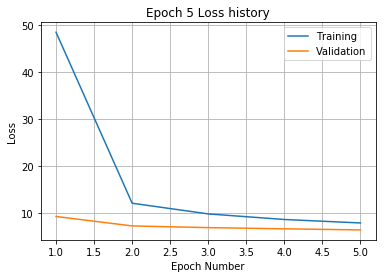

Training
Iteration 0: with minibatch training loss = 7.67 and relative error of 0.32
Iteration 20: with minibatch training loss = 8.85 and relative error of 0.34
Iteration 40: with minibatch training loss = 7.62 and relative error of 0.31
Iteration 60: with minibatch training loss = 7.59 and relative error of 0.31
Iteration 80: with minibatch training loss = 7.05 and relative error of 0.3
Iteration 100: with minibatch training loss = 8.5 and relative error of 0.35
Iteration 120: with minibatch training loss = 6.72 and relative error of 0.29
Iteration 140: with minibatch training loss = 8.59 and relative error of 0.34
Iteration 160: with minibatch training loss = 5.01 and relative error of 0.27
Iteration 180: with minibatch training loss = 6.05 and relative error of 0.29
Iteration 200: with minibatch training loss = 7.15 and relative error of 0.31
Iteration 220: with minibatch training loss = 5.72 and relative error of 0.28
Epoch 6, Overall loss = 7.31, relative error = 0.31, and proces

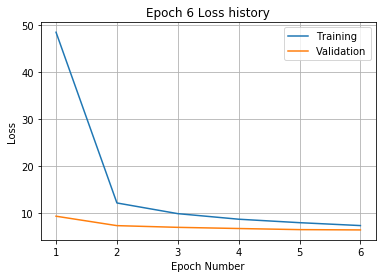

Training
Iteration 0: with minibatch training loss = 10.1 and relative error of 0.36
Iteration 20: with minibatch training loss = 5.53 and relative error of 0.27
Iteration 40: with minibatch training loss = 9.03 and relative error of 0.35
Iteration 60: with minibatch training loss = 7.57 and relative error of 0.31
Iteration 80: with minibatch training loss = 5.29 and relative error of 0.26
Iteration 100: with minibatch training loss = 8.33 and relative error of 0.32
Iteration 120: with minibatch training loss = 5.75 and relative error of 0.27
Iteration 140: with minibatch training loss = 5.14 and relative error of 0.26
Iteration 160: with minibatch training loss = 8.64 and relative error of 0.34
Iteration 180: with minibatch training loss = 6.83 and relative error of 0.3
Iteration 200: with minibatch training loss = 7.74 and relative error of 0.31
Iteration 220: with minibatch training loss = 6.95 and relative error of 0.3
Epoch 7, Overall loss = 6.88, relative error = 0.3, and process

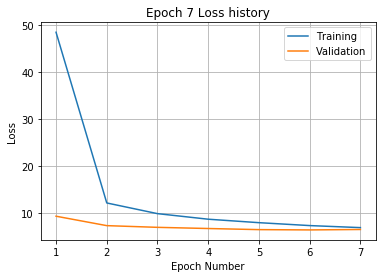

Training
Iteration 0: with minibatch training loss = 4.52 and relative error of 0.24
Iteration 20: with minibatch training loss = 7.52 and relative error of 0.32
Iteration 40: with minibatch training loss = 7.29 and relative error of 0.31
Iteration 60: with minibatch training loss = 7.42 and relative error of 0.31
Iteration 80: with minibatch training loss = 6.56 and relative error of 0.28
Iteration 100: with minibatch training loss = 6.37 and relative error of 0.29
Iteration 120: with minibatch training loss = 6.25 and relative error of 0.28
Iteration 140: with minibatch training loss = 8.8 and relative error of 0.35
Iteration 160: with minibatch training loss = 6.96 and relative error of 0.3
Iteration 180: with minibatch training loss = 5.14 and relative error of 0.26
Iteration 200: with minibatch training loss = 9.56 and relative error of 0.36
Iteration 220: with minibatch training loss = 6.37 and relative error of 0.3
Epoch 8, Overall loss = 6.58, relative error = 0.294, and proces

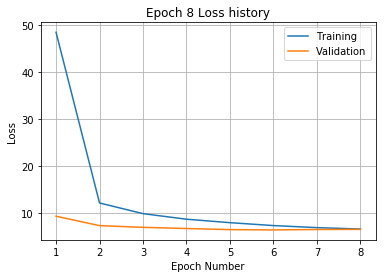

Training
Iteration 0: with minibatch training loss = 6.5 and relative error of 0.29
Iteration 20: with minibatch training loss = 5.44 and relative error of 0.26
Iteration 40: with minibatch training loss = 6.8 and relative error of 0.31
Iteration 60: with minibatch training loss = 7.21 and relative error of 0.32
Iteration 80: with minibatch training loss = 6.02 and relative error of 0.29
Iteration 100: with minibatch training loss = 5.15 and relative error of 0.25
Iteration 120: with minibatch training loss = 5.5 and relative error of 0.27
Iteration 140: with minibatch training loss = 6.24 and relative error of 0.28
Iteration 160: with minibatch training loss = 8.13 and relative error of 0.33
Iteration 180: with minibatch training loss = 6.85 and relative error of 0.31
Iteration 200: with minibatch training loss = 5.67 and relative error of 0.27
Iteration 220: with minibatch training loss = 4.33 and relative error of 0.24
Epoch 9, Overall loss = 6.33, relative error = 0.288, and proces

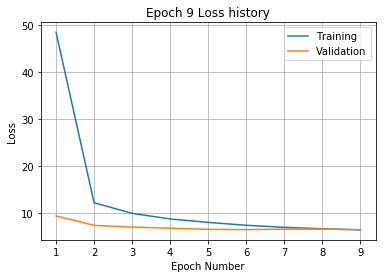

Training
Iteration 0: with minibatch training loss = 7.58 and relative error of 0.33
Iteration 20: with minibatch training loss = 5.63 and relative error of 0.28
Iteration 40: with minibatch training loss = 6.82 and relative error of 0.3
Iteration 60: with minibatch training loss = 4.88 and relative error of 0.25
Iteration 80: with minibatch training loss = 6.6 and relative error of 0.3
Iteration 100: with minibatch training loss = 6.02 and relative error of 0.28
Iteration 120: with minibatch training loss = 3.48 and relative error of 0.22
Iteration 140: with minibatch training loss = 7.21 and relative error of 0.32
Iteration 160: with minibatch training loss = 7.19 and relative error of 0.29
Iteration 180: with minibatch training loss = 6.07 and relative error of 0.28
Iteration 200: with minibatch training loss = 6.46 and relative error of 0.3
Iteration 220: with minibatch training loss = 6.34 and relative error of 0.29
Epoch 10, Overall loss = 6.18, relative error = 0.285, and proces

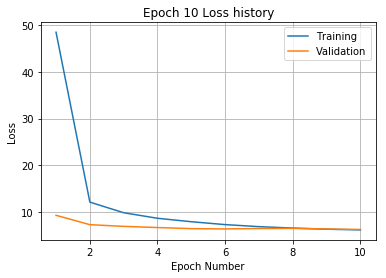

Training
Iteration 0: with minibatch training loss = 4.36 and relative error of 0.24
Iteration 20: with minibatch training loss = 6.12 and relative error of 0.3
Iteration 40: with minibatch training loss = 5.75 and relative error of 0.27
Iteration 60: with minibatch training loss = 6.91 and relative error of 0.29
Iteration 80: with minibatch training loss = 5.87 and relative error of 0.28
Iteration 100: with minibatch training loss = 5.26 and relative error of 0.27
Iteration 120: with minibatch training loss = 5.47 and relative error of 0.27
Iteration 140: with minibatch training loss = 6.1 and relative error of 0.29
Iteration 160: with minibatch training loss = 8.04 and relative error of 0.32
Iteration 180: with minibatch training loss = 5.3 and relative error of 0.27
Iteration 200: with minibatch training loss = 5.68 and relative error of 0.27
Iteration 220: with minibatch training loss = 6.41 and relative error of 0.29
Epoch 11, Overall loss = 5.94, relative error = 0.279, and proce

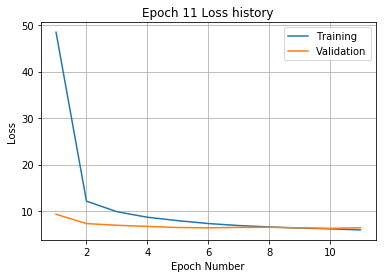

Training
Iteration 0: with minibatch training loss = 5.69 and relative error of 0.27
Iteration 20: with minibatch training loss = 5.51 and relative error of 0.27
Iteration 40: with minibatch training loss = 5.96 and relative error of 0.29
Iteration 60: with minibatch training loss = 4.68 and relative error of 0.26
Iteration 80: with minibatch training loss = 4.55 and relative error of 0.25
Iteration 100: with minibatch training loss = 4.41 and relative error of 0.24
Iteration 120: with minibatch training loss = 6.03 and relative error of 0.29
Iteration 140: with minibatch training loss = 6.97 and relative error of 0.3
Iteration 160: with minibatch training loss = 7.97 and relative error of 0.3
Iteration 180: with minibatch training loss = 5.37 and relative error of 0.27
Iteration 200: with minibatch training loss = 4.38 and relative error of 0.24
Iteration 220: with minibatch training loss = 3.9 and relative error of 0.24
Epoch 12, Overall loss = 5.76, relative error = 0.275, and proce

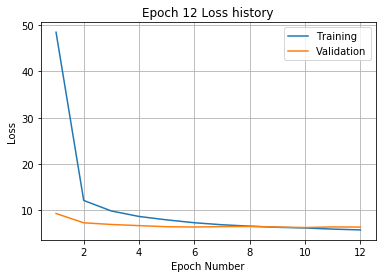

Training
Iteration 0: with minibatch training loss = 5.78 and relative error of 0.3
Iteration 20: with minibatch training loss = 6.35 and relative error of 0.29
Iteration 40: with minibatch training loss = 5.87 and relative error of 0.27
Iteration 60: with minibatch training loss = 6.56 and relative error of 0.29
Iteration 80: with minibatch training loss = 8.2 and relative error of 0.31
Iteration 100: with minibatch training loss = 7.8 and relative error of 0.33
Iteration 120: with minibatch training loss = 6.86 and relative error of 0.3
Iteration 140: with minibatch training loss = 4.64 and relative error of 0.24
Iteration 160: with minibatch training loss = 5.06 and relative error of 0.26
Iteration 180: with minibatch training loss = 6.91 and relative error of 0.31
Iteration 200: with minibatch training loss = 5.65 and relative error of 0.27
Iteration 220: with minibatch training loss = 4.46 and relative error of 0.24
Epoch 13, Overall loss = 5.66, relative error = 0.272, and proces

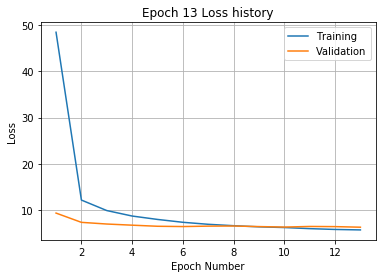

Training
Iteration 0: with minibatch training loss = 7.83 and relative error of 0.32
Iteration 20: with minibatch training loss = 6.54 and relative error of 0.29
Iteration 40: with minibatch training loss = 5.25 and relative error of 0.27
Iteration 60: with minibatch training loss = 4.09 and relative error of 0.23
Iteration 80: with minibatch training loss = 5.57 and relative error of 0.27
Iteration 100: with minibatch training loss = 5.38 and relative error of 0.26
Iteration 120: with minibatch training loss = 6.83 and relative error of 0.3
Iteration 140: with minibatch training loss = 8.57 and relative error of 0.34
Iteration 160: with minibatch training loss = 4.41 and relative error of 0.24
Iteration 180: with minibatch training loss = 7.7 and relative error of 0.32
Iteration 200: with minibatch training loss = 5.59 and relative error of 0.27
Iteration 220: with minibatch training loss = 5.92 and relative error of 0.28
Epoch 14, Overall loss = 5.43, relative error = 0.267, and proc

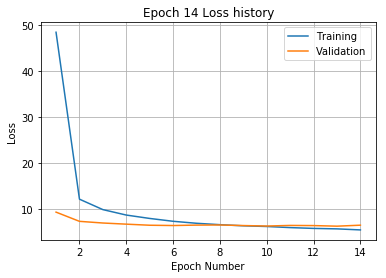

Training
Iteration 0: with minibatch training loss = 5.44 and relative error of 0.26
Iteration 20: with minibatch training loss = 5.16 and relative error of 0.25
Iteration 40: with minibatch training loss = 4.65 and relative error of 0.25
Iteration 60: with minibatch training loss = 6.35 and relative error of 0.29
Iteration 80: with minibatch training loss = 5.48 and relative error of 0.27
Iteration 100: with minibatch training loss = 5.17 and relative error of 0.28
Iteration 120: with minibatch training loss = 4.83 and relative error of 0.26
Iteration 140: with minibatch training loss = 7.28 and relative error of 0.31
Iteration 160: with minibatch training loss = 4.8 and relative error of 0.25
Iteration 180: with minibatch training loss = 4.63 and relative error of 0.26
Iteration 200: with minibatch training loss = 5.91 and relative error of 0.29
Iteration 220: with minibatch training loss = 6.77 and relative error of 0.29
Epoch 15, Overall loss = 5.35, relative error = 0.265, and pro

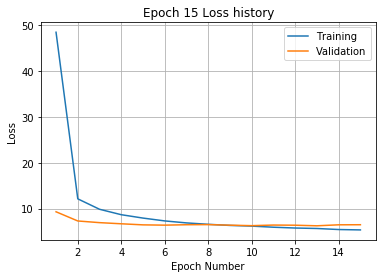

Training
Iteration 0: with minibatch training loss = 6.4 and relative error of 0.3
Iteration 20: with minibatch training loss = 5.85 and relative error of 0.27
Iteration 40: with minibatch training loss = 6.64 and relative error of 0.3
Iteration 60: with minibatch training loss = 4.91 and relative error of 0.26
Iteration 80: with minibatch training loss = 5.47 and relative error of 0.27
Iteration 100: with minibatch training loss = 4.42 and relative error of 0.24
Iteration 120: with minibatch training loss = 5.63 and relative error of 0.28
Iteration 140: with minibatch training loss = 5.08 and relative error of 0.26
Iteration 160: with minibatch training loss = 5.05 and relative error of 0.26
Iteration 180: with minibatch training loss = 4.22 and relative error of 0.23
Iteration 200: with minibatch training loss = 4.29 and relative error of 0.24
Iteration 220: with minibatch training loss = 6.72 and relative error of 0.3
Epoch 16, Overall loss = 5.28, relative error = 0.263, and proces

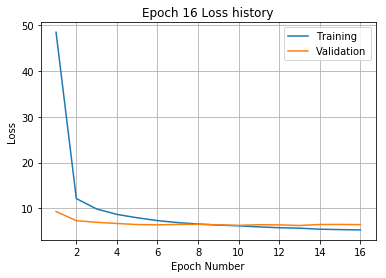

Training
Iteration 0: with minibatch training loss = 5.5 and relative error of 0.27
Iteration 20: with minibatch training loss = 4.86 and relative error of 0.25
Iteration 40: with minibatch training loss = 3.73 and relative error of 0.22
Iteration 60: with minibatch training loss = 4.71 and relative error of 0.25
Iteration 80: with minibatch training loss = 5.76 and relative error of 0.28
Iteration 100: with minibatch training loss = 5.24 and relative error of 0.26
Iteration 120: with minibatch training loss = 4.81 and relative error of 0.25
Iteration 140: with minibatch training loss = 4.13 and relative error of 0.23
Iteration 160: with minibatch training loss = 5.58 and relative error of 0.27
Iteration 180: with minibatch training loss = 3.94 and relative error of 0.23
Iteration 200: with minibatch training loss = 4.37 and relative error of 0.24
Iteration 220: with minibatch training loss = 4.39 and relative error of 0.24
Epoch 17, Overall loss = 5.16, relative error = 0.26, and proc

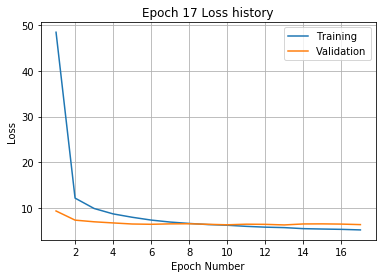

Training
Iteration 0: with minibatch training loss = 4.2 and relative error of 0.23
Iteration 20: with minibatch training loss = 9.26 and relative error of 0.35
Iteration 40: with minibatch training loss = 5.08 and relative error of 0.27
Iteration 60: with minibatch training loss = 4.88 and relative error of 0.25
Iteration 80: with minibatch training loss = 5.1 and relative error of 0.27
Iteration 100: with minibatch training loss = 4.54 and relative error of 0.25
Iteration 120: with minibatch training loss = 4.88 and relative error of 0.25
Iteration 140: with minibatch training loss = 5.71 and relative error of 0.27
Iteration 160: with minibatch training loss = 5.21 and relative error of 0.26
Iteration 180: with minibatch training loss = 5.79 and relative error of 0.28
Iteration 200: with minibatch training loss = 3.96 and relative error of 0.23
Iteration 220: with minibatch training loss = 3.85 and relative error of 0.22
Epoch 18, Overall loss = 5.13, relative error = 0.259, and proc

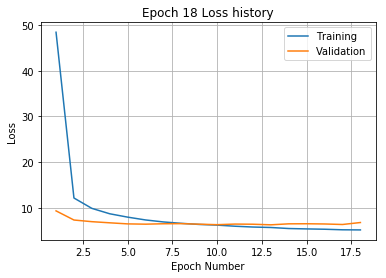

Validation error has stopped improving! Training on repetition 2 stopped!
Training
Iteration 0: with minibatch training loss = 232 and relative error of 1.8
Iteration 20: with minibatch training loss = 116 and relative error of 1.3
Iteration 40: with minibatch training loss = 78.4 and relative error of 0.98
Iteration 60: with minibatch training loss = 64.2 and relative error of 0.89
Iteration 80: with minibatch training loss = 45.1 and relative error of 0.79
Iteration 100: with minibatch training loss = 34.3 and relative error of 0.66
Iteration 120: with minibatch training loss = 23.5 and relative error of 0.55
Iteration 140: with minibatch training loss = 18.7 and relative error of 0.5
Iteration 160: with minibatch training loss = 18 and relative error of 0.5
Iteration 180: with minibatch training loss = 22.3 and relative error of 0.54
Iteration 200: with minibatch training loss = 15.9 and relative error of 0.45
Iteration 220: with minibatch training loss = 15.8 and relative error of 

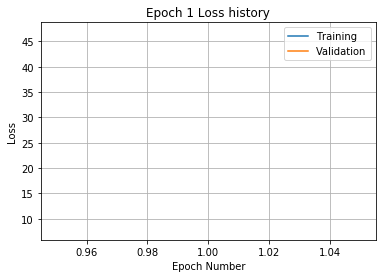

Training
Iteration 0: with minibatch training loss = 15.4 and relative error of 0.43
Iteration 20: with minibatch training loss = 13.8 and relative error of 0.41
Iteration 40: with minibatch training loss = 11.8 and relative error of 0.4
Iteration 60: with minibatch training loss = 15.9 and relative error of 0.44
Iteration 80: with minibatch training loss = 14.3 and relative error of 0.44
Iteration 100: with minibatch training loss = 11.6 and relative error of 0.37
Iteration 120: with minibatch training loss = 12.7 and relative error of 0.4
Iteration 140: with minibatch training loss = 10.8 and relative error of 0.36
Iteration 160: with minibatch training loss = 13.3 and relative error of 0.4
Iteration 180: with minibatch training loss = 10.9 and relative error of 0.38
Iteration 200: with minibatch training loss = 12.1 and relative error of 0.37
Iteration 220: with minibatch training loss = 8.28 and relative error of 0.32
Epoch 2, Overall loss = 12.4, relative error = 0.401, and proces

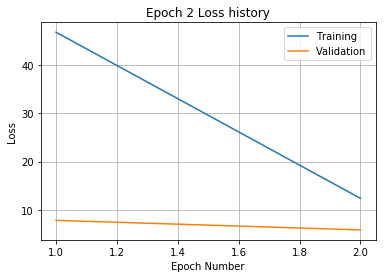

Training
Iteration 0: with minibatch training loss = 10.5 and relative error of 0.38
Iteration 20: with minibatch training loss = 9.67 and relative error of 0.35
Iteration 40: with minibatch training loss = 11.9 and relative error of 0.4
Iteration 60: with minibatch training loss = 10.3 and relative error of 0.36
Iteration 80: with minibatch training loss = 9.41 and relative error of 0.37
Iteration 100: with minibatch training loss = 8.77 and relative error of 0.35
Iteration 120: with minibatch training loss = 9.4 and relative error of 0.35
Iteration 140: with minibatch training loss = 10 and relative error of 0.36
Iteration 160: with minibatch training loss = 8.35 and relative error of 0.34
Iteration 180: with minibatch training loss = 10.5 and relative error of 0.36
Iteration 200: with minibatch training loss = 9.99 and relative error of 0.37
Iteration 220: with minibatch training loss = 9.51 and relative error of 0.34
Epoch 3, Overall loss = 10, relative error = 0.36, and process ti

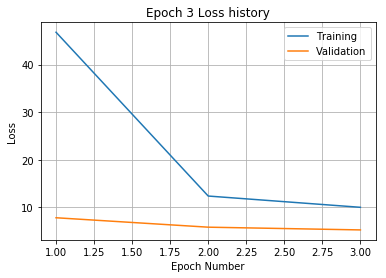

Training
Iteration 0: with minibatch training loss = 11.8 and relative error of 0.38
Iteration 20: with minibatch training loss = 7.92 and relative error of 0.32
Iteration 40: with minibatch training loss = 13.1 and relative error of 0.39
Iteration 60: with minibatch training loss = 14 and relative error of 0.41
Iteration 80: with minibatch training loss = 9.72 and relative error of 0.35
Iteration 100: with minibatch training loss = 7.23 and relative error of 0.31
Iteration 120: with minibatch training loss = 7.94 and relative error of 0.32
Iteration 140: with minibatch training loss = 8.98 and relative error of 0.33
Iteration 160: with minibatch training loss = 8.97 and relative error of 0.34
Iteration 180: with minibatch training loss = 7.48 and relative error of 0.33
Iteration 200: with minibatch training loss = 7.07 and relative error of 0.31
Iteration 220: with minibatch training loss = 8.44 and relative error of 0.33
Epoch 4, Overall loss = 8.82, relative error = 0.338, and proce

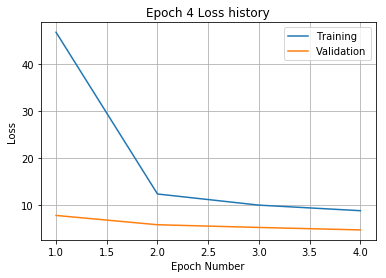

Training
Iteration 0: with minibatch training loss = 6.28 and relative error of 0.3
Iteration 20: with minibatch training loss = 8 and relative error of 0.32
Iteration 40: with minibatch training loss = 10.1 and relative error of 0.36
Iteration 60: with minibatch training loss = 7.16 and relative error of 0.31
Iteration 80: with minibatch training loss = 6.79 and relative error of 0.29
Iteration 100: with minibatch training loss = 7.91 and relative error of 0.32
Iteration 120: with minibatch training loss = 6.82 and relative error of 0.3
Iteration 140: with minibatch training loss = 6.87 and relative error of 0.29
Iteration 160: with minibatch training loss = 7.83 and relative error of 0.32
Iteration 180: with minibatch training loss = 7.18 and relative error of 0.31
Iteration 200: with minibatch training loss = 8.73 and relative error of 0.34
Iteration 220: with minibatch training loss = 9.34 and relative error of 0.34
Epoch 5, Overall loss = 8.08, relative error = 0.323, and process 

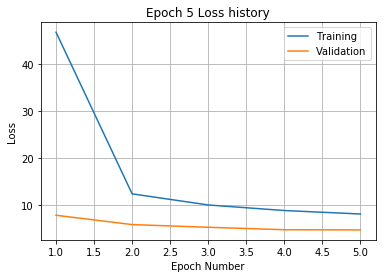

Training
Iteration 0: with minibatch training loss = 9.63 and relative error of 0.36
Iteration 20: with minibatch training loss = 7.18 and relative error of 0.31
Iteration 40: with minibatch training loss = 7.31 and relative error of 0.31
Iteration 60: with minibatch training loss = 7.42 and relative error of 0.32
Iteration 80: with minibatch training loss = 5.56 and relative error of 0.27
Iteration 100: with minibatch training loss = 7.23 and relative error of 0.3
Iteration 120: with minibatch training loss = 6.19 and relative error of 0.3
Iteration 140: with minibatch training loss = 8.84 and relative error of 0.34
Iteration 160: with minibatch training loss = 7.02 and relative error of 0.3
Iteration 180: with minibatch training loss = 6.81 and relative error of 0.29
Iteration 200: with minibatch training loss = 5.83 and relative error of 0.28
Iteration 220: with minibatch training loss = 7.46 and relative error of 0.31
Epoch 6, Overall loss = 7.52, relative error = 0.312, and proces

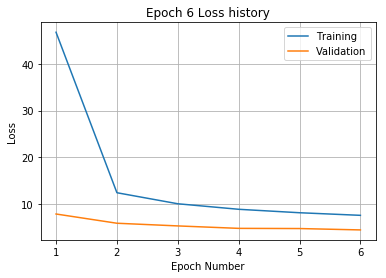

Training
Iteration 0: with minibatch training loss = 6.31 and relative error of 0.28
Iteration 20: with minibatch training loss = 7.3 and relative error of 0.31
Iteration 40: with minibatch training loss = 7.16 and relative error of 0.3
Iteration 60: with minibatch training loss = 8.7 and relative error of 0.34
Iteration 80: with minibatch training loss = 9.04 and relative error of 0.34
Iteration 100: with minibatch training loss = 7.23 and relative error of 0.3
Iteration 120: with minibatch training loss = 7.49 and relative error of 0.32
Iteration 140: with minibatch training loss = 5.23 and relative error of 0.26
Iteration 160: with minibatch training loss = 7.79 and relative error of 0.33
Iteration 180: with minibatch training loss = 7.31 and relative error of 0.32
Iteration 200: with minibatch training loss = 10.2 and relative error of 0.35
Iteration 220: with minibatch training loss = 7.64 and relative error of 0.33
Epoch 7, Overall loss = 7.13, relative error = 0.304, and process

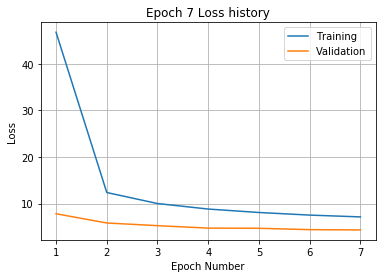

Training
Iteration 0: with minibatch training loss = 6.03 and relative error of 0.28
Iteration 20: with minibatch training loss = 5.92 and relative error of 0.28
Iteration 40: with minibatch training loss = 5.67 and relative error of 0.27
Iteration 60: with minibatch training loss = 6.72 and relative error of 0.3
Iteration 80: with minibatch training loss = 4.93 and relative error of 0.25
Iteration 100: with minibatch training loss = 8.12 and relative error of 0.33
Iteration 120: with minibatch training loss = 5.98 and relative error of 0.29
Iteration 140: with minibatch training loss = 6.2 and relative error of 0.3
Iteration 160: with minibatch training loss = 7.03 and relative error of 0.31
Iteration 180: with minibatch training loss = 8.44 and relative error of 0.33
Iteration 200: with minibatch training loss = 7.52 and relative error of 0.3
Iteration 220: with minibatch training loss = 7.16 and relative error of 0.3
Epoch 8, Overall loss = 6.79, relative error = 0.296, and process 

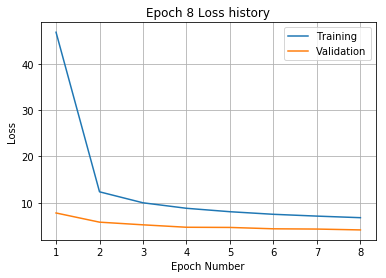

Training
Iteration 0: with minibatch training loss = 7.8 and relative error of 0.31
Iteration 20: with minibatch training loss = 7.44 and relative error of 0.31
Iteration 40: with minibatch training loss = 4.97 and relative error of 0.24
Iteration 60: with minibatch training loss = 8.76 and relative error of 0.33
Iteration 80: with minibatch training loss = 5.3 and relative error of 0.26
Iteration 100: with minibatch training loss = 5.54 and relative error of 0.26
Iteration 120: with minibatch training loss = 6.95 and relative error of 0.29
Iteration 140: with minibatch training loss = 5.59 and relative error of 0.28
Iteration 160: with minibatch training loss = 8.51 and relative error of 0.32
Iteration 180: with minibatch training loss = 7.71 and relative error of 0.31
Iteration 200: with minibatch training loss = 5.98 and relative error of 0.28
Iteration 220: with minibatch training loss = 5.29 and relative error of 0.26
Epoch 9, Overall loss = 6.55, relative error = 0.291, and proce

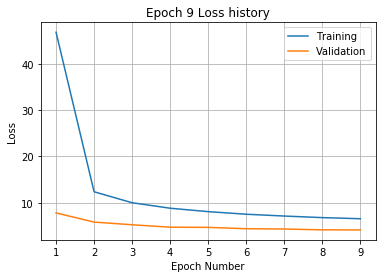

Training
Iteration 0: with minibatch training loss = 7.28 and relative error of 0.3
Iteration 20: with minibatch training loss = 5.18 and relative error of 0.26
Iteration 40: with minibatch training loss = 4.76 and relative error of 0.25
Iteration 60: with minibatch training loss = 5.3 and relative error of 0.27
Iteration 80: with minibatch training loss = 7.01 and relative error of 0.29
Iteration 100: with minibatch training loss = 6.79 and relative error of 0.29
Iteration 120: with minibatch training loss = 6.22 and relative error of 0.29
Iteration 140: with minibatch training loss = 7.02 and relative error of 0.29
Iteration 160: with minibatch training loss = 5.65 and relative error of 0.27
Iteration 180: with minibatch training loss = 9.28 and relative error of 0.34
Iteration 200: with minibatch training loss = 5.53 and relative error of 0.28
Iteration 220: with minibatch training loss = 6.3 and relative error of 0.29
Epoch 10, Overall loss = 6.29, relative error = 0.285, and proce

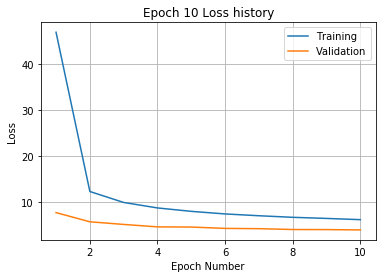

Training
Iteration 0: with minibatch training loss = 7.55 and relative error of 0.32
Iteration 20: with minibatch training loss = 7.43 and relative error of 0.31
Iteration 40: with minibatch training loss = 7.95 and relative error of 0.31
Iteration 60: with minibatch training loss = 7.89 and relative error of 0.31
Iteration 80: with minibatch training loss = 5.66 and relative error of 0.27
Iteration 100: with minibatch training loss = 4.78 and relative error of 0.25
Iteration 120: with minibatch training loss = 3.95 and relative error of 0.23
Iteration 140: with minibatch training loss = 6.2 and relative error of 0.28
Iteration 160: with minibatch training loss = 6.36 and relative error of 0.3
Iteration 180: with minibatch training loss = 6.85 and relative error of 0.29
Iteration 200: with minibatch training loss = 5.4 and relative error of 0.27
Iteration 220: with minibatch training loss = 5.64 and relative error of 0.27
Epoch 11, Overall loss = 6.06, relative error = 0.28, and proces

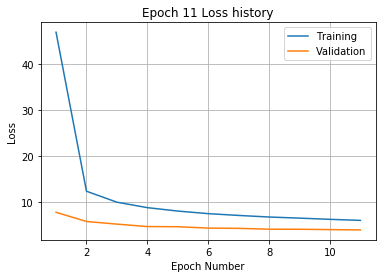

Training
Iteration 0: with minibatch training loss = 5.59 and relative error of 0.27
Iteration 20: with minibatch training loss = 7.1 and relative error of 0.3
Iteration 40: with minibatch training loss = 5.23 and relative error of 0.27
Iteration 60: with minibatch training loss = 7.26 and relative error of 0.31
Iteration 80: with minibatch training loss = 6.4 and relative error of 0.28
Iteration 100: with minibatch training loss = 6.66 and relative error of 0.31
Iteration 120: with minibatch training loss = 5.79 and relative error of 0.26
Iteration 140: with minibatch training loss = 5.5 and relative error of 0.27
Iteration 160: with minibatch training loss = 5.4 and relative error of 0.27
Iteration 180: with minibatch training loss = 5 and relative error of 0.24
Iteration 200: with minibatch training loss = 5.73 and relative error of 0.28
Iteration 220: with minibatch training loss = 6.22 and relative error of 0.28
Epoch 12, Overall loss = 5.98, relative error = 0.278, and process ti

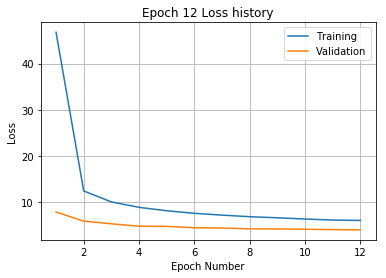

Training
Iteration 0: with minibatch training loss = 4.34 and relative error of 0.23
Iteration 20: with minibatch training loss = 4.22 and relative error of 0.24
Iteration 40: with minibatch training loss = 6.14 and relative error of 0.28
Iteration 60: with minibatch training loss = 5.49 and relative error of 0.27
Iteration 80: with minibatch training loss = 6.27 and relative error of 0.27
Iteration 100: with minibatch training loss = 6.76 and relative error of 0.31
Iteration 120: with minibatch training loss = 5.42 and relative error of 0.27
Iteration 140: with minibatch training loss = 4.38 and relative error of 0.24
Iteration 160: with minibatch training loss = 4.07 and relative error of 0.22
Iteration 180: with minibatch training loss = 6.32 and relative error of 0.28
Iteration 200: with minibatch training loss = 5.78 and relative error of 0.27
Iteration 220: with minibatch training loss = 6.72 and relative error of 0.3
Epoch 13, Overall loss = 5.8, relative error = 0.274, and proc

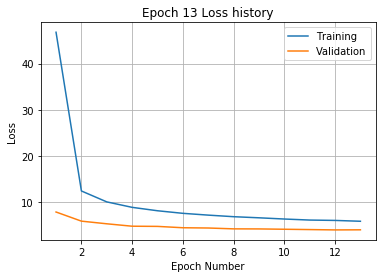

Training
Iteration 0: with minibatch training loss = 5.95 and relative error of 0.28
Iteration 20: with minibatch training loss = 5.7 and relative error of 0.26
Iteration 40: with minibatch training loss = 6.78 and relative error of 0.31
Iteration 60: with minibatch training loss = 4.71 and relative error of 0.25
Iteration 80: with minibatch training loss = 3.64 and relative error of 0.22
Iteration 100: with minibatch training loss = 7.49 and relative error of 0.31
Iteration 120: with minibatch training loss = 4.99 and relative error of 0.26
Iteration 140: with minibatch training loss = 5.31 and relative error of 0.26
Iteration 160: with minibatch training loss = 6.59 and relative error of 0.29
Iteration 180: with minibatch training loss = 7.28 and relative error of 0.31
Iteration 200: with minibatch training loss = 6.8 and relative error of 0.3
Iteration 220: with minibatch training loss = 5.55 and relative error of 0.27
Epoch 14, Overall loss = 5.68, relative error = 0.271, and proce

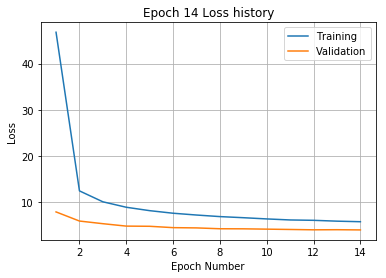

Training
Iteration 0: with minibatch training loss = 4.68 and relative error of 0.25
Iteration 20: with minibatch training loss = 4.69 and relative error of 0.25
Iteration 40: with minibatch training loss = 6.71 and relative error of 0.29
Iteration 60: with minibatch training loss = 5.92 and relative error of 0.28
Iteration 80: with minibatch training loss = 6.27 and relative error of 0.3
Iteration 100: with minibatch training loss = 4.46 and relative error of 0.24
Iteration 120: with minibatch training loss = 5.42 and relative error of 0.26
Iteration 140: with minibatch training loss = 8.08 and relative error of 0.33
Iteration 160: with minibatch training loss = 4.93 and relative error of 0.25
Iteration 180: with minibatch training loss = 6.4 and relative error of 0.29
Iteration 200: with minibatch training loss = 5.09 and relative error of 0.28
Iteration 220: with minibatch training loss = 4.31 and relative error of 0.24
Epoch 15, Overall loss = 5.49, relative error = 0.266, and proc

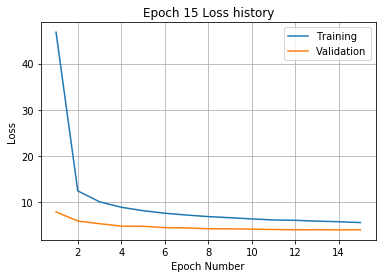

Training
Iteration 0: with minibatch training loss = 5 and relative error of 0.26
Iteration 20: with minibatch training loss = 4.82 and relative error of 0.25
Iteration 40: with minibatch training loss = 6.78 and relative error of 0.29
Iteration 60: with minibatch training loss = 5.38 and relative error of 0.26
Iteration 80: with minibatch training loss = 6.53 and relative error of 0.29
Iteration 100: with minibatch training loss = 5.14 and relative error of 0.28
Iteration 120: with minibatch training loss = 4.74 and relative error of 0.25
Iteration 140: with minibatch training loss = 6.27 and relative error of 0.28
Iteration 160: with minibatch training loss = 5.42 and relative error of 0.27
Iteration 180: with minibatch training loss = 5.55 and relative error of 0.26
Iteration 200: with minibatch training loss = 5.61 and relative error of 0.27
Iteration 220: with minibatch training loss = 6.68 and relative error of 0.31
Epoch 16, Overall loss = 5.4, relative error = 0.264, and proces

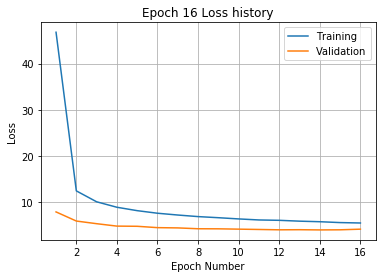

Training
Iteration 0: with minibatch training loss = 6.23 and relative error of 0.28
Iteration 20: with minibatch training loss = 5.35 and relative error of 0.27
Iteration 40: with minibatch training loss = 6.22 and relative error of 0.28
Iteration 60: with minibatch training loss = 4.99 and relative error of 0.25
Iteration 80: with minibatch training loss = 5.44 and relative error of 0.27
Iteration 100: with minibatch training loss = 5.37 and relative error of 0.27
Iteration 120: with minibatch training loss = 4.81 and relative error of 0.25
Iteration 140: with minibatch training loss = 4.57 and relative error of 0.24
Iteration 160: with minibatch training loss = 4.83 and relative error of 0.25
Iteration 180: with minibatch training loss = 3.47 and relative error of 0.21
Iteration 200: with minibatch training loss = 6.85 and relative error of 0.29
Iteration 220: with minibatch training loss = 6.29 and relative error of 0.28
Epoch 17, Overall loss = 5.32, relative error = 0.262, and pr

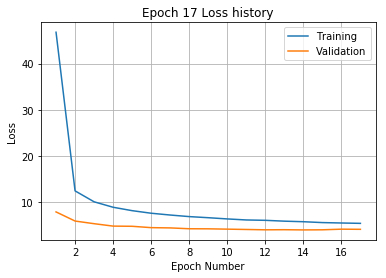

Training
Iteration 0: with minibatch training loss = 5.69 and relative error of 0.26
Iteration 20: with minibatch training loss = 4.75 and relative error of 0.26
Iteration 40: with minibatch training loss = 4.16 and relative error of 0.23
Iteration 60: with minibatch training loss = 5.65 and relative error of 0.27
Iteration 80: with minibatch training loss = 5.39 and relative error of 0.26
Iteration 100: with minibatch training loss = 4.77 and relative error of 0.25
Iteration 120: with minibatch training loss = 4.7 and relative error of 0.25
Iteration 140: with minibatch training loss = 5.37 and relative error of 0.26
Iteration 160: with minibatch training loss = 6.21 and relative error of 0.28
Iteration 180: with minibatch training loss = 5.68 and relative error of 0.27
Iteration 200: with minibatch training loss = 5.24 and relative error of 0.26
Iteration 220: with minibatch training loss = 3.77 and relative error of 0.22
Epoch 18, Overall loss = 5.23, relative error = 0.26, and proc

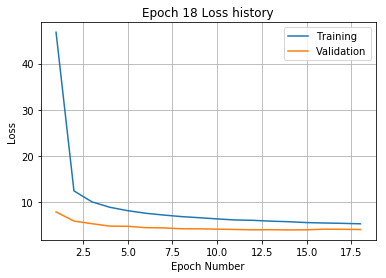

Training
Iteration 0: with minibatch training loss = 2.96 and relative error of 0.2
Iteration 20: with minibatch training loss = 5.05 and relative error of 0.25
Iteration 40: with minibatch training loss = 4.12 and relative error of 0.23
Iteration 60: with minibatch training loss = 4.86 and relative error of 0.25
Iteration 80: with minibatch training loss = 3.59 and relative error of 0.22
Iteration 100: with minibatch training loss = 4.09 and relative error of 0.23
Iteration 120: with minibatch training loss = 5.4 and relative error of 0.26
Iteration 140: with minibatch training loss = 6.38 and relative error of 0.28
Iteration 160: with minibatch training loss = 4.11 and relative error of 0.22
Iteration 180: with minibatch training loss = 4.74 and relative error of 0.24
Iteration 200: with minibatch training loss = 3.6 and relative error of 0.2
Iteration 220: with minibatch training loss = 5.77 and relative error of 0.29
Epoch 19, Overall loss = 5.18, relative error = 0.259, and proces

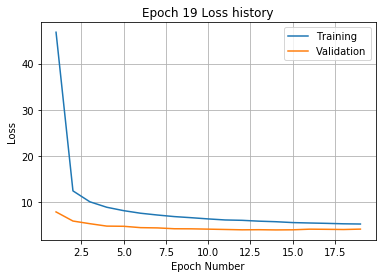

Validation error has stopped improving! Training on repetition 3 stopped!
Training
Iteration 0: with minibatch training loss = 159 and relative error of 1.4
Iteration 20: with minibatch training loss = 94.9 and relative error of 1.1
Iteration 40: with minibatch training loss = 64.6 and relative error of 0.91
Iteration 60: with minibatch training loss = 41.7 and relative error of 0.78
Iteration 80: with minibatch training loss = 34.9 and relative error of 0.67
Iteration 100: with minibatch training loss = 30.4 and relative error of 0.65
Iteration 120: with minibatch training loss = 23.9 and relative error of 0.57
Iteration 140: with minibatch training loss = 18.5 and relative error of 0.5
Iteration 160: with minibatch training loss = 19.8 and relative error of 0.5
Iteration 180: with minibatch training loss = 14.8 and relative error of 0.47
Iteration 200: with minibatch training loss = 14.5 and relative error of 0.43
Iteration 220: with minibatch training loss = 12.1 and relative error 

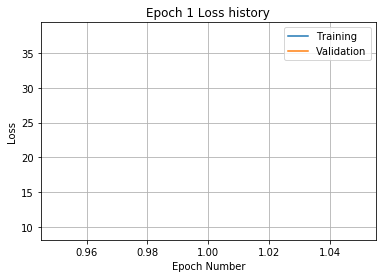

Training
Iteration 0: with minibatch training loss = 14.2 and relative error of 0.44
Iteration 20: with minibatch training loss = 14.9 and relative error of 0.44
Iteration 40: with minibatch training loss = 9.62 and relative error of 0.36
Iteration 60: with minibatch training loss = 11.8 and relative error of 0.4
Iteration 80: with minibatch training loss = 10.3 and relative error of 0.38
Iteration 100: with minibatch training loss = 14.1 and relative error of 0.43
Iteration 120: with minibatch training loss = 11.5 and relative error of 0.41
Iteration 140: with minibatch training loss = 10.1 and relative error of 0.35
Iteration 160: with minibatch training loss = 9.86 and relative error of 0.36
Iteration 180: with minibatch training loss = 9 and relative error of 0.34
Iteration 200: with minibatch training loss = 12.4 and relative error of 0.4
Iteration 220: with minibatch training loss = 11.4 and relative error of 0.4
Epoch 2, Overall loss = 11.7, relative error = 0.392, and process t

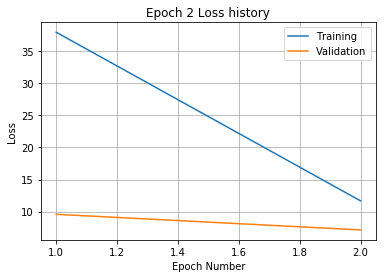

Training
Iteration 0: with minibatch training loss = 12.1 and relative error of 0.4
Iteration 20: with minibatch training loss = 9.57 and relative error of 0.36
Iteration 40: with minibatch training loss = 7.88 and relative error of 0.33
Iteration 60: with minibatch training loss = 8.02 and relative error of 0.33
Iteration 80: with minibatch training loss = 11 and relative error of 0.38
Iteration 100: with minibatch training loss = 9.04 and relative error of 0.33
Iteration 120: with minibatch training loss = 8.77 and relative error of 0.34
Iteration 140: with minibatch training loss = 6.28 and relative error of 0.29
Iteration 160: with minibatch training loss = 10.7 and relative error of 0.37
Iteration 180: with minibatch training loss = 7.56 and relative error of 0.32
Iteration 200: with minibatch training loss = 8.24 and relative error of 0.32
Iteration 220: with minibatch training loss = 9.26 and relative error of 0.36
Epoch 3, Overall loss = 9.62, relative error = 0.355, and proces

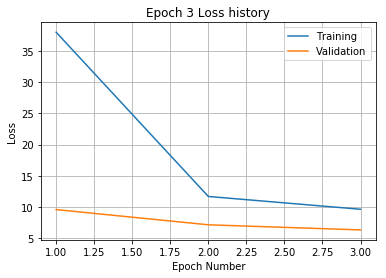

Training
Iteration 0: with minibatch training loss = 7.31 and relative error of 0.31
Iteration 20: with minibatch training loss = 6.5 and relative error of 0.3
Iteration 40: with minibatch training loss = 8.47 and relative error of 0.34
Iteration 60: with minibatch training loss = 8.56 and relative error of 0.34
Iteration 80: with minibatch training loss = 9.73 and relative error of 0.36
Iteration 100: with minibatch training loss = 7.84 and relative error of 0.32
Iteration 120: with minibatch training loss = 8.78 and relative error of 0.34
Iteration 140: with minibatch training loss = 8.08 and relative error of 0.33
Iteration 160: with minibatch training loss = 9.46 and relative error of 0.35
Iteration 180: with minibatch training loss = 8.6 and relative error of 0.32
Iteration 200: with minibatch training loss = 8.91 and relative error of 0.33
Iteration 220: with minibatch training loss = 9.27 and relative error of 0.34
Epoch 4, Overall loss = 8.49, relative error = 0.334, and proces

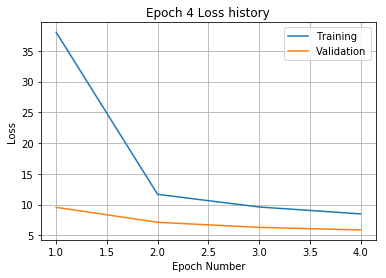

Training
Iteration 0: with minibatch training loss = 12.2 and relative error of 0.41
Iteration 20: with minibatch training loss = 6.77 and relative error of 0.29
Iteration 40: with minibatch training loss = 6.78 and relative error of 0.29
Iteration 60: with minibatch training loss = 8.5 and relative error of 0.33
Iteration 80: with minibatch training loss = 6.23 and relative error of 0.28
Iteration 100: with minibatch training loss = 7.4 and relative error of 0.31
Iteration 120: with minibatch training loss = 12.7 and relative error of 0.41
Iteration 140: with minibatch training loss = 8.69 and relative error of 0.35
Iteration 160: with minibatch training loss = 10.9 and relative error of 0.38
Iteration 180: with minibatch training loss = 5.51 and relative error of 0.28
Iteration 200: with minibatch training loss = 6.63 and relative error of 0.29
Iteration 220: with minibatch training loss = 7.08 and relative error of 0.3
Epoch 5, Overall loss = 7.75, relative error = 0.319, and proces

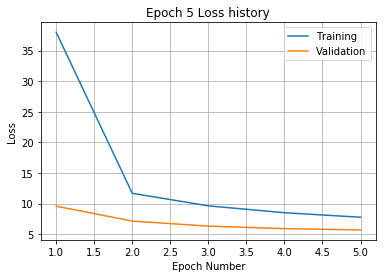

Training
Iteration 0: with minibatch training loss = 10.1 and relative error of 0.37
Iteration 20: with minibatch training loss = 7.1 and relative error of 0.3
Iteration 40: with minibatch training loss = 6.4 and relative error of 0.28
Iteration 60: with minibatch training loss = 9.28 and relative error of 0.35
Iteration 80: with minibatch training loss = 8.84 and relative error of 0.34
Iteration 100: with minibatch training loss = 8.55 and relative error of 0.33
Iteration 120: with minibatch training loss = 8.39 and relative error of 0.33
Iteration 140: with minibatch training loss = 6.1 and relative error of 0.29
Iteration 160: with minibatch training loss = 7.41 and relative error of 0.32
Iteration 180: with minibatch training loss = 9.06 and relative error of 0.36
Iteration 200: with minibatch training loss = 8.64 and relative error of 0.33
Iteration 220: with minibatch training loss = 6.6 and relative error of 0.29
Epoch 6, Overall loss = 7.31, relative error = 0.31, and process t

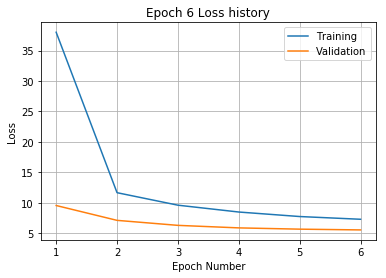

Training
Iteration 0: with minibatch training loss = 6.74 and relative error of 0.29
Iteration 20: with minibatch training loss = 6.57 and relative error of 0.29
Iteration 40: with minibatch training loss = 7.24 and relative error of 0.31
Iteration 60: with minibatch training loss = 7.96 and relative error of 0.32
Iteration 80: with minibatch training loss = 6.73 and relative error of 0.29
Iteration 100: with minibatch training loss = 7.24 and relative error of 0.31
Iteration 120: with minibatch training loss = 7.32 and relative error of 0.31
Iteration 140: with minibatch training loss = 6.75 and relative error of 0.3
Iteration 160: with minibatch training loss = 8.33 and relative error of 0.33
Iteration 180: with minibatch training loss = 5.17 and relative error of 0.26
Iteration 200: with minibatch training loss = 7.99 and relative error of 0.32
Iteration 220: with minibatch training loss = 5.24 and relative error of 0.26
Epoch 7, Overall loss = 6.92, relative error = 0.301, and proc

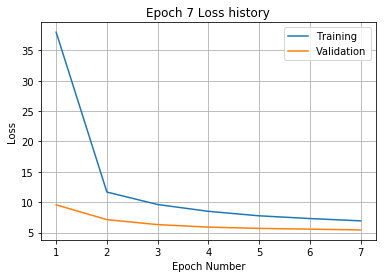

Training
Iteration 0: with minibatch training loss = 8.01 and relative error of 0.33
Iteration 20: with minibatch training loss = 4.89 and relative error of 0.25
Iteration 40: with minibatch training loss = 5.2 and relative error of 0.26
Iteration 60: with minibatch training loss = 8.65 and relative error of 0.34
Iteration 80: with minibatch training loss = 8.65 and relative error of 0.33
Iteration 100: with minibatch training loss = 6.17 and relative error of 0.28
Iteration 120: with minibatch training loss = 8.89 and relative error of 0.32
Iteration 140: with minibatch training loss = 6.78 and relative error of 0.31
Iteration 160: with minibatch training loss = 7.02 and relative error of 0.31
Iteration 180: with minibatch training loss = 6.85 and relative error of 0.31
Iteration 200: with minibatch training loss = 7.06 and relative error of 0.31
Iteration 220: with minibatch training loss = 5.94 and relative error of 0.29
Epoch 8, Overall loss = 6.57, relative error = 0.293, and proc

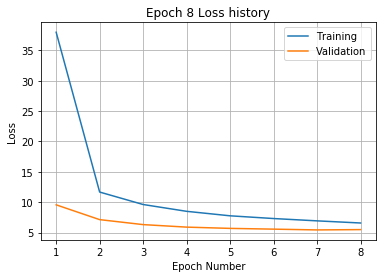

Training
Iteration 0: with minibatch training loss = 6.62 and relative error of 0.29
Iteration 20: with minibatch training loss = 7.44 and relative error of 0.32
Iteration 40: with minibatch training loss = 7.65 and relative error of 0.32
Iteration 60: with minibatch training loss = 7.54 and relative error of 0.32
Iteration 80: with minibatch training loss = 5.86 and relative error of 0.27
Iteration 100: with minibatch training loss = 5.63 and relative error of 0.27
Iteration 120: with minibatch training loss = 5.7 and relative error of 0.28
Iteration 140: with minibatch training loss = 7.39 and relative error of 0.32
Iteration 160: with minibatch training loss = 5.01 and relative error of 0.26
Iteration 180: with minibatch training loss = 6.09 and relative error of 0.29
Iteration 200: with minibatch training loss = 5.23 and relative error of 0.26
Iteration 220: with minibatch training loss = 7.21 and relative error of 0.31
Epoch 9, Overall loss = 6.31, relative error = 0.287, and proc

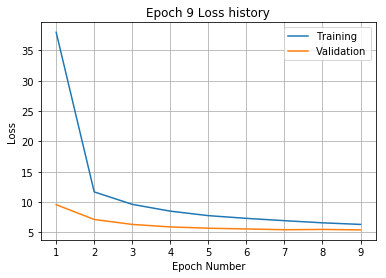

Training
Iteration 0: with minibatch training loss = 4.9 and relative error of 0.26
Iteration 20: with minibatch training loss = 7.05 and relative error of 0.3
Iteration 40: with minibatch training loss = 7.34 and relative error of 0.31
Iteration 60: with minibatch training loss = 6.19 and relative error of 0.29
Iteration 80: with minibatch training loss = 5.45 and relative error of 0.26
Iteration 100: with minibatch training loss = 5.21 and relative error of 0.27
Iteration 120: with minibatch training loss = 5.25 and relative error of 0.26
Iteration 140: with minibatch training loss = 7.8 and relative error of 0.32
Iteration 160: with minibatch training loss = 4.38 and relative error of 0.24
Iteration 180: with minibatch training loss = 6.13 and relative error of 0.29
Iteration 200: with minibatch training loss = 6.52 and relative error of 0.29
Iteration 220: with minibatch training loss = 5.01 and relative error of 0.26
Epoch 10, Overall loss = 6.16, relative error = 0.284, and proce

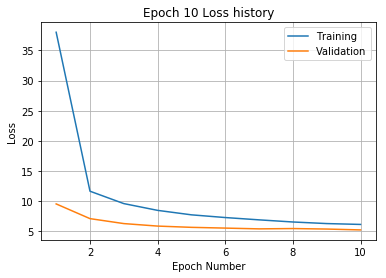

Training
Iteration 0: with minibatch training loss = 7.8 and relative error of 0.32
Iteration 20: with minibatch training loss = 5.73 and relative error of 0.27
Iteration 40: with minibatch training loss = 7.35 and relative error of 0.31
Iteration 60: with minibatch training loss = 6.22 and relative error of 0.29
Iteration 80: with minibatch training loss = 5.74 and relative error of 0.28
Iteration 100: with minibatch training loss = 6.46 and relative error of 0.29
Iteration 120: with minibatch training loss = 3.86 and relative error of 0.23
Iteration 140: with minibatch training loss = 5.4 and relative error of 0.27
Iteration 160: with minibatch training loss = 5.98 and relative error of 0.28
Iteration 180: with minibatch training loss = 5.06 and relative error of 0.25
Iteration 200: with minibatch training loss = 5.71 and relative error of 0.28
Iteration 220: with minibatch training loss = 5.18 and relative error of 0.26
Epoch 11, Overall loss = 5.94, relative error = 0.279, and proc

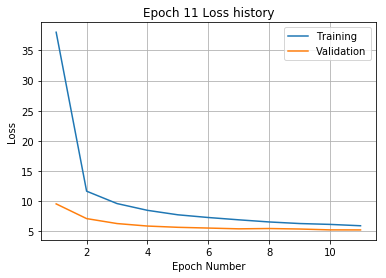

Training
Iteration 0: with minibatch training loss = 5.72 and relative error of 0.27
Iteration 20: with minibatch training loss = 6.45 and relative error of 0.3
Iteration 40: with minibatch training loss = 4.54 and relative error of 0.25
Iteration 60: with minibatch training loss = 4.91 and relative error of 0.25
Iteration 80: with minibatch training loss = 5.55 and relative error of 0.27
Iteration 100: with minibatch training loss = 4.47 and relative error of 0.25
Iteration 120: with minibatch training loss = 5.77 and relative error of 0.28
Iteration 140: with minibatch training loss = 4.77 and relative error of 0.25
Iteration 160: with minibatch training loss = 7.65 and relative error of 0.32
Iteration 180: with minibatch training loss = 5.63 and relative error of 0.27
Iteration 200: with minibatch training loss = 7.06 and relative error of 0.3
Iteration 220: with minibatch training loss = 6.7 and relative error of 0.29
Epoch 12, Overall loss = 5.79, relative error = 0.275, and proce

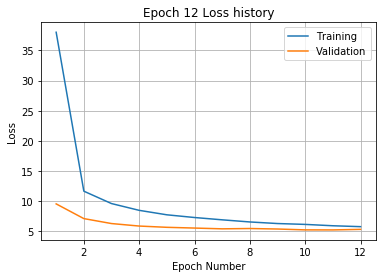

Training
Iteration 0: with minibatch training loss = 8.6 and relative error of 0.33
Iteration 20: with minibatch training loss = 4.67 and relative error of 0.24
Iteration 40: with minibatch training loss = 5.94 and relative error of 0.27
Iteration 60: with minibatch training loss = 5.46 and relative error of 0.27
Iteration 80: with minibatch training loss = 7.7 and relative error of 0.32
Iteration 100: with minibatch training loss = 4.29 and relative error of 0.24
Iteration 120: with minibatch training loss = 7.09 and relative error of 0.32
Iteration 140: with minibatch training loss = 6.33 and relative error of 0.29
Iteration 160: with minibatch training loss = 4.95 and relative error of 0.25
Iteration 180: with minibatch training loss = 4.33 and relative error of 0.24
Iteration 200: with minibatch training loss = 7.98 and relative error of 0.32
Iteration 220: with minibatch training loss = 6.03 and relative error of 0.27
Epoch 13, Overall loss = 5.64, relative error = 0.272, and proc

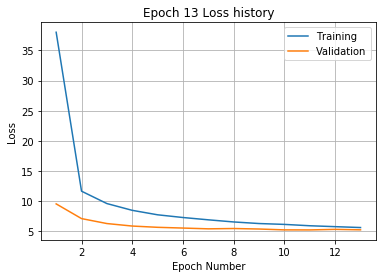

Training
Iteration 0: with minibatch training loss = 5.12 and relative error of 0.26
Iteration 20: with minibatch training loss = 4.75 and relative error of 0.25
Iteration 40: with minibatch training loss = 6.47 and relative error of 0.3
Iteration 60: with minibatch training loss = 4.47 and relative error of 0.25
Iteration 80: with minibatch training loss = 6.19 and relative error of 0.28
Iteration 100: with minibatch training loss = 6.64 and relative error of 0.29
Iteration 120: with minibatch training loss = 5.89 and relative error of 0.28
Iteration 140: with minibatch training loss = 5.36 and relative error of 0.27
Iteration 160: with minibatch training loss = 4.66 and relative error of 0.24
Iteration 180: with minibatch training loss = 4.47 and relative error of 0.24
Iteration 200: with minibatch training loss = 5.07 and relative error of 0.25
Iteration 220: with minibatch training loss = 4.92 and relative error of 0.25
Epoch 14, Overall loss = 5.55, relative error = 0.27, and proc

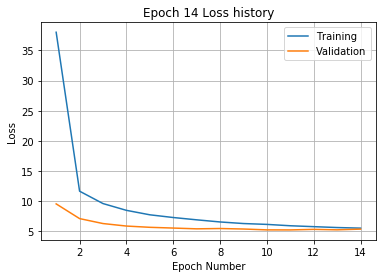

Training
Iteration 0: with minibatch training loss = 5.62 and relative error of 0.27
Iteration 20: with minibatch training loss = 5.94 and relative error of 0.28
Iteration 40: with minibatch training loss = 6.02 and relative error of 0.28
Iteration 60: with minibatch training loss = 6.06 and relative error of 0.29
Iteration 80: with minibatch training loss = 6.44 and relative error of 0.28
Iteration 100: with minibatch training loss = 5.35 and relative error of 0.27
Iteration 120: with minibatch training loss = 5.06 and relative error of 0.26
Iteration 140: with minibatch training loss = 6.09 and relative error of 0.28
Iteration 160: with minibatch training loss = 5.29 and relative error of 0.26
Iteration 180: with minibatch training loss = 3.48 and relative error of 0.22
Iteration 200: with minibatch training loss = 7.28 and relative error of 0.31
Iteration 220: with minibatch training loss = 4.86 and relative error of 0.25
Epoch 15, Overall loss = 5.39, relative error = 0.266, and pr

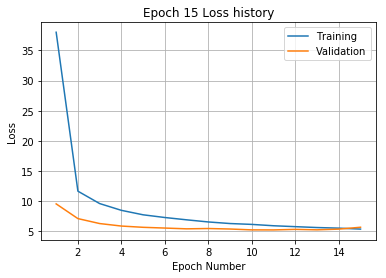

Training
Iteration 0: with minibatch training loss = 5.49 and relative error of 0.27
Iteration 20: with minibatch training loss = 5.8 and relative error of 0.27
Iteration 40: with minibatch training loss = 4.29 and relative error of 0.24
Iteration 60: with minibatch training loss = 5.06 and relative error of 0.25
Iteration 80: with minibatch training loss = 3.52 and relative error of 0.21
Iteration 100: with minibatch training loss = 4.25 and relative error of 0.23
Iteration 120: with minibatch training loss = 6.25 and relative error of 0.28
Iteration 140: with minibatch training loss = 5.51 and relative error of 0.27
Iteration 160: with minibatch training loss = 6.3 and relative error of 0.29
Iteration 180: with minibatch training loss = 5.44 and relative error of 0.26
Iteration 200: with minibatch training loss = 5.61 and relative error of 0.27
Iteration 220: with minibatch training loss = 5.19 and relative error of 0.27
Epoch 16, Overall loss = 5.29, relative error = 0.263, and proc

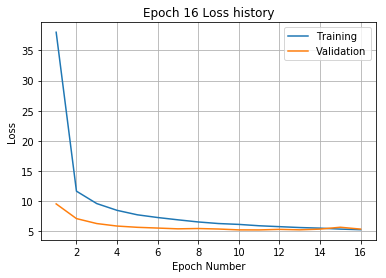

Validation error has stopped improving! Training on repetition 4 stopped!
Training
Iteration 0: with minibatch training loss = 156 and relative error of 1.4
Iteration 20: with minibatch training loss = 96 and relative error of 1.1
Iteration 40: with minibatch training loss = 65.1 and relative error of 0.96
Iteration 60: with minibatch training loss = 53.1 and relative error of 0.83
Iteration 80: with minibatch training loss = 38.4 and relative error of 0.71
Iteration 100: with minibatch training loss = 27.7 and relative error of 0.61
Iteration 120: with minibatch training loss = 24.2 and relative error of 0.56
Iteration 140: with minibatch training loss = 22 and relative error of 0.56
Iteration 160: with minibatch training loss = 16 and relative error of 0.47
Iteration 180: with minibatch training loss = 17.9 and relative error of 0.48
Iteration 200: with minibatch training loss = 12 and relative error of 0.4
Iteration 220: with minibatch training loss = 12.8 and relative error of 0.41

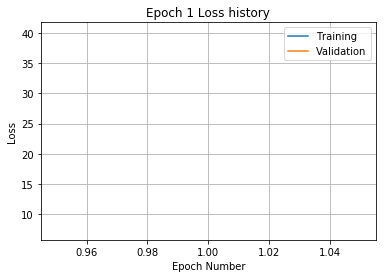

Training
Iteration 0: with minibatch training loss = 12.2 and relative error of 0.39
Iteration 20: with minibatch training loss = 14.3 and relative error of 0.44
Iteration 40: with minibatch training loss = 13.5 and relative error of 0.42
Iteration 60: with minibatch training loss = 16.8 and relative error of 0.46
Iteration 80: with minibatch training loss = 11.5 and relative error of 0.39
Iteration 100: with minibatch training loss = 13.2 and relative error of 0.42
Iteration 120: with minibatch training loss = 12.5 and relative error of 0.41
Iteration 140: with minibatch training loss = 10.9 and relative error of 0.37
Iteration 160: with minibatch training loss = 10.7 and relative error of 0.38
Iteration 180: with minibatch training loss = 9.92 and relative error of 0.35
Iteration 200: with minibatch training loss = 9.83 and relative error of 0.37
Iteration 220: with minibatch training loss = 10.5 and relative error of 0.39
Epoch 2, Overall loss = 12.2, relative error = 0.399, and pro

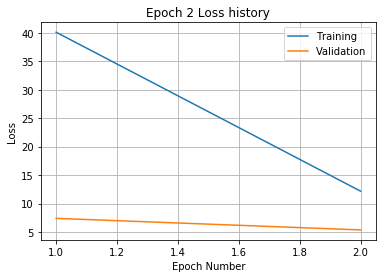

Training
Iteration 0: with minibatch training loss = 9.96 and relative error of 0.36
Iteration 20: with minibatch training loss = 9.64 and relative error of 0.35
Iteration 40: with minibatch training loss = 9.37 and relative error of 0.34
Iteration 60: with minibatch training loss = 8.71 and relative error of 0.35
Iteration 80: with minibatch training loss = 9.8 and relative error of 0.37
Iteration 100: with minibatch training loss = 10.5 and relative error of 0.37
Iteration 120: with minibatch training loss = 7.81 and relative error of 0.32
Iteration 140: with minibatch training loss = 9.33 and relative error of 0.35
Iteration 160: with minibatch training loss = 11.9 and relative error of 0.42
Iteration 180: with minibatch training loss = 9.59 and relative error of 0.38
Iteration 200: with minibatch training loss = 11.4 and relative error of 0.37
Iteration 220: with minibatch training loss = 7.73 and relative error of 0.32
Epoch 3, Overall loss = 9.86, relative error = 0.359, and proc

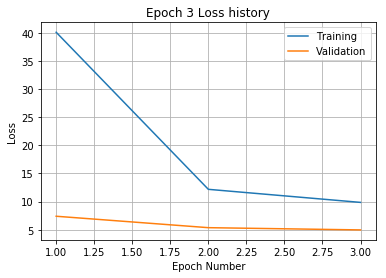

Training
Iteration 0: with minibatch training loss = 7.77 and relative error of 0.33
Iteration 20: with minibatch training loss = 11.7 and relative error of 0.39
Iteration 40: with minibatch training loss = 7.31 and relative error of 0.32
Iteration 60: with minibatch training loss = 7.42 and relative error of 0.31
Iteration 80: with minibatch training loss = 6.93 and relative error of 0.31
Iteration 100: with minibatch training loss = 10 and relative error of 0.37
Iteration 120: with minibatch training loss = 9.14 and relative error of 0.34
Iteration 140: with minibatch training loss = 7.79 and relative error of 0.32
Iteration 160: with minibatch training loss = 8.85 and relative error of 0.35
Iteration 180: with minibatch training loss = 8.53 and relative error of 0.34
Iteration 200: with minibatch training loss = 8.23 and relative error of 0.34
Iteration 220: with minibatch training loss = 6.06 and relative error of 0.27
Epoch 4, Overall loss = 8.65, relative error = 0.336, and proce

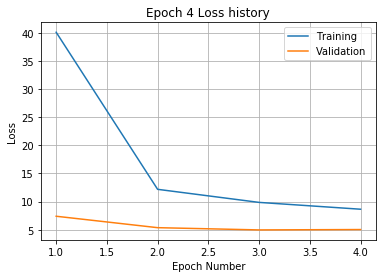

Training
Iteration 0: with minibatch training loss = 8.21 and relative error of 0.33
Iteration 20: with minibatch training loss = 6.5 and relative error of 0.28
Iteration 40: with minibatch training loss = 8.28 and relative error of 0.33
Iteration 60: with minibatch training loss = 11.1 and relative error of 0.39
Iteration 80: with minibatch training loss = 7.13 and relative error of 0.31
Iteration 100: with minibatch training loss = 8.41 and relative error of 0.33
Iteration 120: with minibatch training loss = 7.69 and relative error of 0.32
Iteration 140: with minibatch training loss = 7.97 and relative error of 0.32
Iteration 160: with minibatch training loss = 6.79 and relative error of 0.29
Iteration 180: with minibatch training loss = 5.87 and relative error of 0.3
Iteration 200: with minibatch training loss = 7.24 and relative error of 0.32
Iteration 220: with minibatch training loss = 9.61 and relative error of 0.35
Epoch 5, Overall loss = 7.98, relative error = 0.322, and proce

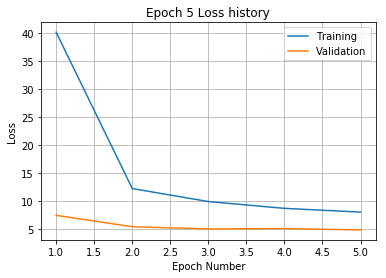

Training
Iteration 0: with minibatch training loss = 5.76 and relative error of 0.28
Iteration 20: with minibatch training loss = 6.59 and relative error of 0.3
Iteration 40: with minibatch training loss = 6.77 and relative error of 0.3
Iteration 60: with minibatch training loss = 7.5 and relative error of 0.31
Iteration 80: with minibatch training loss = 9.52 and relative error of 0.36
Iteration 100: with minibatch training loss = 6.04 and relative error of 0.29
Iteration 120: with minibatch training loss = 5.84 and relative error of 0.28
Iteration 140: with minibatch training loss = 9.54 and relative error of 0.34
Iteration 160: with minibatch training loss = 8.75 and relative error of 0.34
Iteration 180: with minibatch training loss = 6.88 and relative error of 0.29
Iteration 200: with minibatch training loss = 8.82 and relative error of 0.35
Iteration 220: with minibatch training loss = 8.2 and relative error of 0.33
Epoch 6, Overall loss = 7.46, relative error = 0.312, and process

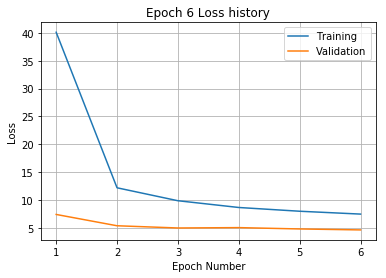

Training
Iteration 0: with minibatch training loss = 8.33 and relative error of 0.34
Iteration 20: with minibatch training loss = 7.77 and relative error of 0.32
Iteration 40: with minibatch training loss = 6.79 and relative error of 0.29
Iteration 60: with minibatch training loss = 9.13 and relative error of 0.35
Iteration 80: with minibatch training loss = 7.72 and relative error of 0.32
Iteration 100: with minibatch training loss = 4.93 and relative error of 0.26
Iteration 120: with minibatch training loss = 7.72 and relative error of 0.31
Iteration 140: with minibatch training loss = 8.16 and relative error of 0.33
Iteration 160: with minibatch training loss = 5.79 and relative error of 0.27
Iteration 180: with minibatch training loss = 9.59 and relative error of 0.34
Iteration 200: with minibatch training loss = 8.36 and relative error of 0.33
Iteration 220: with minibatch training loss = 8.67 and relative error of 0.34
Epoch 7, Overall loss = 7.04, relative error = 0.303, and pro

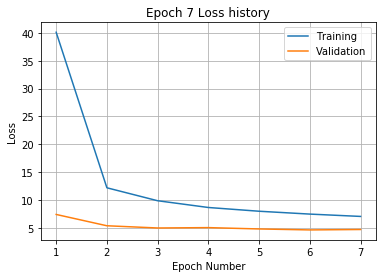

Training
Iteration 0: with minibatch training loss = 5.51 and relative error of 0.28
Iteration 20: with minibatch training loss = 6.24 and relative error of 0.29
Iteration 40: with minibatch training loss = 7.15 and relative error of 0.32
Iteration 60: with minibatch training loss = 5.07 and relative error of 0.26
Iteration 80: with minibatch training loss = 5.31 and relative error of 0.27
Iteration 100: with minibatch training loss = 6.26 and relative error of 0.29
Iteration 120: with minibatch training loss = 5.21 and relative error of 0.27
Iteration 140: with minibatch training loss = 6.44 and relative error of 0.3
Iteration 160: with minibatch training loss = 7.91 and relative error of 0.33
Iteration 180: with minibatch training loss = 7.03 and relative error of 0.3
Iteration 200: with minibatch training loss = 6.66 and relative error of 0.29
Iteration 220: with minibatch training loss = 7.48 and relative error of 0.3
Epoch 8, Overall loss = 6.72, relative error = 0.296, and proces

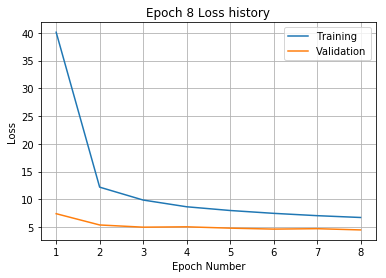

Training
Iteration 0: with minibatch training loss = 5.63 and relative error of 0.28
Iteration 20: with minibatch training loss = 4.91 and relative error of 0.26
Iteration 40: with minibatch training loss = 6.1 and relative error of 0.28
Iteration 60: with minibatch training loss = 5.96 and relative error of 0.28
Iteration 80: with minibatch training loss = 6.49 and relative error of 0.3
Iteration 100: with minibatch training loss = 5.63 and relative error of 0.26
Iteration 120: with minibatch training loss = 5.4 and relative error of 0.26
Iteration 140: with minibatch training loss = 5.27 and relative error of 0.26
Iteration 160: with minibatch training loss = 4.62 and relative error of 0.24
Iteration 180: with minibatch training loss = 5.71 and relative error of 0.28
Iteration 200: with minibatch training loss = 5.86 and relative error of 0.27
Iteration 220: with minibatch training loss = 9.65 and relative error of 0.35
Epoch 9, Overall loss = 6.43, relative error = 0.29, and process

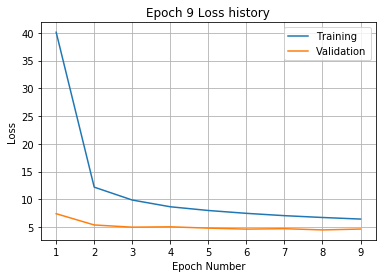

Training
Iteration 0: with minibatch training loss = 6.58 and relative error of 0.3
Iteration 20: with minibatch training loss = 4.61 and relative error of 0.24
Iteration 40: with minibatch training loss = 6.61 and relative error of 0.3
Iteration 60: with minibatch training loss = 6.83 and relative error of 0.3
Iteration 80: with minibatch training loss = 6.4 and relative error of 0.28
Iteration 100: with minibatch training loss = 6.59 and relative error of 0.3
Iteration 120: with minibatch training loss = 4.95 and relative error of 0.25
Iteration 140: with minibatch training loss = 5.23 and relative error of 0.26
Iteration 160: with minibatch training loss = 8.04 and relative error of 0.32
Iteration 180: with minibatch training loss = 6.63 and relative error of 0.31
Iteration 200: with minibatch training loss = 5.19 and relative error of 0.25
Iteration 220: with minibatch training loss = 7.47 and relative error of 0.31
Epoch 10, Overall loss = 6.31, relative error = 0.286, and process

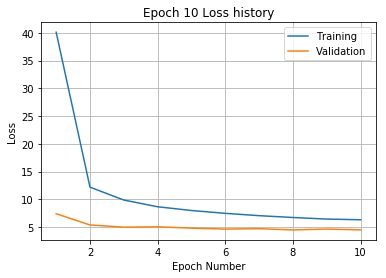

Training
Iteration 0: with minibatch training loss = 7 and relative error of 0.3
Iteration 20: with minibatch training loss = 7.48 and relative error of 0.31
Iteration 40: with minibatch training loss = 5.27 and relative error of 0.26
Iteration 60: with minibatch training loss = 5.66 and relative error of 0.27
Iteration 80: with minibatch training loss = 5.33 and relative error of 0.26
Iteration 100: with minibatch training loss = 5.58 and relative error of 0.27
Iteration 120: with minibatch training loss = 6.91 and relative error of 0.3
Iteration 140: with minibatch training loss = 5.47 and relative error of 0.26
Iteration 160: with minibatch training loss = 6.17 and relative error of 0.28
Iteration 180: with minibatch training loss = 6.18 and relative error of 0.28
Iteration 200: with minibatch training loss = 5.38 and relative error of 0.27
Iteration 220: with minibatch training loss = 5.51 and relative error of 0.26
Epoch 11, Overall loss = 6.13, relative error = 0.282, and process

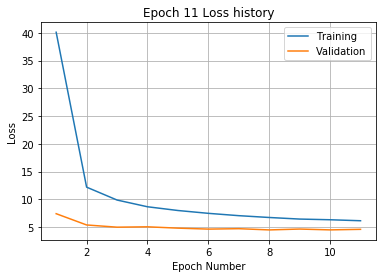

Training
Iteration 0: with minibatch training loss = 4.22 and relative error of 0.24
Iteration 20: with minibatch training loss = 6.54 and relative error of 0.29
Iteration 40: with minibatch training loss = 6.73 and relative error of 0.29
Iteration 60: with minibatch training loss = 8.49 and relative error of 0.32
Iteration 80: with minibatch training loss = 7.86 and relative error of 0.32
Iteration 100: with minibatch training loss = 6.52 and relative error of 0.3
Iteration 120: with minibatch training loss = 5.08 and relative error of 0.26
Iteration 140: with minibatch training loss = 6.81 and relative error of 0.31
Iteration 160: with minibatch training loss = 8.21 and relative error of 0.34
Iteration 180: with minibatch training loss = 6.4 and relative error of 0.3
Iteration 200: with minibatch training loss = 4.87 and relative error of 0.25
Iteration 220: with minibatch training loss = 5.25 and relative error of 0.27
Epoch 12, Overall loss = 5.97, relative error = 0.279, and proce

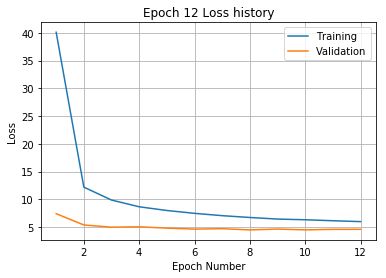

Training
Iteration 0: with minibatch training loss = 4.4 and relative error of 0.24
Iteration 20: with minibatch training loss = 7.42 and relative error of 0.32
Iteration 40: with minibatch training loss = 6 and relative error of 0.27
Iteration 60: with minibatch training loss = 5.45 and relative error of 0.26
Iteration 80: with minibatch training loss = 6.01 and relative error of 0.29
Iteration 100: with minibatch training loss = 6.27 and relative error of 0.29
Iteration 120: with minibatch training loss = 5.61 and relative error of 0.27
Iteration 140: with minibatch training loss = 6.6 and relative error of 0.29
Iteration 160: with minibatch training loss = 6.45 and relative error of 0.31
Iteration 180: with minibatch training loss = 7.1 and relative error of 0.32
Iteration 200: with minibatch training loss = 5.81 and relative error of 0.28
Iteration 220: with minibatch training loss = 5.81 and relative error of 0.27
Epoch 13, Overall loss = 5.83, relative error = 0.276, and process 

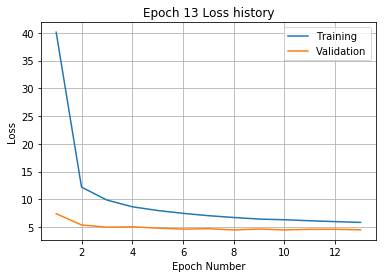

Validation error has stopped improving! Training on repetition 5 stopped!
Training
Iteration 0: with minibatch training loss = 210 and relative error of 1.6
Iteration 20: with minibatch training loss = 117 and relative error of 1.2
Iteration 40: with minibatch training loss = 76.2 and relative error of 1
Iteration 60: with minibatch training loss = 53.3 and relative error of 0.87
Iteration 80: with minibatch training loss = 41 and relative error of 0.75
Iteration 100: with minibatch training loss = 28 and relative error of 0.62
Iteration 120: with minibatch training loss = 22.9 and relative error of 0.57
Iteration 140: with minibatch training loss = 17.4 and relative error of 0.5
Iteration 160: with minibatch training loss = 20.4 and relative error of 0.51
Iteration 180: with minibatch training loss = 17.9 and relative error of 0.47
Iteration 200: with minibatch training loss = 14.3 and relative error of 0.43
Iteration 220: with minibatch training loss = 16.5 and relative error of 0.47

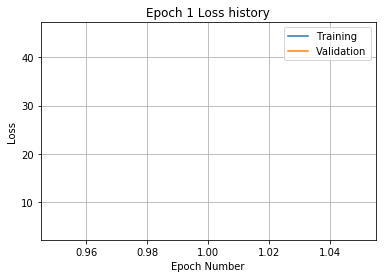

Training
Iteration 0: with minibatch training loss = 15.8 and relative error of 0.46
Iteration 20: with minibatch training loss = 12.9 and relative error of 0.41
Iteration 40: with minibatch training loss = 11.9 and relative error of 0.39
Iteration 60: with minibatch training loss = 12.7 and relative error of 0.41
Iteration 80: with minibatch training loss = 13.3 and relative error of 0.43
Iteration 100: with minibatch training loss = 10.9 and relative error of 0.39
Iteration 120: with minibatch training loss = 10.9 and relative error of 0.39
Iteration 140: with minibatch training loss = 14.7 and relative error of 0.43
Iteration 160: with minibatch training loss = 11 and relative error of 0.39
Iteration 180: with minibatch training loss = 9.66 and relative error of 0.36
Iteration 200: with minibatch training loss = 11.6 and relative error of 0.41
Iteration 220: with minibatch training loss = 11.6 and relative error of 0.38
Epoch 2, Overall loss = 12.4, relative error = 0.403, and proce

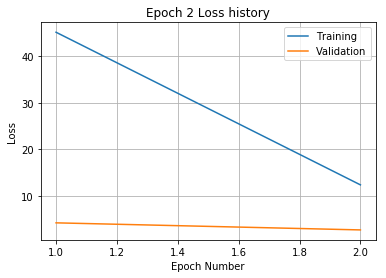

Training
Iteration 0: with minibatch training loss = 10.4 and relative error of 0.39
Iteration 20: with minibatch training loss = 15.3 and relative error of 0.43
Iteration 40: with minibatch training loss = 9.94 and relative error of 0.37
Iteration 60: with minibatch training loss = 12.3 and relative error of 0.4
Iteration 80: with minibatch training loss = 10.5 and relative error of 0.36
Iteration 100: with minibatch training loss = 7.69 and relative error of 0.32
Iteration 120: with minibatch training loss = 9.28 and relative error of 0.35
Iteration 140: with minibatch training loss = 11 and relative error of 0.38
Iteration 160: with minibatch training loss = 8.56 and relative error of 0.34
Iteration 180: with minibatch training loss = 12.1 and relative error of 0.41
Iteration 200: with minibatch training loss = 10.2 and relative error of 0.36
Iteration 220: with minibatch training loss = 8.5 and relative error of 0.33
Epoch 3, Overall loss = 9.94, relative error = 0.361, and process

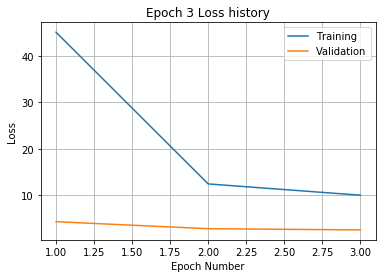

Training
Iteration 0: with minibatch training loss = 7.97 and relative error of 0.34
Iteration 20: with minibatch training loss = 8.94 and relative error of 0.34
Iteration 40: with minibatch training loss = 12 and relative error of 0.4
Iteration 60: with minibatch training loss = 7.09 and relative error of 0.3
Iteration 80: with minibatch training loss = 7.92 and relative error of 0.32
Iteration 100: with minibatch training loss = 8.83 and relative error of 0.34
Iteration 120: with minibatch training loss = 9.64 and relative error of 0.37
Iteration 140: with minibatch training loss = 10.6 and relative error of 0.38
Iteration 160: with minibatch training loss = 8.08 and relative error of 0.32
Iteration 180: with minibatch training loss = 7.45 and relative error of 0.31
Iteration 200: with minibatch training loss = 5.89 and relative error of 0.27
Iteration 220: with minibatch training loss = 8.68 and relative error of 0.33
Epoch 4, Overall loss = 8.81, relative error = 0.34, and process 

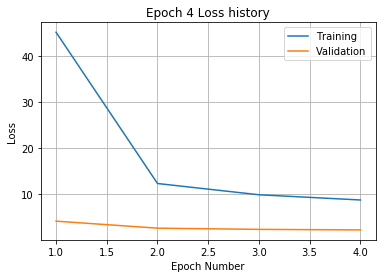

Training
Iteration 0: with minibatch training loss = 8.54 and relative error of 0.33
Iteration 20: with minibatch training loss = 7.91 and relative error of 0.34
Iteration 40: with minibatch training loss = 8.73 and relative error of 0.33
Iteration 60: with minibatch training loss = 6.53 and relative error of 0.3
Iteration 80: with minibatch training loss = 8.79 and relative error of 0.34
Iteration 100: with minibatch training loss = 6.66 and relative error of 0.3
Iteration 120: with minibatch training loss = 8.47 and relative error of 0.34
Iteration 140: with minibatch training loss = 6.8 and relative error of 0.29
Iteration 160: with minibatch training loss = 8.47 and relative error of 0.33
Iteration 180: with minibatch training loss = 7.9 and relative error of 0.31
Iteration 200: with minibatch training loss = 5.93 and relative error of 0.28
Iteration 220: with minibatch training loss = 8.91 and relative error of 0.35
Epoch 5, Overall loss = 8.08, relative error = 0.325, and process

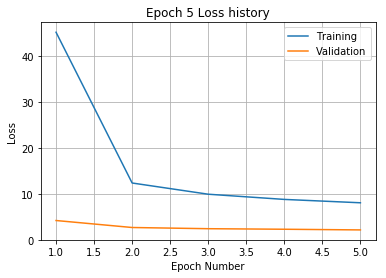

Training
Iteration 0: with minibatch training loss = 8 and relative error of 0.34
Iteration 20: with minibatch training loss = 7.89 and relative error of 0.32
Iteration 40: with minibatch training loss = 8.07 and relative error of 0.32
Iteration 60: with minibatch training loss = 7.63 and relative error of 0.31
Iteration 80: with minibatch training loss = 6.23 and relative error of 0.28
Iteration 100: with minibatch training loss = 7.59 and relative error of 0.32
Iteration 120: with minibatch training loss = 6.05 and relative error of 0.28
Iteration 140: with minibatch training loss = 6.49 and relative error of 0.29
Iteration 160: with minibatch training loss = 8.46 and relative error of 0.34
Iteration 180: with minibatch training loss = 6.37 and relative error of 0.31
Iteration 200: with minibatch training loss = 8.27 and relative error of 0.34
Iteration 220: with minibatch training loss = 7.2 and relative error of 0.31
Epoch 6, Overall loss = 7.55, relative error = 0.314, and process

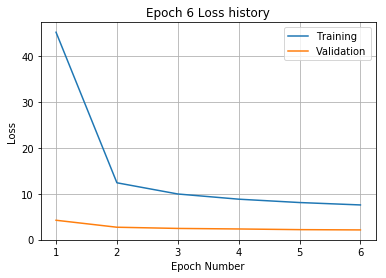

Training
Iteration 0: with minibatch training loss = 6.78 and relative error of 0.3
Iteration 20: with minibatch training loss = 7.65 and relative error of 0.32
Iteration 40: with minibatch training loss = 5.28 and relative error of 0.25
Iteration 60: with minibatch training loss = 7.07 and relative error of 0.3
Iteration 80: with minibatch training loss = 7.8 and relative error of 0.32
Iteration 100: with minibatch training loss = 8.18 and relative error of 0.35
Iteration 120: with minibatch training loss = 5.29 and relative error of 0.27
Iteration 140: with minibatch training loss = 7.24 and relative error of 0.31
Iteration 160: with minibatch training loss = 9.43 and relative error of 0.34
Iteration 180: with minibatch training loss = 6.71 and relative error of 0.29
Iteration 200: with minibatch training loss = 5.82 and relative error of 0.28
Iteration 220: with minibatch training loss = 7.11 and relative error of 0.31
Epoch 7, Overall loss = 7.18, relative error = 0.307, and proces

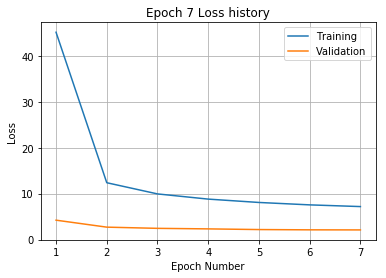

Training
Iteration 0: with minibatch training loss = 8.74 and relative error of 0.34
Iteration 20: with minibatch training loss = 6.2 and relative error of 0.3
Iteration 40: with minibatch training loss = 9.37 and relative error of 0.36
Iteration 60: with minibatch training loss = 6.7 and relative error of 0.29
Iteration 80: with minibatch training loss = 6.28 and relative error of 0.28
Iteration 100: with minibatch training loss = 5.55 and relative error of 0.28
Iteration 120: with minibatch training loss = 6.56 and relative error of 0.3
Iteration 140: with minibatch training loss = 6.45 and relative error of 0.29
Iteration 160: with minibatch training loss = 7.6 and relative error of 0.31
Iteration 180: with minibatch training loss = 4.94 and relative error of 0.25
Iteration 200: with minibatch training loss = 9.69 and relative error of 0.36
Iteration 220: with minibatch training loss = 8.46 and relative error of 0.33
Epoch 8, Overall loss = 6.89, relative error = 0.3, and process ti

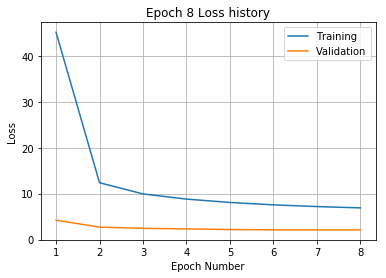

Training
Iteration 0: with minibatch training loss = 5.73 and relative error of 0.27
Iteration 20: with minibatch training loss = 5.63 and relative error of 0.28
Iteration 40: with minibatch training loss = 6.01 and relative error of 0.28
Iteration 60: with minibatch training loss = 5.71 and relative error of 0.27
Iteration 80: with minibatch training loss = 7.34 and relative error of 0.32
Iteration 100: with minibatch training loss = 6.59 and relative error of 0.29
Iteration 120: with minibatch training loss = 6.26 and relative error of 0.28
Iteration 140: with minibatch training loss = 6.71 and relative error of 0.29
Iteration 160: with minibatch training loss = 6.16 and relative error of 0.28
Iteration 180: with minibatch training loss = 6.3 and relative error of 0.28
Iteration 200: with minibatch training loss = 4.43 and relative error of 0.24
Iteration 220: with minibatch training loss = 5.61 and relative error of 0.26
Epoch 9, Overall loss = 6.6, relative error = 0.294, and proce

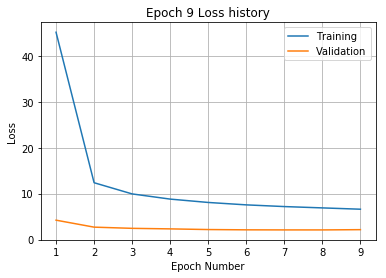

Training
Iteration 0: with minibatch training loss = 5.34 and relative error of 0.26
Iteration 20: with minibatch training loss = 4.7 and relative error of 0.25
Iteration 40: with minibatch training loss = 5.27 and relative error of 0.26
Iteration 60: with minibatch training loss = 5.82 and relative error of 0.28
Iteration 80: with minibatch training loss = 7.3 and relative error of 0.31
Iteration 100: with minibatch training loss = 8.71 and relative error of 0.35
Iteration 120: with minibatch training loss = 6.91 and relative error of 0.3
Iteration 140: with minibatch training loss = 7.54 and relative error of 0.32
Iteration 160: with minibatch training loss = 6.39 and relative error of 0.28
Iteration 180: with minibatch training loss = 6.32 and relative error of 0.29
Iteration 200: with minibatch training loss = 4.76 and relative error of 0.24
Iteration 220: with minibatch training loss = 8.58 and relative error of 0.34
Epoch 10, Overall loss = 6.41, relative error = 0.29, and proces

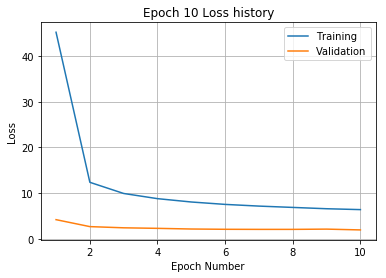

Training
Iteration 0: with minibatch training loss = 4.25 and relative error of 0.23
Iteration 20: with minibatch training loss = 6.65 and relative error of 0.29
Iteration 40: with minibatch training loss = 4.52 and relative error of 0.25
Iteration 60: with minibatch training loss = 5.46 and relative error of 0.26
Iteration 80: with minibatch training loss = 5.21 and relative error of 0.27
Iteration 100: with minibatch training loss = 6.5 and relative error of 0.3
Iteration 120: with minibatch training loss = 6.29 and relative error of 0.28
Iteration 140: with minibatch training loss = 6.33 and relative error of 0.28
Iteration 160: with minibatch training loss = 5.9 and relative error of 0.28
Iteration 180: with minibatch training loss = 5.83 and relative error of 0.28
Iteration 200: with minibatch training loss = 6.05 and relative error of 0.28
Iteration 220: with minibatch training loss = 6.13 and relative error of 0.28
Epoch 11, Overall loss = 6.2, relative error = 0.285, and proces

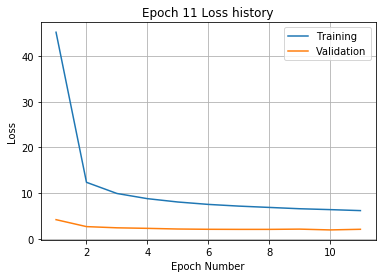

Training
Iteration 0: with minibatch training loss = 5.9 and relative error of 0.28
Iteration 20: with minibatch training loss = 6.72 and relative error of 0.3
Iteration 40: with minibatch training loss = 5.93 and relative error of 0.28
Iteration 60: with minibatch training loss = 6.21 and relative error of 0.3
Iteration 80: with minibatch training loss = 4.12 and relative error of 0.23
Iteration 100: with minibatch training loss = 5.02 and relative error of 0.26
Iteration 120: with minibatch training loss = 6.56 and relative error of 0.28
Iteration 140: with minibatch training loss = 6.75 and relative error of 0.31
Iteration 160: with minibatch training loss = 7.25 and relative error of 0.3
Iteration 180: with minibatch training loss = 5.48 and relative error of 0.27
Iteration 200: with minibatch training loss = 4.87 and relative error of 0.25
Iteration 220: with minibatch training loss = 5.33 and relative error of 0.27
Epoch 12, Overall loss = 6.09, relative error = 0.282, and proces

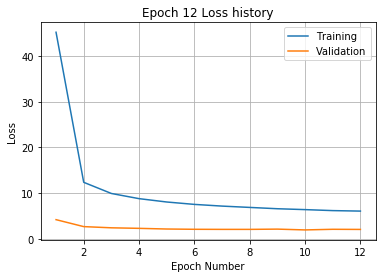

Training
Iteration 0: with minibatch training loss = 5.29 and relative error of 0.27
Iteration 20: with minibatch training loss = 8.57 and relative error of 0.35
Iteration 40: with minibatch training loss = 10.6 and relative error of 0.38
Iteration 60: with minibatch training loss = 5.66 and relative error of 0.28
Iteration 80: with minibatch training loss = 5.07 and relative error of 0.26
Iteration 100: with minibatch training loss = 4.68 and relative error of 0.25
Iteration 120: with minibatch training loss = 8.43 and relative error of 0.34
Iteration 140: with minibatch training loss = 5.14 and relative error of 0.27
Iteration 160: with minibatch training loss = 4.87 and relative error of 0.25
Iteration 180: with minibatch training loss = 3.94 and relative error of 0.22
Iteration 200: with minibatch training loss = 4.14 and relative error of 0.23
Iteration 220: with minibatch training loss = 5.23 and relative error of 0.26
Epoch 13, Overall loss = 5.93, relative error = 0.278, and pr

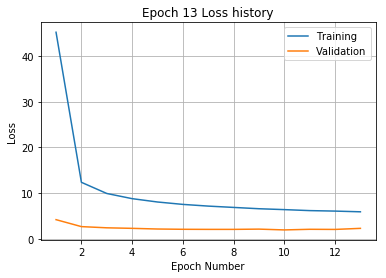

Training
Iteration 0: with minibatch training loss = 6.42 and relative error of 0.3
Iteration 20: with minibatch training loss = 5.03 and relative error of 0.26
Iteration 40: with minibatch training loss = 5.73 and relative error of 0.27
Iteration 60: with minibatch training loss = 6.5 and relative error of 0.29
Iteration 80: with minibatch training loss = 4.65 and relative error of 0.24
Iteration 100: with minibatch training loss = 5.71 and relative error of 0.27
Iteration 120: with minibatch training loss = 8.3 and relative error of 0.33
Iteration 140: with minibatch training loss = 6.68 and relative error of 0.29
Iteration 160: with minibatch training loss = 5.57 and relative error of 0.28
Iteration 180: with minibatch training loss = 6.24 and relative error of 0.28
Iteration 200: with minibatch training loss = 5.16 and relative error of 0.27
Iteration 220: with minibatch training loss = 8.24 and relative error of 0.34
Epoch 14, Overall loss = 5.8, relative error = 0.275, and proces

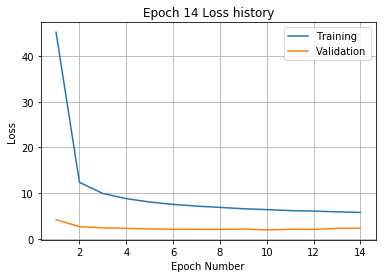

Training
Iteration 0: with minibatch training loss = 5.43 and relative error of 0.26
Iteration 20: with minibatch training loss = 6.68 and relative error of 0.3
Iteration 40: with minibatch training loss = 5.75 and relative error of 0.28
Iteration 60: with minibatch training loss = 7.36 and relative error of 0.32
Iteration 80: with minibatch training loss = 6.13 and relative error of 0.28
Iteration 100: with minibatch training loss = 3.53 and relative error of 0.21
Iteration 120: with minibatch training loss = 4.37 and relative error of 0.25
Iteration 140: with minibatch training loss = 6.62 and relative error of 0.29
Iteration 160: with minibatch training loss = 5.62 and relative error of 0.27
Iteration 180: with minibatch training loss = 5.9 and relative error of 0.29
Iteration 200: with minibatch training loss = 5.38 and relative error of 0.27
Iteration 220: with minibatch training loss = 4.35 and relative error of 0.24
Epoch 15, Overall loss = 5.67, relative error = 0.272, and proc

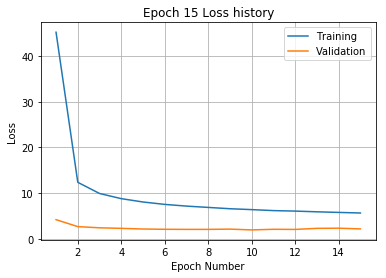

Validation error has stopped improving! Training on repetition 6 stopped!
Training
Iteration 0: with minibatch training loss = 176 and relative error of 1.5
Iteration 20: with minibatch training loss = 106 and relative error of 1.2
Iteration 40: with minibatch training loss = 63.9 and relative error of 0.9
Iteration 60: with minibatch training loss = 43.7 and relative error of 0.74
Iteration 80: with minibatch training loss = 28.7 and relative error of 0.63
Iteration 100: with minibatch training loss = 25.7 and relative error of 0.56
Iteration 120: with minibatch training loss = 19.7 and relative error of 0.5
Iteration 140: with minibatch training loss = 20.6 and relative error of 0.51
Iteration 160: with minibatch training loss = 14.9 and relative error of 0.43
Iteration 180: with minibatch training loss = 11.8 and relative error of 0.39
Iteration 200: with minibatch training loss = 13.9 and relative error of 0.42
Iteration 220: with minibatch training loss = 11.4 and relative error o

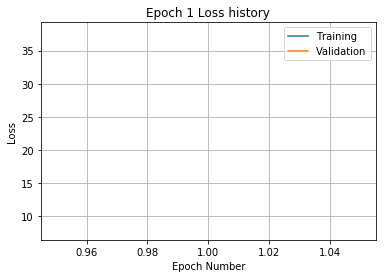

Training
Iteration 0: with minibatch training loss = 13.9 and relative error of 0.42
Iteration 20: with minibatch training loss = 15.1 and relative error of 0.47
Iteration 40: with minibatch training loss = 12.8 and relative error of 0.42
Iteration 60: with minibatch training loss = 13.1 and relative error of 0.41
Iteration 80: with minibatch training loss = 10.2 and relative error of 0.37
Iteration 100: with minibatch training loss = 8.95 and relative error of 0.34
Iteration 120: with minibatch training loss = 10.6 and relative error of 0.38
Iteration 140: with minibatch training loss = 10.2 and relative error of 0.36
Iteration 160: with minibatch training loss = 10.8 and relative error of 0.37
Iteration 180: with minibatch training loss = 11.7 and relative error of 0.38
Iteration 200: with minibatch training loss = 9.04 and relative error of 0.34
Iteration 220: with minibatch training loss = 9.86 and relative error of 0.35
Epoch 2, Overall loss = 11.1, relative error = 0.382, and pro

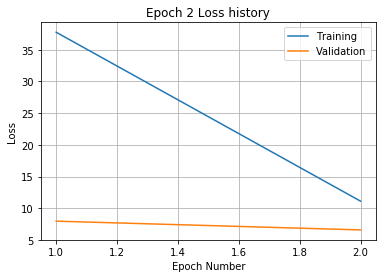

Training
Iteration 0: with minibatch training loss = 8.07 and relative error of 0.33
Iteration 20: with minibatch training loss = 9.47 and relative error of 0.35
Iteration 40: with minibatch training loss = 10.9 and relative error of 0.38
Iteration 60: with minibatch training loss = 7.83 and relative error of 0.32
Iteration 80: with minibatch training loss = 7.96 and relative error of 0.32
Iteration 100: with minibatch training loss = 8.28 and relative error of 0.33
Iteration 120: with minibatch training loss = 10.7 and relative error of 0.37
Iteration 140: with minibatch training loss = 8.05 and relative error of 0.32
Iteration 160: with minibatch training loss = 9.34 and relative error of 0.35
Iteration 180: with minibatch training loss = 9.26 and relative error of 0.35
Iteration 200: with minibatch training loss = 6.47 and relative error of 0.29
Iteration 220: with minibatch training loss = 7.05 and relative error of 0.31
Epoch 3, Overall loss = 9.11, relative error = 0.346, and pro

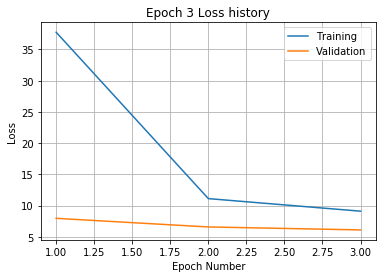

Training
Iteration 0: with minibatch training loss = 6.89 and relative error of 0.3
Iteration 20: with minibatch training loss = 7.08 and relative error of 0.31
Iteration 40: with minibatch training loss = 8.75 and relative error of 0.33
Iteration 60: with minibatch training loss = 10.9 and relative error of 0.38
Iteration 80: with minibatch training loss = 9.09 and relative error of 0.35
Iteration 100: with minibatch training loss = 7.49 and relative error of 0.32
Iteration 120: with minibatch training loss = 7.77 and relative error of 0.32
Iteration 140: with minibatch training loss = 7.2 and relative error of 0.3
Iteration 160: with minibatch training loss = 6.87 and relative error of 0.3
Iteration 180: with minibatch training loss = 6.74 and relative error of 0.32
Iteration 200: with minibatch training loss = 9.56 and relative error of 0.35
Iteration 220: with minibatch training loss = 7.79 and relative error of 0.33
Epoch 4, Overall loss = 8.04, relative error = 0.325, and process

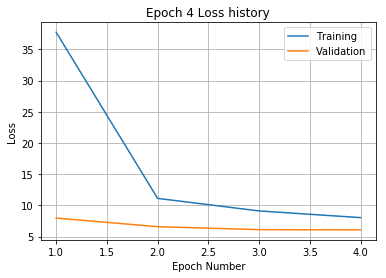

Training
Iteration 0: with minibatch training loss = 8.55 and relative error of 0.33
Iteration 20: with minibatch training loss = 7.39 and relative error of 0.3
Iteration 40: with minibatch training loss = 6.71 and relative error of 0.3
Iteration 60: with minibatch training loss = 6.8 and relative error of 0.3
Iteration 80: with minibatch training loss = 8.22 and relative error of 0.32
Iteration 100: with minibatch training loss = 6.49 and relative error of 0.29
Iteration 120: with minibatch training loss = 6.91 and relative error of 0.3
Iteration 140: with minibatch training loss = 5.65 and relative error of 0.27
Iteration 160: with minibatch training loss = 5.85 and relative error of 0.27
Iteration 180: with minibatch training loss = 8.76 and relative error of 0.34
Iteration 200: with minibatch training loss = 6.74 and relative error of 0.3
Iteration 220: with minibatch training loss = 8.81 and relative error of 0.35
Epoch 5, Overall loss = 7.36, relative error = 0.311, and process t

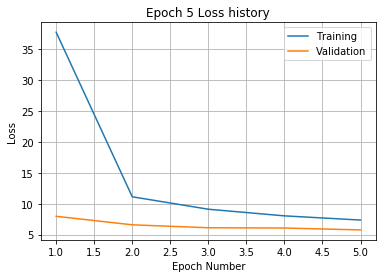

Training
Iteration 0: with minibatch training loss = 7.06 and relative error of 0.3
Iteration 20: with minibatch training loss = 9.37 and relative error of 0.35
Iteration 40: with minibatch training loss = 5.51 and relative error of 0.26
Iteration 60: with minibatch training loss = 8.81 and relative error of 0.35
Iteration 80: with minibatch training loss = 7.78 and relative error of 0.32
Iteration 100: with minibatch training loss = 6.49 and relative error of 0.29
Iteration 120: with minibatch training loss = 4.4 and relative error of 0.24
Iteration 140: with minibatch training loss = 6.66 and relative error of 0.3
Iteration 160: with minibatch training loss = 6.42 and relative error of 0.3
Iteration 180: with minibatch training loss = 8.92 and relative error of 0.34
Iteration 200: with minibatch training loss = 6.26 and relative error of 0.29
Iteration 220: with minibatch training loss = 6.89 and relative error of 0.29
Epoch 6, Overall loss = 6.98, relative error = 0.302, and process

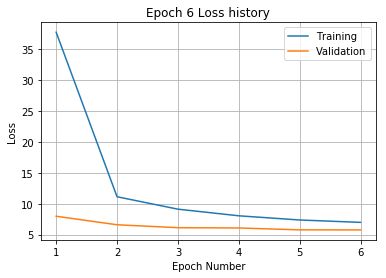

Training
Iteration 0: with minibatch training loss = 6.19 and relative error of 0.27
Iteration 20: with minibatch training loss = 6.21 and relative error of 0.29
Iteration 40: with minibatch training loss = 7.09 and relative error of 0.3
Iteration 60: with minibatch training loss = 5.52 and relative error of 0.28
Iteration 80: with minibatch training loss = 5.82 and relative error of 0.28
Iteration 100: with minibatch training loss = 6.05 and relative error of 0.28
Iteration 120: with minibatch training loss = 6.98 and relative error of 0.31
Iteration 140: with minibatch training loss = 7.18 and relative error of 0.3
Iteration 160: with minibatch training loss = 9.42 and relative error of 0.35
Iteration 180: with minibatch training loss = 6.42 and relative error of 0.3
Iteration 200: with minibatch training loss = 6.4 and relative error of 0.28
Iteration 220: with minibatch training loss = 9.22 and relative error of 0.34
Epoch 7, Overall loss = 6.6, relative error = 0.294, and process 

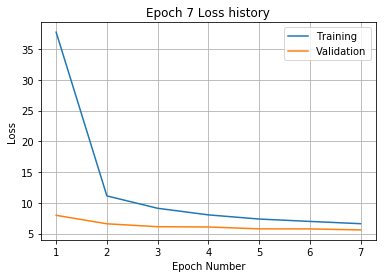

Training
Iteration 0: with minibatch training loss = 6.94 and relative error of 0.31
Iteration 20: with minibatch training loss = 6.79 and relative error of 0.31
Iteration 40: with minibatch training loss = 6.59 and relative error of 0.29
Iteration 60: with minibatch training loss = 4.84 and relative error of 0.26
Iteration 80: with minibatch training loss = 6.54 and relative error of 0.28
Iteration 100: with minibatch training loss = 8.19 and relative error of 0.32
Iteration 120: with minibatch training loss = 6.95 and relative error of 0.31
Iteration 140: with minibatch training loss = 6.41 and relative error of 0.29
Iteration 160: with minibatch training loss = 5.23 and relative error of 0.26
Iteration 180: with minibatch training loss = 4.34 and relative error of 0.23
Iteration 200: with minibatch training loss = 4.36 and relative error of 0.24
Iteration 220: with minibatch training loss = 4.62 and relative error of 0.25
Epoch 8, Overall loss = 6.31, relative error = 0.287, and pro

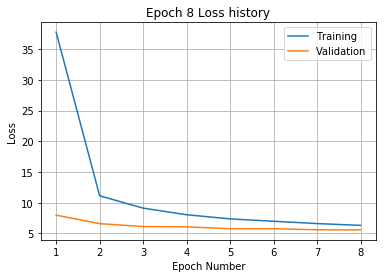

Training
Iteration 0: with minibatch training loss = 6.88 and relative error of 0.31
Iteration 20: with minibatch training loss = 5.29 and relative error of 0.26
Iteration 40: with minibatch training loss = 5.43 and relative error of 0.27
Iteration 60: with minibatch training loss = 6.81 and relative error of 0.3
Iteration 80: with minibatch training loss = 5.85 and relative error of 0.29
Iteration 100: with minibatch training loss = 5.65 and relative error of 0.27
Iteration 120: with minibatch training loss = 5.81 and relative error of 0.28
Iteration 140: with minibatch training loss = 5.28 and relative error of 0.25
Iteration 160: with minibatch training loss = 5.55 and relative error of 0.27
Iteration 180: with minibatch training loss = 5.21 and relative error of 0.27
Iteration 200: with minibatch training loss = 8.29 and relative error of 0.32
Iteration 220: with minibatch training loss = 5.55 and relative error of 0.28
Epoch 9, Overall loss = 6.15, relative error = 0.284, and proc

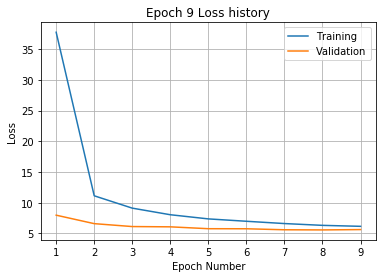

Training
Iteration 0: with minibatch training loss = 6.65 and relative error of 0.29
Iteration 20: with minibatch training loss = 5.26 and relative error of 0.26
Iteration 40: with minibatch training loss = 5.83 and relative error of 0.26
Iteration 60: with minibatch training loss = 5.58 and relative error of 0.27
Iteration 80: with minibatch training loss = 5.89 and relative error of 0.29
Iteration 100: with minibatch training loss = 5.13 and relative error of 0.26
Iteration 120: with minibatch training loss = 8.75 and relative error of 0.34
Iteration 140: with minibatch training loss = 5.33 and relative error of 0.26
Iteration 160: with minibatch training loss = 6.96 and relative error of 0.31
Iteration 180: with minibatch training loss = 6.58 and relative error of 0.3
Iteration 200: with minibatch training loss = 8.25 and relative error of 0.32
Iteration 220: with minibatch training loss = 4.23 and relative error of 0.24
Epoch 10, Overall loss = 5.88, relative error = 0.277, and pro

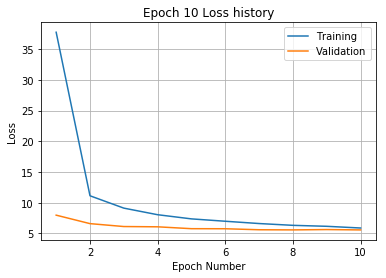

Training
Iteration 0: with minibatch training loss = 6.31 and relative error of 0.29
Iteration 20: with minibatch training loss = 6.29 and relative error of 0.29
Iteration 40: with minibatch training loss = 6.89 and relative error of 0.3
Iteration 60: with minibatch training loss = 5.01 and relative error of 0.26
Iteration 80: with minibatch training loss = 4.76 and relative error of 0.25
Iteration 100: with minibatch training loss = 4.76 and relative error of 0.26
Iteration 120: with minibatch training loss = 5.08 and relative error of 0.25
Iteration 140: with minibatch training loss = 6.15 and relative error of 0.27
Iteration 160: with minibatch training loss = 4.34 and relative error of 0.24
Iteration 180: with minibatch training loss = 4.71 and relative error of 0.25
Iteration 200: with minibatch training loss = 5.89 and relative error of 0.27
Iteration 220: with minibatch training loss = 5.18 and relative error of 0.26
Epoch 11, Overall loss = 5.66, relative error = 0.272, and pro

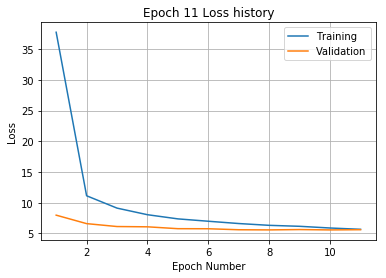

Training
Iteration 0: with minibatch training loss = 6.48 and relative error of 0.29
Iteration 20: with minibatch training loss = 4.75 and relative error of 0.24
Iteration 40: with minibatch training loss = 5.48 and relative error of 0.29
Iteration 60: with minibatch training loss = 4.74 and relative error of 0.25
Iteration 80: with minibatch training loss = 4.89 and relative error of 0.25
Iteration 100: with minibatch training loss = 4.26 and relative error of 0.23
Iteration 120: with minibatch training loss = 4.06 and relative error of 0.23
Iteration 140: with minibatch training loss = 5.62 and relative error of 0.27
Iteration 160: with minibatch training loss = 5.62 and relative error of 0.26
Iteration 180: with minibatch training loss = 6.41 and relative error of 0.29
Iteration 200: with minibatch training loss = 5.96 and relative error of 0.3
Iteration 220: with minibatch training loss = 4.18 and relative error of 0.24
Epoch 12, Overall loss = 5.57, relative error = 0.27, and proc

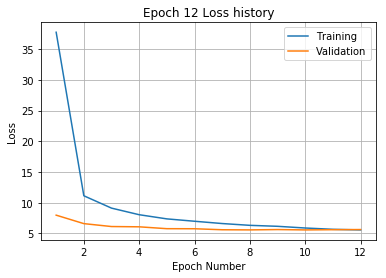

Training
Iteration 0: with minibatch training loss = 6.84 and relative error of 0.3
Iteration 20: with minibatch training loss = 6.16 and relative error of 0.28
Iteration 40: with minibatch training loss = 3.76 and relative error of 0.22
Iteration 60: with minibatch training loss = 6.37 and relative error of 0.29
Iteration 80: with minibatch training loss = 4.08 and relative error of 0.24
Iteration 100: with minibatch training loss = 4.58 and relative error of 0.24
Iteration 120: with minibatch training loss = 5.27 and relative error of 0.26
Iteration 140: with minibatch training loss = 6.48 and relative error of 0.3
Iteration 160: with minibatch training loss = 4.82 and relative error of 0.25
Iteration 180: with minibatch training loss = 5.58 and relative error of 0.27
Iteration 200: with minibatch training loss = 5.78 and relative error of 0.28
Iteration 220: with minibatch training loss = 6.07 and relative error of 0.28
Epoch 13, Overall loss = 5.43, relative error = 0.266, and proc

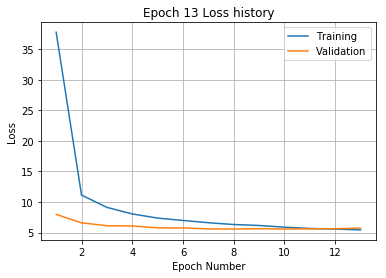

Training
Iteration 0: with minibatch training loss = 5.5 and relative error of 0.27
Iteration 20: with minibatch training loss = 4.84 and relative error of 0.26
Iteration 40: with minibatch training loss = 4.88 and relative error of 0.25
Iteration 60: with minibatch training loss = 4.54 and relative error of 0.24
Iteration 80: with minibatch training loss = 4.13 and relative error of 0.24
Iteration 100: with minibatch training loss = 5.82 and relative error of 0.28
Iteration 120: with minibatch training loss = 3.53 and relative error of 0.21
Iteration 140: with minibatch training loss = 4.84 and relative error of 0.26
Iteration 160: with minibatch training loss = 5.68 and relative error of 0.27
Iteration 180: with minibatch training loss = 6.36 and relative error of 0.28
Iteration 200: with minibatch training loss = 5.78 and relative error of 0.28
Iteration 220: with minibatch training loss = 5.7 and relative error of 0.28
Epoch 14, Overall loss = 5.34, relative error = 0.264, and proc

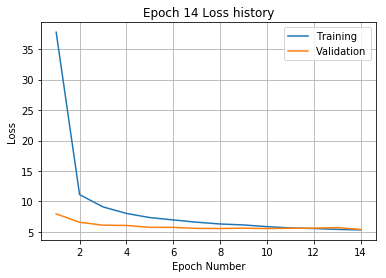

Training
Iteration 0: with minibatch training loss = 5.43 and relative error of 0.27
Iteration 20: with minibatch training loss = 3.89 and relative error of 0.23
Iteration 40: with minibatch training loss = 4.8 and relative error of 0.25
Iteration 60: with minibatch training loss = 6.42 and relative error of 0.29
Iteration 80: with minibatch training loss = 5.52 and relative error of 0.27
Iteration 100: with minibatch training loss = 6.82 and relative error of 0.3
Iteration 120: with minibatch training loss = 3.93 and relative error of 0.24
Iteration 140: with minibatch training loss = 6.25 and relative error of 0.29
Iteration 160: with minibatch training loss = 5.58 and relative error of 0.28
Iteration 180: with minibatch training loss = 5.41 and relative error of 0.28
Iteration 200: with minibatch training loss = 6.67 and relative error of 0.3
Iteration 220: with minibatch training loss = 6.8 and relative error of 0.31
Epoch 15, Overall loss = 5.21, relative error = 0.261, and proces

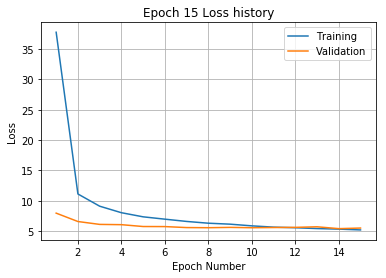

Training
Iteration 0: with minibatch training loss = 5.25 and relative error of 0.27
Iteration 20: with minibatch training loss = 4.5 and relative error of 0.24
Iteration 40: with minibatch training loss = 4.59 and relative error of 0.24
Iteration 60: with minibatch training loss = 6.76 and relative error of 0.3
Iteration 80: with minibatch training loss = 5.07 and relative error of 0.26
Iteration 100: with minibatch training loss = 4.07 and relative error of 0.23
Iteration 120: with minibatch training loss = 7.54 and relative error of 0.31
Iteration 140: with minibatch training loss = 4.01 and relative error of 0.22
Iteration 160: with minibatch training loss = 3.78 and relative error of 0.22
Iteration 180: with minibatch training loss = 5.19 and relative error of 0.26
Iteration 200: with minibatch training loss = 4.13 and relative error of 0.23
Iteration 220: with minibatch training loss = 6.36 and relative error of 0.3
Epoch 16, Overall loss = 5.11, relative error = 0.258, and proce

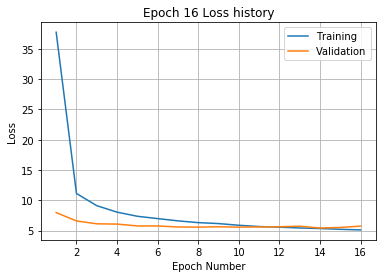

Training
Iteration 0: with minibatch training loss = 5.69 and relative error of 0.29
Iteration 20: with minibatch training loss = 4.39 and relative error of 0.24
Iteration 40: with minibatch training loss = 3.51 and relative error of 0.22
Iteration 60: with minibatch training loss = 6.9 and relative error of 0.3
Iteration 80: with minibatch training loss = 5.19 and relative error of 0.25
Iteration 100: with minibatch training loss = 3.67 and relative error of 0.22
Iteration 120: with minibatch training loss = 5.97 and relative error of 0.27
Iteration 140: with minibatch training loss = 4.27 and relative error of 0.24
Iteration 160: with minibatch training loss = 5.14 and relative error of 0.27
Iteration 180: with minibatch training loss = 5.04 and relative error of 0.26
Iteration 200: with minibatch training loss = 5.02 and relative error of 0.27
Iteration 220: with minibatch training loss = 4.85 and relative error of 0.26
Epoch 17, Overall loss = 5.04, relative error = 0.257, and proc

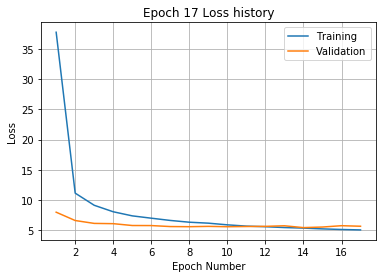

Training
Iteration 0: with minibatch training loss = 4.18 and relative error of 0.24
Iteration 20: with minibatch training loss = 4.95 and relative error of 0.26
Iteration 40: with minibatch training loss = 5.53 and relative error of 0.26
Iteration 60: with minibatch training loss = 5.07 and relative error of 0.25
Iteration 80: with minibatch training loss = 7.33 and relative error of 0.32
Iteration 100: with minibatch training loss = 3.17 and relative error of 0.2
Iteration 120: with minibatch training loss = 4.56 and relative error of 0.24
Iteration 140: with minibatch training loss = 4.25 and relative error of 0.24
Iteration 160: with minibatch training loss = 6 and relative error of 0.27
Iteration 180: with minibatch training loss = 3.79 and relative error of 0.23
Iteration 200: with minibatch training loss = 4.99 and relative error of 0.25
Iteration 220: with minibatch training loss = 5.71 and relative error of 0.27
Epoch 18, Overall loss = 4.95, relative error = 0.254, and proces

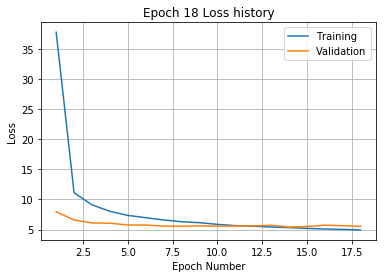

Training
Iteration 0: with minibatch training loss = 4.24 and relative error of 0.24
Iteration 20: with minibatch training loss = 5.26 and relative error of 0.26
Iteration 40: with minibatch training loss = 4.43 and relative error of 0.24
Iteration 60: with minibatch training loss = 4.97 and relative error of 0.25
Iteration 80: with minibatch training loss = 3.52 and relative error of 0.22
Iteration 100: with minibatch training loss = 4.43 and relative error of 0.24
Iteration 120: with minibatch training loss = 5.06 and relative error of 0.24
Iteration 140: with minibatch training loss = 3.1 and relative error of 0.21
Iteration 160: with minibatch training loss = 8.46 and relative error of 0.33
Iteration 180: with minibatch training loss = 5.26 and relative error of 0.27
Iteration 200: with minibatch training loss = 5.15 and relative error of 0.26
Iteration 220: with minibatch training loss = 4.93 and relative error of 0.26
Epoch 19, Overall loss = 4.87, relative error = 0.252, and pro

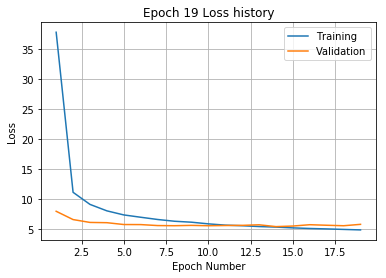

Validation error has stopped improving! Training on repetition 7 stopped!
Training
Iteration 0: with minibatch training loss = 258 and relative error of 1.8
Iteration 20: with minibatch training loss = 125 and relative error of 1.3
Iteration 40: with minibatch training loss = 80 and relative error of 1
Iteration 60: with minibatch training loss = 59 and relative error of 0.89
Iteration 80: with minibatch training loss = 53.1 and relative error of 0.81
Iteration 100: with minibatch training loss = 38.9 and relative error of 0.69
Iteration 120: with minibatch training loss = 26.4 and relative error of 0.59
Iteration 140: with minibatch training loss = 23.8 and relative error of 0.52
Iteration 160: with minibatch training loss = 17.4 and relative error of 0.49
Iteration 180: with minibatch training loss = 19 and relative error of 0.5
Iteration 200: with minibatch training loss = 15.2 and relative error of 0.47
Iteration 220: with minibatch training loss = 16 and relative error of 0.44
Epo

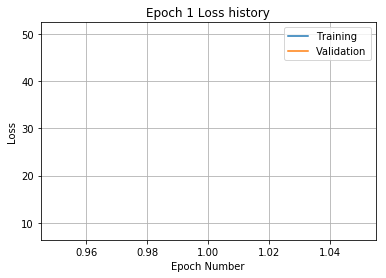

Training
Iteration 0: with minibatch training loss = 16 and relative error of 0.45
Iteration 20: with minibatch training loss = 13.7 and relative error of 0.42
Iteration 40: with minibatch training loss = 15.4 and relative error of 0.44
Iteration 60: with minibatch training loss = 12.4 and relative error of 0.42
Iteration 80: with minibatch training loss = 14.9 and relative error of 0.45
Iteration 100: with minibatch training loss = 14.4 and relative error of 0.44
Iteration 120: with minibatch training loss = 13.2 and relative error of 0.44
Iteration 140: with minibatch training loss = 10.7 and relative error of 0.38
Iteration 160: with minibatch training loss = 12.5 and relative error of 0.4
Iteration 180: with minibatch training loss = 15.1 and relative error of 0.45
Iteration 200: with minibatch training loss = 10.3 and relative error of 0.37
Iteration 220: with minibatch training loss = 10.9 and relative error of 0.38
Epoch 2, Overall loss = 12.8, relative error = 0.41, and process

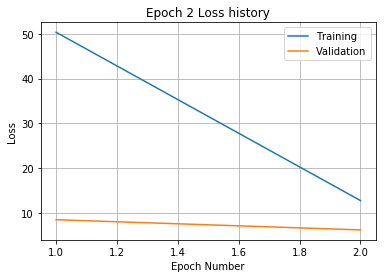

Training
Iteration 0: with minibatch training loss = 11.2 and relative error of 0.37
Iteration 20: with minibatch training loss = 9.56 and relative error of 0.35
Iteration 40: with minibatch training loss = 9.36 and relative error of 0.35
Iteration 60: with minibatch training loss = 9.05 and relative error of 0.35
Iteration 80: with minibatch training loss = 10.5 and relative error of 0.36
Iteration 100: with minibatch training loss = 8.62 and relative error of 0.33
Iteration 120: with minibatch training loss = 8.32 and relative error of 0.34
Iteration 140: with minibatch training loss = 8.39 and relative error of 0.33
Iteration 160: with minibatch training loss = 9.42 and relative error of 0.35
Iteration 180: with minibatch training loss = 12.5 and relative error of 0.4
Iteration 200: with minibatch training loss = 9.2 and relative error of 0.36
Iteration 220: with minibatch training loss = 11.7 and relative error of 0.41
Epoch 3, Overall loss = 10.4, relative error = 0.37, and proces

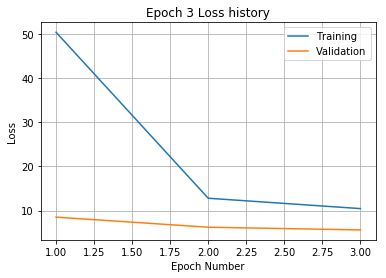

Training
Iteration 0: with minibatch training loss = 9.55 and relative error of 0.35
Iteration 20: with minibatch training loss = 9.44 and relative error of 0.35
Iteration 40: with minibatch training loss = 7.27 and relative error of 0.32
Iteration 60: with minibatch training loss = 8.37 and relative error of 0.33
Iteration 80: with minibatch training loss = 11.4 and relative error of 0.4
Iteration 100: with minibatch training loss = 9.83 and relative error of 0.36
Iteration 120: with minibatch training loss = 8.93 and relative error of 0.34
Iteration 140: with minibatch training loss = 6.99 and relative error of 0.3
Iteration 160: with minibatch training loss = 8.04 and relative error of 0.33
Iteration 180: with minibatch training loss = 7.15 and relative error of 0.31
Iteration 200: with minibatch training loss = 10.6 and relative error of 0.39
Iteration 220: with minibatch training loss = 7.04 and relative error of 0.29
Epoch 4, Overall loss = 9.13, relative error = 0.346, and proce

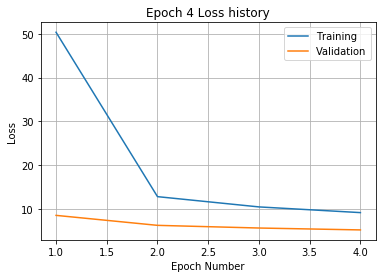

Training
Iteration 0: with minibatch training loss = 7.2 and relative error of 0.3
Iteration 20: with minibatch training loss = 8.93 and relative error of 0.35
Iteration 40: with minibatch training loss = 7.71 and relative error of 0.32
Iteration 60: with minibatch training loss = 8.5 and relative error of 0.35
Iteration 80: with minibatch training loss = 11.1 and relative error of 0.38
Iteration 100: with minibatch training loss = 6.25 and relative error of 0.29
Iteration 120: with minibatch training loss = 7.78 and relative error of 0.33
Iteration 140: with minibatch training loss = 8.99 and relative error of 0.34
Iteration 160: with minibatch training loss = 7.92 and relative error of 0.32
Iteration 180: with minibatch training loss = 8.46 and relative error of 0.33
Iteration 200: with minibatch training loss = 6.63 and relative error of 0.29
Iteration 220: with minibatch training loss = 7.42 and relative error of 0.32
Epoch 5, Overall loss = 8.38, relative error = 0.331, and proces

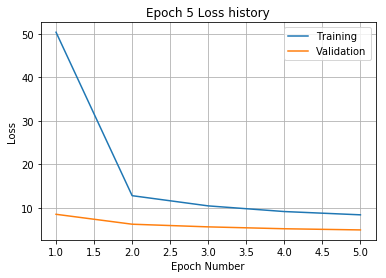

Training
Iteration 0: with minibatch training loss = 6.85 and relative error of 0.31
Iteration 20: with minibatch training loss = 7.81 and relative error of 0.32
Iteration 40: with minibatch training loss = 8.62 and relative error of 0.33
Iteration 60: with minibatch training loss = 5.67 and relative error of 0.27
Iteration 80: with minibatch training loss = 11.5 and relative error of 0.38
Iteration 100: with minibatch training loss = 7.3 and relative error of 0.3
Iteration 120: with minibatch training loss = 7.54 and relative error of 0.31
Iteration 140: with minibatch training loss = 7.41 and relative error of 0.32
Iteration 160: with minibatch training loss = 9.42 and relative error of 0.34
Iteration 180: with minibatch training loss = 6.12 and relative error of 0.29
Iteration 200: with minibatch training loss = 8.27 and relative error of 0.35
Iteration 220: with minibatch training loss = 7.03 and relative error of 0.3
Epoch 6, Overall loss = 7.77, relative error = 0.319, and proces

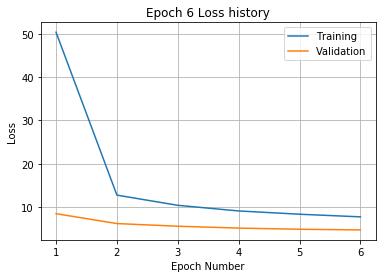

Training
Iteration 0: with minibatch training loss = 6.29 and relative error of 0.29
Iteration 20: with minibatch training loss = 7.91 and relative error of 0.34
Iteration 40: with minibatch training loss = 9.15 and relative error of 0.35
Iteration 60: with minibatch training loss = 5.77 and relative error of 0.29
Iteration 80: with minibatch training loss = 8.55 and relative error of 0.33
Iteration 100: with minibatch training loss = 7.79 and relative error of 0.32
Iteration 120: with minibatch training loss = 7.18 and relative error of 0.31
Iteration 140: with minibatch training loss = 7.54 and relative error of 0.32
Iteration 160: with minibatch training loss = 5.88 and relative error of 0.28
Iteration 180: with minibatch training loss = 6.86 and relative error of 0.3
Iteration 200: with minibatch training loss = 6.97 and relative error of 0.32
Iteration 220: with minibatch training loss = 6.05 and relative error of 0.29
Epoch 7, Overall loss = 7.29, relative error = 0.309, and proc

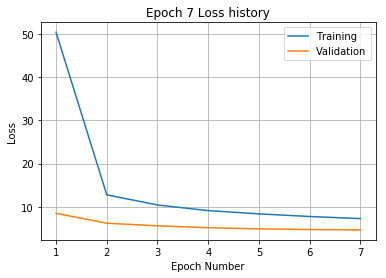

Training
Iteration 0: with minibatch training loss = 6.54 and relative error of 0.31
Iteration 20: with minibatch training loss = 9.62 and relative error of 0.35
Iteration 40: with minibatch training loss = 7.04 and relative error of 0.3
Iteration 60: with minibatch training loss = 7.14 and relative error of 0.31
Iteration 80: with minibatch training loss = 6.18 and relative error of 0.28
Iteration 100: with minibatch training loss = 8.44 and relative error of 0.34
Iteration 120: with minibatch training loss = 5.9 and relative error of 0.27
Iteration 140: with minibatch training loss = 6.14 and relative error of 0.28
Iteration 160: with minibatch training loss = 6.31 and relative error of 0.29
Iteration 180: with minibatch training loss = 10.6 and relative error of 0.38
Iteration 200: with minibatch training loss = 7.94 and relative error of 0.33
Iteration 220: with minibatch training loss = 6.58 and relative error of 0.29
Epoch 8, Overall loss = 7.02, relative error = 0.303, and proce

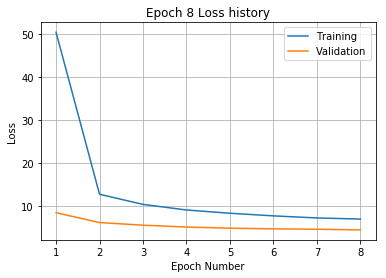

Training
Iteration 0: with minibatch training loss = 8.39 and relative error of 0.32
Iteration 20: with minibatch training loss = 7.76 and relative error of 0.32
Iteration 40: with minibatch training loss = 5.3 and relative error of 0.26
Iteration 60: with minibatch training loss = 6.96 and relative error of 0.31
Iteration 80: with minibatch training loss = 6.48 and relative error of 0.29
Iteration 100: with minibatch training loss = 8.03 and relative error of 0.32
Iteration 120: with minibatch training loss = 5.51 and relative error of 0.27
Iteration 140: with minibatch training loss = 7.08 and relative error of 0.3
Iteration 160: with minibatch training loss = 4.86 and relative error of 0.26
Iteration 180: with minibatch training loss = 8.46 and relative error of 0.33
Iteration 200: with minibatch training loss = 7.03 and relative error of 0.31
Iteration 220: with minibatch training loss = 7.35 and relative error of 0.31
Epoch 9, Overall loss = 6.72, relative error = 0.296, and proce

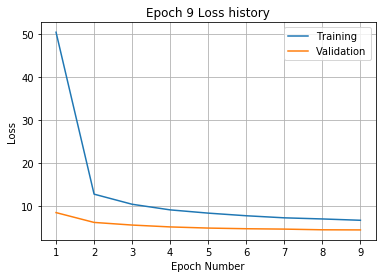

Training
Iteration 0: with minibatch training loss = 7.11 and relative error of 0.31
Iteration 20: with minibatch training loss = 5.07 and relative error of 0.25
Iteration 40: with minibatch training loss = 8.65 and relative error of 0.34
Iteration 60: with minibatch training loss = 5.83 and relative error of 0.27
Iteration 80: with minibatch training loss = 7.74 and relative error of 0.32
Iteration 100: with minibatch training loss = 7.37 and relative error of 0.29
Iteration 120: with minibatch training loss = 6.44 and relative error of 0.29
Iteration 140: with minibatch training loss = 6.63 and relative error of 0.3
Iteration 160: with minibatch training loss = 5.72 and relative error of 0.28
Iteration 180: with minibatch training loss = 7.27 and relative error of 0.32
Iteration 200: with minibatch training loss = 4.77 and relative error of 0.26
Iteration 220: with minibatch training loss = 5.48 and relative error of 0.27
Epoch 10, Overall loss = 6.47, relative error = 0.291, and pro

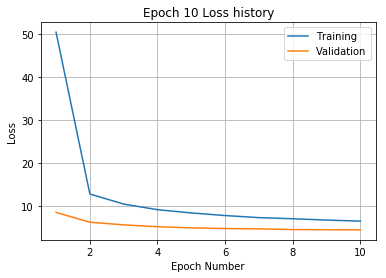

Training
Iteration 0: with minibatch training loss = 5.41 and relative error of 0.27
Iteration 20: with minibatch training loss = 7.52 and relative error of 0.32
Iteration 40: with minibatch training loss = 6.51 and relative error of 0.3
Iteration 60: with minibatch training loss = 4.9 and relative error of 0.26
Iteration 80: with minibatch training loss = 5.41 and relative error of 0.28
Iteration 100: with minibatch training loss = 5.2 and relative error of 0.26
Iteration 120: with minibatch training loss = 6.82 and relative error of 0.3
Iteration 140: with minibatch training loss = 6.29 and relative error of 0.28
Iteration 160: with minibatch training loss = 6.33 and relative error of 0.29
Iteration 180: with minibatch training loss = 6.52 and relative error of 0.29
Iteration 200: with minibatch training loss = 6.25 and relative error of 0.29
Iteration 220: with minibatch training loss = 8.53 and relative error of 0.32
Epoch 11, Overall loss = 6.22, relative error = 0.285, and proces

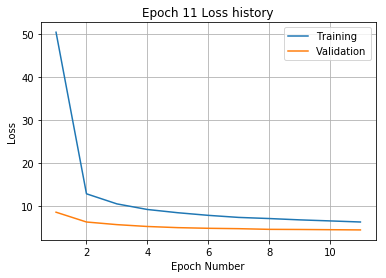

Training
Iteration 0: with minibatch training loss = 6.65 and relative error of 0.29
Iteration 20: with minibatch training loss = 6.79 and relative error of 0.29
Iteration 40: with minibatch training loss = 5.27 and relative error of 0.27
Iteration 60: with minibatch training loss = 6.99 and relative error of 0.31
Iteration 80: with minibatch training loss = 6.66 and relative error of 0.3
Iteration 100: with minibatch training loss = 5.81 and relative error of 0.26
Iteration 120: with minibatch training loss = 5.47 and relative error of 0.27
Iteration 140: with minibatch training loss = 5.9 and relative error of 0.28
Iteration 160: with minibatch training loss = 4.86 and relative error of 0.26
Iteration 180: with minibatch training loss = 5.77 and relative error of 0.27
Iteration 200: with minibatch training loss = 5.97 and relative error of 0.29
Iteration 220: with minibatch training loss = 7.66 and relative error of 0.31
Epoch 12, Overall loss = 6.08, relative error = 0.282, and proc

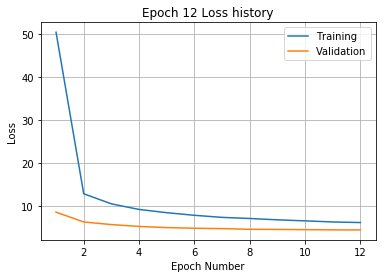

Training
Iteration 0: with minibatch training loss = 4.45 and relative error of 0.24
Iteration 20: with minibatch training loss = 7.61 and relative error of 0.32
Iteration 40: with minibatch training loss = 4.49 and relative error of 0.26
Iteration 60: with minibatch training loss = 5.36 and relative error of 0.26
Iteration 80: with minibatch training loss = 6.41 and relative error of 0.29
Iteration 100: with minibatch training loss = 6.68 and relative error of 0.31
Iteration 120: with minibatch training loss = 5.15 and relative error of 0.27
Iteration 140: with minibatch training loss = 5.09 and relative error of 0.26
Iteration 160: with minibatch training loss = 4.7 and relative error of 0.25
Iteration 180: with minibatch training loss = 4.83 and relative error of 0.25
Iteration 200: with minibatch training loss = 6.03 and relative error of 0.28
Iteration 220: with minibatch training loss = 6.19 and relative error of 0.28
Epoch 13, Overall loss = 5.89, relative error = 0.278, and pro

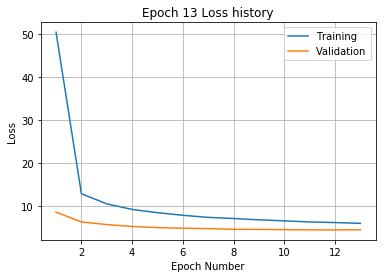

Training
Iteration 0: with minibatch training loss = 5.86 and relative error of 0.28
Iteration 20: with minibatch training loss = 5.84 and relative error of 0.27
Iteration 40: with minibatch training loss = 4.07 and relative error of 0.23
Iteration 60: with minibatch training loss = 7.08 and relative error of 0.33
Iteration 80: with minibatch training loss = 7.04 and relative error of 0.29
Iteration 100: with minibatch training loss = 5.65 and relative error of 0.28
Iteration 120: with minibatch training loss = 5.24 and relative error of 0.28
Iteration 140: with minibatch training loss = 6.2 and relative error of 0.28
Iteration 160: with minibatch training loss = 3.57 and relative error of 0.22
Iteration 180: with minibatch training loss = 7.2 and relative error of 0.31
Iteration 200: with minibatch training loss = 6.45 and relative error of 0.29
Iteration 220: with minibatch training loss = 5.75 and relative error of 0.27
Epoch 14, Overall loss = 5.78, relative error = 0.275, and proc

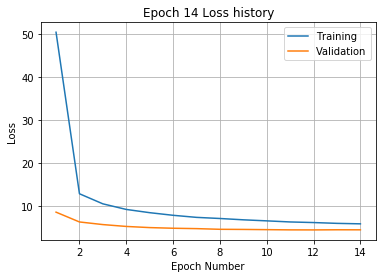

Training
Iteration 0: with minibatch training loss = 6.48 and relative error of 0.29
Iteration 20: with minibatch training loss = 5.28 and relative error of 0.27
Iteration 40: with minibatch training loss = 6.83 and relative error of 0.31
Iteration 60: with minibatch training loss = 5.25 and relative error of 0.26
Iteration 80: with minibatch training loss = 4.51 and relative error of 0.24
Iteration 100: with minibatch training loss = 5.94 and relative error of 0.28
Iteration 120: with minibatch training loss = 5.71 and relative error of 0.28
Iteration 140: with minibatch training loss = 8.7 and relative error of 0.34
Iteration 160: with minibatch training loss = 6.44 and relative error of 0.29
Iteration 180: with minibatch training loss = 6.16 and relative error of 0.27
Iteration 200: with minibatch training loss = 5.7 and relative error of 0.28
Iteration 220: with minibatch training loss = 5.78 and relative error of 0.28
Epoch 15, Overall loss = 5.64, relative error = 0.272, and proc

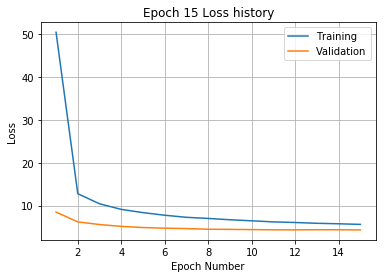

Training
Iteration 0: with minibatch training loss = 5.79 and relative error of 0.28
Iteration 20: with minibatch training loss = 4.8 and relative error of 0.26
Iteration 40: with minibatch training loss = 6.74 and relative error of 0.29
Iteration 60: with minibatch training loss = 5.18 and relative error of 0.26
Iteration 80: with minibatch training loss = 5.86 and relative error of 0.27
Iteration 100: with minibatch training loss = 6.22 and relative error of 0.28
Iteration 120: with minibatch training loss = 5.6 and relative error of 0.28
Iteration 140: with minibatch training loss = 4.62 and relative error of 0.24
Iteration 160: with minibatch training loss = 5.27 and relative error of 0.26
Iteration 180: with minibatch training loss = 5.86 and relative error of 0.27
Iteration 200: with minibatch training loss = 4.11 and relative error of 0.24
Iteration 220: with minibatch training loss = 5.38 and relative error of 0.27
Epoch 16, Overall loss = 5.55, relative error = 0.269, and proc

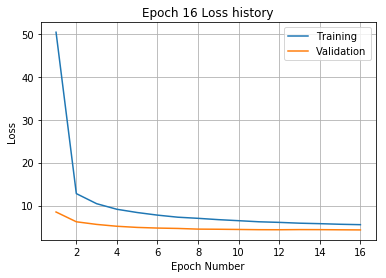

Training
Iteration 0: with minibatch training loss = 6.18 and relative error of 0.27
Iteration 20: with minibatch training loss = 5.59 and relative error of 0.26
Iteration 40: with minibatch training loss = 6.64 and relative error of 0.29
Iteration 60: with minibatch training loss = 3.83 and relative error of 0.22
Iteration 80: with minibatch training loss = 4.87 and relative error of 0.24
Iteration 100: with minibatch training loss = 4.9 and relative error of 0.25
Iteration 120: with minibatch training loss = 5.01 and relative error of 0.25
Iteration 140: with minibatch training loss = 4.84 and relative error of 0.25
Iteration 160: with minibatch training loss = 5.74 and relative error of 0.27
Iteration 180: with minibatch training loss = 4.32 and relative error of 0.24
Iteration 200: with minibatch training loss = 4.41 and relative error of 0.25
Iteration 220: with minibatch training loss = 3.91 and relative error of 0.23
Epoch 17, Overall loss = 5.43, relative error = 0.267, and pro

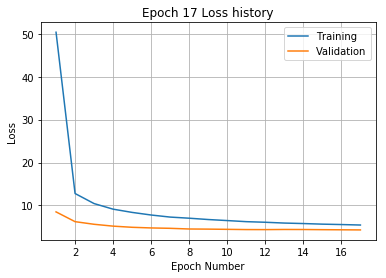

Training
Iteration 0: with minibatch training loss = 4.92 and relative error of 0.25
Iteration 20: with minibatch training loss = 4.64 and relative error of 0.23
Iteration 40: with minibatch training loss = 6.12 and relative error of 0.27
Iteration 60: with minibatch training loss = 6.55 and relative error of 0.28
Iteration 80: with minibatch training loss = 6.84 and relative error of 0.3
Iteration 100: with minibatch training loss = 7.54 and relative error of 0.32
Iteration 120: with minibatch training loss = 4.66 and relative error of 0.26
Iteration 140: with minibatch training loss = 5.47 and relative error of 0.28
Iteration 160: with minibatch training loss = 4.92 and relative error of 0.26
Iteration 180: with minibatch training loss = 4.82 and relative error of 0.25
Iteration 200: with minibatch training loss = 6.03 and relative error of 0.28
Iteration 220: with minibatch training loss = 6.38 and relative error of 0.3
Epoch 18, Overall loss = 5.37, relative error = 0.265, and proc

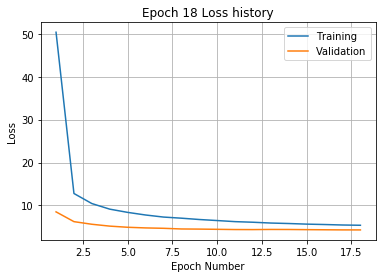

Training
Iteration 0: with minibatch training loss = 5.24 and relative error of 0.26
Iteration 20: with minibatch training loss = 4.78 and relative error of 0.26
Iteration 40: with minibatch training loss = 5.35 and relative error of 0.26
Iteration 60: with minibatch training loss = 4.73 and relative error of 0.24
Iteration 80: with minibatch training loss = 5.87 and relative error of 0.28
Iteration 100: with minibatch training loss = 5.5 and relative error of 0.28
Iteration 120: with minibatch training loss = 6.2 and relative error of 0.28
Iteration 140: with minibatch training loss = 4.86 and relative error of 0.25
Iteration 160: with minibatch training loss = 5.63 and relative error of 0.27
Iteration 180: with minibatch training loss = 3.9 and relative error of 0.23
Iteration 200: with minibatch training loss = 4.43 and relative error of 0.24
Iteration 220: with minibatch training loss = 3.67 and relative error of 0.22
Epoch 19, Overall loss = 5.25, relative error = 0.262, and proce

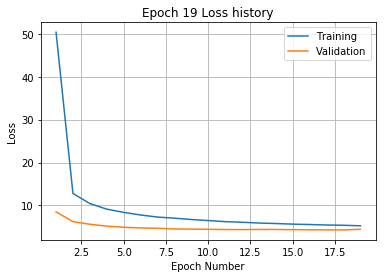

Training
Iteration 0: with minibatch training loss = 5.08 and relative error of 0.25
Iteration 20: with minibatch training loss = 6.81 and relative error of 0.29
Iteration 40: with minibatch training loss = 4.89 and relative error of 0.25
Iteration 60: with minibatch training loss = 6.55 and relative error of 0.29
Iteration 80: with minibatch training loss = 5.45 and relative error of 0.27
Iteration 100: with minibatch training loss = 3.66 and relative error of 0.22
Iteration 120: with minibatch training loss = 4.15 and relative error of 0.24
Iteration 140: with minibatch training loss = 4.39 and relative error of 0.25
Iteration 160: with minibatch training loss = 5.93 and relative error of 0.28
Iteration 180: with minibatch training loss = 5.22 and relative error of 0.27
Iteration 200: with minibatch training loss = 2.89 and relative error of 0.19
Iteration 220: with minibatch training loss = 6.76 and relative error of 0.29
Epoch 20, Overall loss = 5.15, relative error = 0.259, and pr

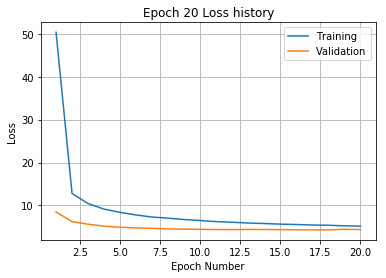

Training
Iteration 0: with minibatch training loss = 4.14 and relative error of 0.24
Iteration 20: with minibatch training loss = 5.7 and relative error of 0.27
Iteration 40: with minibatch training loss = 7.39 and relative error of 0.31
Iteration 60: with minibatch training loss = 5.36 and relative error of 0.26
Iteration 80: with minibatch training loss = 5.01 and relative error of 0.26
Iteration 100: with minibatch training loss = 3.71 and relative error of 0.22
Iteration 120: with minibatch training loss = 4.43 and relative error of 0.24
Iteration 140: with minibatch training loss = 4.65 and relative error of 0.25
Iteration 160: with minibatch training loss = 5 and relative error of 0.26
Iteration 180: with minibatch training loss = 5.95 and relative error of 0.28
Iteration 200: with minibatch training loss = 4.51 and relative error of 0.24
Iteration 220: with minibatch training loss = 4.1 and relative error of 0.23
Epoch 21, Overall loss = 5.02, relative error = 0.256, and process

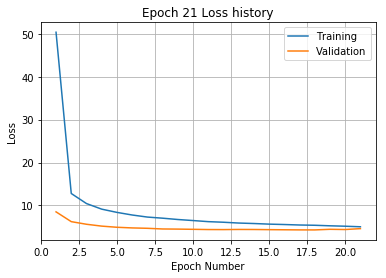

Training
Iteration 0: with minibatch training loss = 4.77 and relative error of 0.26
Iteration 20: with minibatch training loss = 6.42 and relative error of 0.29
Iteration 40: with minibatch training loss = 4.75 and relative error of 0.25
Iteration 60: with minibatch training loss = 3.18 and relative error of 0.2
Iteration 80: with minibatch training loss = 4.22 and relative error of 0.23
Iteration 100: with minibatch training loss = 4.98 and relative error of 0.26
Iteration 120: with minibatch training loss = 5.24 and relative error of 0.26
Iteration 140: with minibatch training loss = 4.81 and relative error of 0.26
Iteration 160: with minibatch training loss = 4.77 and relative error of 0.25
Iteration 180: with minibatch training loss = 4.18 and relative error of 0.24
Iteration 200: with minibatch training loss = 3.82 and relative error of 0.23
Iteration 220: with minibatch training loss = 4.46 and relative error of 0.25
Epoch 22, Overall loss = 4.93, relative error = 0.254, and pro

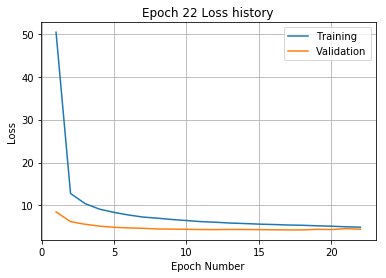

Training
Iteration 0: with minibatch training loss = 3.1 and relative error of 0.2
Iteration 20: with minibatch training loss = 5.94 and relative error of 0.28
Iteration 40: with minibatch training loss = 3.96 and relative error of 0.22
Iteration 60: with minibatch training loss = 4.12 and relative error of 0.23
Iteration 80: with minibatch training loss = 3.22 and relative error of 0.2
Iteration 100: with minibatch training loss = 3.83 and relative error of 0.23
Iteration 120: with minibatch training loss = 5.55 and relative error of 0.27
Iteration 140: with minibatch training loss = 6.47 and relative error of 0.3
Iteration 160: with minibatch training loss = 4.87 and relative error of 0.25
Iteration 180: with minibatch training loss = 4.66 and relative error of 0.25
Iteration 200: with minibatch training loss = 4.19 and relative error of 0.23
Iteration 220: with minibatch training loss = 4.46 and relative error of 0.25
Epoch 23, Overall loss = 4.87, relative error = 0.252, and proces

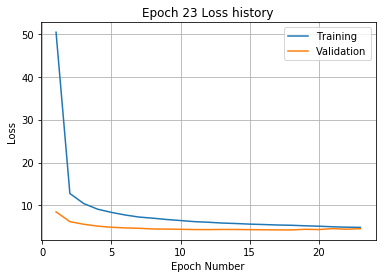

Validation error has stopped improving! Training on repetition 8 stopped!
Training
Iteration 0: with minibatch training loss = 173 and relative error of 1.5
Iteration 20: with minibatch training loss = 91.3 and relative error of 1.1
Iteration 40: with minibatch training loss = 55.3 and relative error of 0.86
Iteration 60: with minibatch training loss = 58.8 and relative error of 0.85
Iteration 80: with minibatch training loss = 32.9 and relative error of 0.69
Iteration 100: with minibatch training loss = 25.5 and relative error of 0.57
Iteration 120: with minibatch training loss = 17.8 and relative error of 0.49
Iteration 140: with minibatch training loss = 16.9 and relative error of 0.46
Iteration 160: with minibatch training loss = 19.1 and relative error of 0.5
Iteration 180: with minibatch training loss = 16.6 and relative error of 0.48
Iteration 200: with minibatch training loss = 14.8 and relative error of 0.43
Iteration 220: with minibatch training loss = 13.1 and relative error

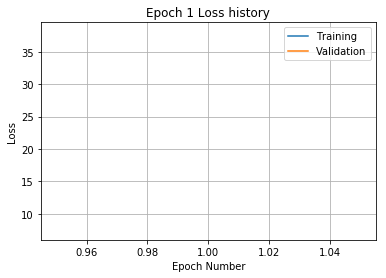

Training
Iteration 0: with minibatch training loss = 11.9 and relative error of 0.38
Iteration 20: with minibatch training loss = 13.9 and relative error of 0.44
Iteration 40: with minibatch training loss = 10.6 and relative error of 0.38
Iteration 60: with minibatch training loss = 13.3 and relative error of 0.42
Iteration 80: with minibatch training loss = 12.7 and relative error of 0.41
Iteration 100: with minibatch training loss = 11.5 and relative error of 0.37
Iteration 120: with minibatch training loss = 12 and relative error of 0.39
Iteration 140: with minibatch training loss = 13.8 and relative error of 0.43
Iteration 160: with minibatch training loss = 10.4 and relative error of 0.36
Iteration 180: with minibatch training loss = 10.4 and relative error of 0.37
Iteration 200: with minibatch training loss = 11.6 and relative error of 0.38
Iteration 220: with minibatch training loss = 11.1 and relative error of 0.38
Epoch 2, Overall loss = 11.6, relative error = 0.388, and proce

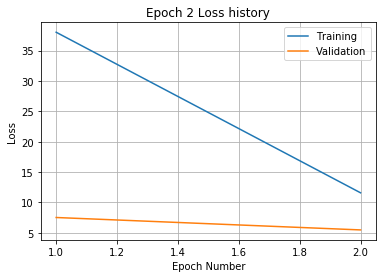

Training
Iteration 0: with minibatch training loss = 12.3 and relative error of 0.41
Iteration 20: with minibatch training loss = 9.9 and relative error of 0.36
Iteration 40: with minibatch training loss = 12.6 and relative error of 0.39
Iteration 60: with minibatch training loss = 8.06 and relative error of 0.33
Iteration 80: with minibatch training loss = 12.7 and relative error of 0.42
Iteration 100: with minibatch training loss = 10.4 and relative error of 0.37
Iteration 120: with minibatch training loss = 10.3 and relative error of 0.38
Iteration 140: with minibatch training loss = 6.98 and relative error of 0.29
Iteration 160: with minibatch training loss = 10.7 and relative error of 0.38
Iteration 180: with minibatch training loss = 6.41 and relative error of 0.29
Iteration 200: with minibatch training loss = 6.66 and relative error of 0.29
Iteration 220: with minibatch training loss = 11.6 and relative error of 0.38
Epoch 3, Overall loss = 9.53, relative error = 0.352, and proc

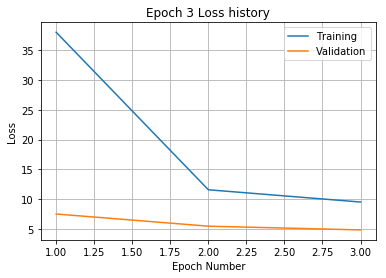

Training
Iteration 0: with minibatch training loss = 8.59 and relative error of 0.34
Iteration 20: with minibatch training loss = 7.82 and relative error of 0.31
Iteration 40: with minibatch training loss = 8.28 and relative error of 0.33
Iteration 60: with minibatch training loss = 7.16 and relative error of 0.31
Iteration 80: with minibatch training loss = 8.12 and relative error of 0.32
Iteration 100: with minibatch training loss = 6.58 and relative error of 0.29
Iteration 120: with minibatch training loss = 10.6 and relative error of 0.38
Iteration 140: with minibatch training loss = 7.74 and relative error of 0.31
Iteration 160: with minibatch training loss = 7.99 and relative error of 0.32
Iteration 180: with minibatch training loss = 6.52 and relative error of 0.29
Iteration 200: with minibatch training loss = 9.16 and relative error of 0.35
Iteration 220: with minibatch training loss = 11.3 and relative error of 0.39
Epoch 4, Overall loss = 8.33, relative error = 0.329, and pro

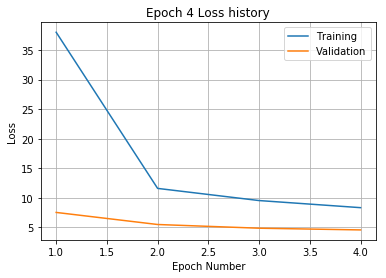

Training
Iteration 0: with minibatch training loss = 6.57 and relative error of 0.28
Iteration 20: with minibatch training loss = 8.35 and relative error of 0.33
Iteration 40: with minibatch training loss = 8.26 and relative error of 0.33
Iteration 60: with minibatch training loss = 9.06 and relative error of 0.34
Iteration 80: with minibatch training loss = 8.11 and relative error of 0.33
Iteration 100: with minibatch training loss = 7.47 and relative error of 0.31
Iteration 120: with minibatch training loss = 10.6 and relative error of 0.36
Iteration 140: with minibatch training loss = 6.22 and relative error of 0.28
Iteration 160: with minibatch training loss = 7.66 and relative error of 0.33
Iteration 180: with minibatch training loss = 6.67 and relative error of 0.3
Iteration 200: with minibatch training loss = 7.09 and relative error of 0.31
Iteration 220: with minibatch training loss = 7.47 and relative error of 0.31
Epoch 5, Overall loss = 7.64, relative error = 0.315, and proc

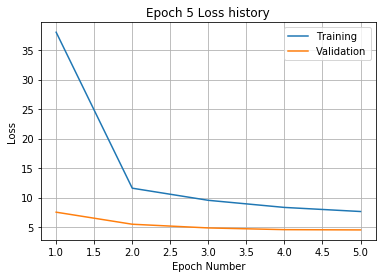

Training
Iteration 0: with minibatch training loss = 6 and relative error of 0.28
Iteration 20: with minibatch training loss = 6.5 and relative error of 0.3
Iteration 40: with minibatch training loss = 7.87 and relative error of 0.32
Iteration 60: with minibatch training loss = 7.16 and relative error of 0.31
Iteration 80: with minibatch training loss = 7.4 and relative error of 0.31
Iteration 100: with minibatch training loss = 5.48 and relative error of 0.27
Iteration 120: with minibatch training loss = 9.43 and relative error of 0.36
Iteration 140: with minibatch training loss = 8.93 and relative error of 0.33
Iteration 160: with minibatch training loss = 7.39 and relative error of 0.31
Iteration 180: with minibatch training loss = 7.11 and relative error of 0.3
Iteration 200: with minibatch training loss = 8.24 and relative error of 0.33
Iteration 220: with minibatch training loss = 6.24 and relative error of 0.28
Epoch 6, Overall loss = 7.18, relative error = 0.305, and process ti

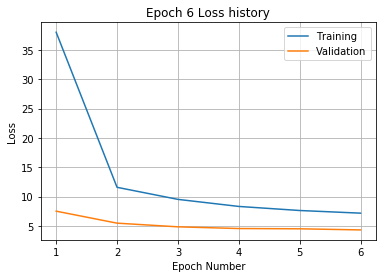

Training
Iteration 0: with minibatch training loss = 9.6 and relative error of 0.35
Iteration 20: with minibatch training loss = 6.37 and relative error of 0.29
Iteration 40: with minibatch training loss = 6.6 and relative error of 0.31
Iteration 60: with minibatch training loss = 5.98 and relative error of 0.27
Iteration 80: with minibatch training loss = 7.77 and relative error of 0.32
Iteration 100: with minibatch training loss = 7.92 and relative error of 0.33
Iteration 120: with minibatch training loss = 5.57 and relative error of 0.27
Iteration 140: with minibatch training loss = 5.43 and relative error of 0.27
Iteration 160: with minibatch training loss = 7.29 and relative error of 0.3
Iteration 180: with minibatch training loss = 6.98 and relative error of 0.3
Iteration 200: with minibatch training loss = 7.36 and relative error of 0.31
Iteration 220: with minibatch training loss = 5.04 and relative error of 0.25
Epoch 7, Overall loss = 6.85, relative error = 0.298, and process

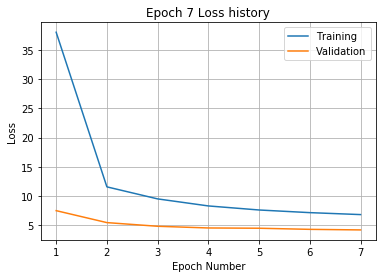

Training
Iteration 0: with minibatch training loss = 5.35 and relative error of 0.26
Iteration 20: with minibatch training loss = 7.3 and relative error of 0.31
Iteration 40: with minibatch training loss = 6.79 and relative error of 0.31
Iteration 60: with minibatch training loss = 5.35 and relative error of 0.26
Iteration 80: with minibatch training loss = 7.99 and relative error of 0.32
Iteration 100: with minibatch training loss = 6.97 and relative error of 0.3
Iteration 120: with minibatch training loss = 3.99 and relative error of 0.24
Iteration 140: with minibatch training loss = 7.55 and relative error of 0.31
Iteration 160: with minibatch training loss = 6.61 and relative error of 0.29
Iteration 180: with minibatch training loss = 7.58 and relative error of 0.32
Iteration 200: with minibatch training loss = 6.12 and relative error of 0.28
Iteration 220: with minibatch training loss = 6.1 and relative error of 0.27
Epoch 8, Overall loss = 6.59, relative error = 0.292, and proces

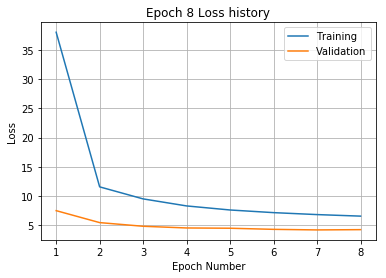

Training
Iteration 0: with minibatch training loss = 5.73 and relative error of 0.27
Iteration 20: with minibatch training loss = 6.43 and relative error of 0.29
Iteration 40: with minibatch training loss = 4.78 and relative error of 0.24
Iteration 60: with minibatch training loss = 6.43 and relative error of 0.28
Iteration 80: with minibatch training loss = 6 and relative error of 0.29
Iteration 100: with minibatch training loss = 5.99 and relative error of 0.28
Iteration 120: with minibatch training loss = 6.41 and relative error of 0.29
Iteration 140: with minibatch training loss = 7.63 and relative error of 0.33
Iteration 160: with minibatch training loss = 6.65 and relative error of 0.3
Iteration 180: with minibatch training loss = 7.18 and relative error of 0.31
Iteration 200: with minibatch training loss = 6.21 and relative error of 0.28
Iteration 220: with minibatch training loss = 5.49 and relative error of 0.26
Epoch 9, Overall loss = 6.36, relative error = 0.287, and process

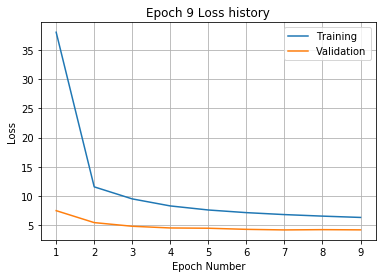

Training
Iteration 0: with minibatch training loss = 7.57 and relative error of 0.31
Iteration 20: with minibatch training loss = 6.71 and relative error of 0.3
Iteration 40: with minibatch training loss = 6.53 and relative error of 0.29
Iteration 60: with minibatch training loss = 5.18 and relative error of 0.26
Iteration 80: with minibatch training loss = 6.74 and relative error of 0.3
Iteration 100: with minibatch training loss = 5.93 and relative error of 0.28
Iteration 120: with minibatch training loss = 6.68 and relative error of 0.3
Iteration 140: with minibatch training loss = 8.25 and relative error of 0.33
Iteration 160: with minibatch training loss = 5.65 and relative error of 0.28
Iteration 180: with minibatch training loss = 5.73 and relative error of 0.28
Iteration 200: with minibatch training loss = 5.17 and relative error of 0.26
Iteration 220: with minibatch training loss = 6.22 and relative error of 0.28
Epoch 10, Overall loss = 6.12, relative error = 0.281, and proce

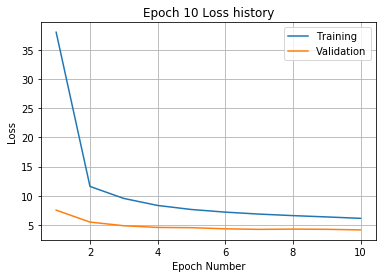

Training
Iteration 0: with minibatch training loss = 7.44 and relative error of 0.32
Iteration 20: with minibatch training loss = 4.86 and relative error of 0.26
Iteration 40: with minibatch training loss = 8.27 and relative error of 0.33
Iteration 60: with minibatch training loss = 4.25 and relative error of 0.23
Iteration 80: with minibatch training loss = 4.3 and relative error of 0.24
Iteration 100: with minibatch training loss = 5.22 and relative error of 0.27
Iteration 120: with minibatch training loss = 6.29 and relative error of 0.28
Iteration 140: with minibatch training loss = 4.9 and relative error of 0.26
Iteration 160: with minibatch training loss = 6.73 and relative error of 0.29
Iteration 180: with minibatch training loss = 5.33 and relative error of 0.26
Iteration 200: with minibatch training loss = 5.15 and relative error of 0.26
Iteration 220: with minibatch training loss = 7.96 and relative error of 0.33
Epoch 11, Overall loss = 5.94, relative error = 0.277, and proc

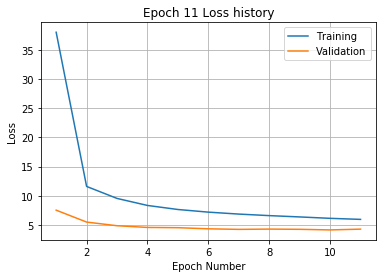

Training
Iteration 0: with minibatch training loss = 5.02 and relative error of 0.26
Iteration 20: with minibatch training loss = 4.91 and relative error of 0.26
Iteration 40: with minibatch training loss = 6.36 and relative error of 0.28
Iteration 60: with minibatch training loss = 4.81 and relative error of 0.25
Iteration 80: with minibatch training loss = 6.58 and relative error of 0.31
Iteration 100: with minibatch training loss = 7.29 and relative error of 0.33
Iteration 120: with minibatch training loss = 5.2 and relative error of 0.27
Iteration 140: with minibatch training loss = 6.05 and relative error of 0.27
Iteration 160: with minibatch training loss = 5.07 and relative error of 0.26
Iteration 180: with minibatch training loss = 4.9 and relative error of 0.26
Iteration 200: with minibatch training loss = 6.36 and relative error of 0.28
Iteration 220: with minibatch training loss = 5.72 and relative error of 0.28
Epoch 12, Overall loss = 5.81, relative error = 0.274, and proc

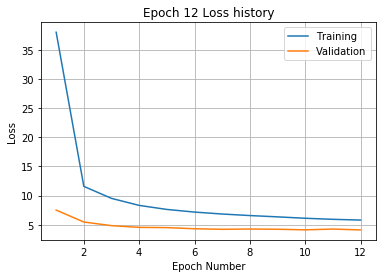

Training
Iteration 0: with minibatch training loss = 6.04 and relative error of 0.28
Iteration 20: with minibatch training loss = 4.71 and relative error of 0.24
Iteration 40: with minibatch training loss = 5.53 and relative error of 0.27
Iteration 60: with minibatch training loss = 5.02 and relative error of 0.26
Iteration 80: with minibatch training loss = 4.71 and relative error of 0.26
Iteration 100: with minibatch training loss = 5.39 and relative error of 0.28
Iteration 120: with minibatch training loss = 5.73 and relative error of 0.27
Iteration 140: with minibatch training loss = 6.66 and relative error of 0.31
Iteration 160: with minibatch training loss = 5.14 and relative error of 0.26
Iteration 180: with minibatch training loss = 4.86 and relative error of 0.26
Iteration 200: with minibatch training loss = 3.45 and relative error of 0.21
Iteration 220: with minibatch training loss = 6.02 and relative error of 0.28
Epoch 13, Overall loss = 5.65, relative error = 0.27, and pro

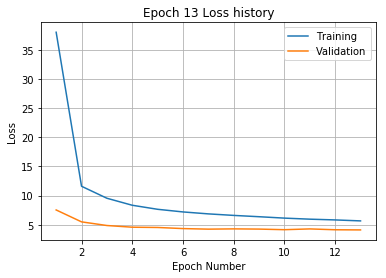

Training
Iteration 0: with minibatch training loss = 4.42 and relative error of 0.25
Iteration 20: with minibatch training loss = 6.34 and relative error of 0.29
Iteration 40: with minibatch training loss = 5.67 and relative error of 0.27
Iteration 60: with minibatch training loss = 6.36 and relative error of 0.29
Iteration 80: with minibatch training loss = 5.5 and relative error of 0.27
Iteration 100: with minibatch training loss = 4.11 and relative error of 0.23
Iteration 120: with minibatch training loss = 5.76 and relative error of 0.28
Iteration 140: with minibatch training loss = 3.74 and relative error of 0.22
Iteration 160: with minibatch training loss = 4.25 and relative error of 0.23
Iteration 180: with minibatch training loss = 4.36 and relative error of 0.23
Iteration 200: with minibatch training loss = 5.53 and relative error of 0.28
Iteration 220: with minibatch training loss = 6.86 and relative error of 0.3
Epoch 14, Overall loss = 5.53, relative error = 0.268, and proc

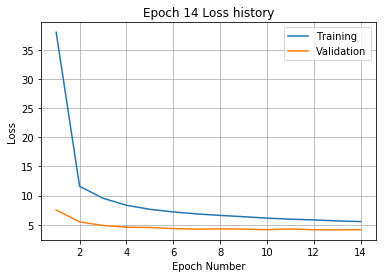

Training
Iteration 0: with minibatch training loss = 5.04 and relative error of 0.25
Iteration 20: with minibatch training loss = 7.22 and relative error of 0.3
Iteration 40: with minibatch training loss = 5.84 and relative error of 0.28
Iteration 60: with minibatch training loss = 4.31 and relative error of 0.23
Iteration 80: with minibatch training loss = 3.77 and relative error of 0.22
Iteration 100: with minibatch training loss = 6.27 and relative error of 0.29
Iteration 120: with minibatch training loss = 6.59 and relative error of 0.29
Iteration 140: with minibatch training loss = 3.53 and relative error of 0.22
Iteration 160: with minibatch training loss = 5.45 and relative error of 0.27
Iteration 180: with minibatch training loss = 4.01 and relative error of 0.23
Iteration 200: with minibatch training loss = 5.86 and relative error of 0.27
Iteration 220: with minibatch training loss = 4.16 and relative error of 0.23
Epoch 15, Overall loss = 5.42, relative error = 0.265, and pro

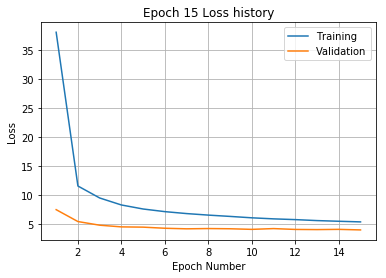

Training
Iteration 0: with minibatch training loss = 4.23 and relative error of 0.24
Iteration 20: with minibatch training loss = 6.08 and relative error of 0.28
Iteration 40: with minibatch training loss = 5.02 and relative error of 0.27
Iteration 60: with minibatch training loss = 3.35 and relative error of 0.2
Iteration 80: with minibatch training loss = 5.68 and relative error of 0.27
Iteration 100: with minibatch training loss = 6.91 and relative error of 0.3
Iteration 120: with minibatch training loss = 4.71 and relative error of 0.24
Iteration 140: with minibatch training loss = 3.98 and relative error of 0.22
Iteration 160: with minibatch training loss = 5.52 and relative error of 0.27
Iteration 180: with minibatch training loss = 4.5 and relative error of 0.24
Iteration 200: with minibatch training loss = 4.45 and relative error of 0.24
Iteration 220: with minibatch training loss = 4.41 and relative error of 0.24
Epoch 16, Overall loss = 5.3, relative error = 0.262, and proces

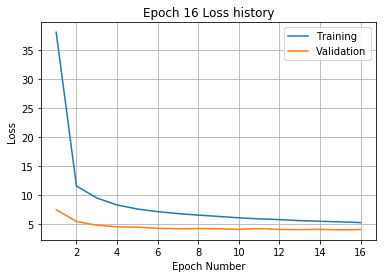

Training
Iteration 0: with minibatch training loss = 4.84 and relative error of 0.26
Iteration 20: with minibatch training loss = 4.9 and relative error of 0.25
Iteration 40: with minibatch training loss = 5.78 and relative error of 0.27
Iteration 60: with minibatch training loss = 5.86 and relative error of 0.28
Iteration 80: with minibatch training loss = 7.24 and relative error of 0.31
Iteration 100: with minibatch training loss = 5.22 and relative error of 0.26
Iteration 120: with minibatch training loss = 4.69 and relative error of 0.25
Iteration 140: with minibatch training loss = 3.7 and relative error of 0.22
Iteration 160: with minibatch training loss = 6.06 and relative error of 0.28
Iteration 180: with minibatch training loss = 4.71 and relative error of 0.26
Iteration 200: with minibatch training loss = 4.24 and relative error of 0.23
Iteration 220: with minibatch training loss = 5.21 and relative error of 0.25
Epoch 17, Overall loss = 5.13, relative error = 0.258, and proc

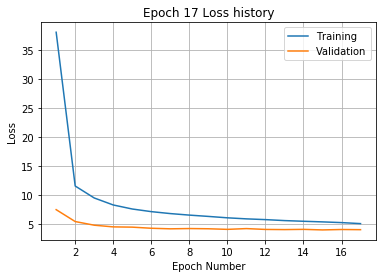

Training
Iteration 0: with minibatch training loss = 4.43 and relative error of 0.24
Iteration 20: with minibatch training loss = 4.5 and relative error of 0.24
Iteration 40: with minibatch training loss = 4.14 and relative error of 0.23
Iteration 60: with minibatch training loss = 4.26 and relative error of 0.23
Iteration 80: with minibatch training loss = 4.79 and relative error of 0.25
Iteration 100: with minibatch training loss = 3.61 and relative error of 0.22
Iteration 120: with minibatch training loss = 5.46 and relative error of 0.26
Iteration 140: with minibatch training loss = 5.85 and relative error of 0.27
Iteration 160: with minibatch training loss = 6.46 and relative error of 0.29
Iteration 180: with minibatch training loss = 5.05 and relative error of 0.26
Iteration 200: with minibatch training loss = 4.33 and relative error of 0.24
Iteration 220: with minibatch training loss = 5.37 and relative error of 0.27
Epoch 18, Overall loss = 5.12, relative error = 0.257, and pro

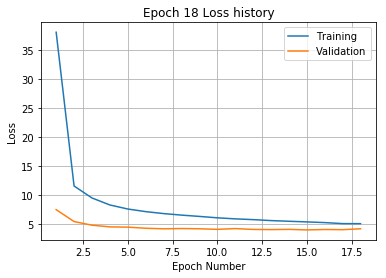

Training
Iteration 0: with minibatch training loss = 5.74 and relative error of 0.27
Iteration 20: with minibatch training loss = 6.47 and relative error of 0.27
Iteration 40: with minibatch training loss = 4.99 and relative error of 0.25
Iteration 60: with minibatch training loss = 4.54 and relative error of 0.24
Iteration 80: with minibatch training loss = 5.27 and relative error of 0.26
Iteration 100: with minibatch training loss = 7.32 and relative error of 0.3
Iteration 120: with minibatch training loss = 4.96 and relative error of 0.25
Iteration 140: with minibatch training loss = 4.87 and relative error of 0.25
Iteration 160: with minibatch training loss = 4.23 and relative error of 0.24
Iteration 180: with minibatch training loss = 4.28 and relative error of 0.24
Iteration 200: with minibatch training loss = 4.66 and relative error of 0.24
Iteration 220: with minibatch training loss = 4.61 and relative error of 0.24
Epoch 19, Overall loss = 5, relative error = 0.254, and proces

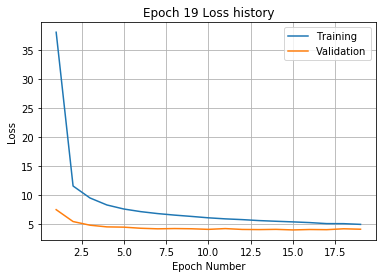

Training
Iteration 0: with minibatch training loss = 3.69 and relative error of 0.22
Iteration 20: with minibatch training loss = 5.74 and relative error of 0.27
Iteration 40: with minibatch training loss = 5.27 and relative error of 0.26
Iteration 60: with minibatch training loss = 3.76 and relative error of 0.22
Iteration 80: with minibatch training loss = 4.9 and relative error of 0.25
Iteration 100: with minibatch training loss = 3.63 and relative error of 0.21
Iteration 120: with minibatch training loss = 5.04 and relative error of 0.25
Iteration 140: with minibatch training loss = 5.46 and relative error of 0.26
Iteration 160: with minibatch training loss = 3.72 and relative error of 0.23
Iteration 180: with minibatch training loss = 4.37 and relative error of 0.24
Iteration 200: with minibatch training loss = 3.81 and relative error of 0.23
Iteration 220: with minibatch training loss = 6.17 and relative error of 0.27
Epoch 20, Overall loss = 4.94, relative error = 0.253, and pro

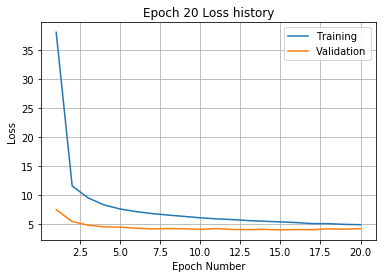

Validation error has stopped improving! Training on repetition 9 stopped!
Training
Iteration 0: with minibatch training loss = 199 and relative error of 1.6
Iteration 20: with minibatch training loss = 107 and relative error of 1.2
Iteration 40: with minibatch training loss = 68.3 and relative error of 0.96
Iteration 60: with minibatch training loss = 55 and relative error of 0.84
Iteration 80: with minibatch training loss = 40.3 and relative error of 0.74
Iteration 100: with minibatch training loss = 27 and relative error of 0.62
Iteration 120: with minibatch training loss = 23.9 and relative error of 0.56
Iteration 140: with minibatch training loss = 20 and relative error of 0.52
Iteration 160: with minibatch training loss = 18.6 and relative error of 0.51
Iteration 180: with minibatch training loss = 13.4 and relative error of 0.41
Iteration 200: with minibatch training loss = 15.3 and relative error of 0.44
Iteration 220: with minibatch training loss = 13.9 and relative error of 0.

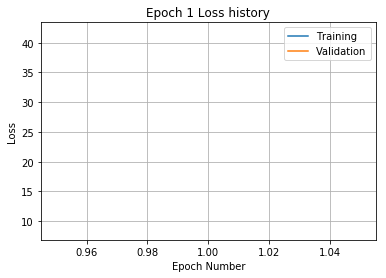

Training
Iteration 0: with minibatch training loss = 14.3 and relative error of 0.45
Iteration 20: with minibatch training loss = 14.5 and relative error of 0.43
Iteration 40: with minibatch training loss = 13.6 and relative error of 0.42
Iteration 60: with minibatch training loss = 14.9 and relative error of 0.44
Iteration 80: with minibatch training loss = 12.9 and relative error of 0.41
Iteration 100: with minibatch training loss = 11.4 and relative error of 0.39
Iteration 120: with minibatch training loss = 13.1 and relative error of 0.41
Iteration 140: with minibatch training loss = 14.6 and relative error of 0.43
Iteration 160: with minibatch training loss = 9.31 and relative error of 0.35
Iteration 180: with minibatch training loss = 11 and relative error of 0.39
Iteration 200: with minibatch training loss = 10.6 and relative error of 0.37
Iteration 220: with minibatch training loss = 10.7 and relative error of 0.37
Epoch 2, Overall loss = 12.1, relative error = 0.398, and proce

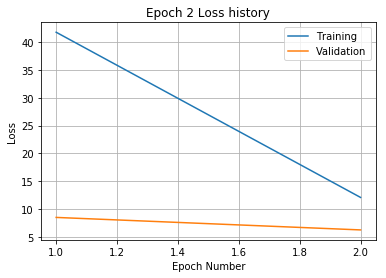

Training
Iteration 0: with minibatch training loss = 9.41 and relative error of 0.34
Iteration 20: with minibatch training loss = 13.3 and relative error of 0.41
Iteration 40: with minibatch training loss = 10.3 and relative error of 0.36
Iteration 60: with minibatch training loss = 10.8 and relative error of 0.38
Iteration 80: with minibatch training loss = 8.82 and relative error of 0.33
Iteration 100: with minibatch training loss = 9.62 and relative error of 0.35
Iteration 120: with minibatch training loss = 12.1 and relative error of 0.38
Iteration 140: with minibatch training loss = 10.1 and relative error of 0.36
Iteration 160: with minibatch training loss = 10.2 and relative error of 0.36
Iteration 180: with minibatch training loss = 9.85 and relative error of 0.35
Iteration 200: with minibatch training loss = 9.82 and relative error of 0.35
Iteration 220: with minibatch training loss = 11.6 and relative error of 0.39
Epoch 3, Overall loss = 9.89, relative error = 0.36, and proc

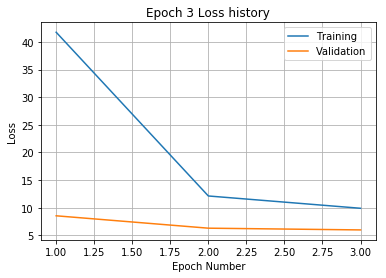

Training
Iteration 0: with minibatch training loss = 8.3 and relative error of 0.33
Iteration 20: with minibatch training loss = 9.81 and relative error of 0.36
Iteration 40: with minibatch training loss = 9.15 and relative error of 0.35
Iteration 60: with minibatch training loss = 7.76 and relative error of 0.32
Iteration 80: with minibatch training loss = 6.96 and relative error of 0.31
Iteration 100: with minibatch training loss = 9.01 and relative error of 0.35
Iteration 120: with minibatch training loss = 8.68 and relative error of 0.34
Iteration 140: with minibatch training loss = 8.21 and relative error of 0.32
Iteration 160: with minibatch training loss = 7.64 and relative error of 0.33
Iteration 180: with minibatch training loss = 9.7 and relative error of 0.37
Iteration 200: with minibatch training loss = 8.06 and relative error of 0.33
Iteration 220: with minibatch training loss = 10.1 and relative error of 0.36
Epoch 4, Overall loss = 8.71, relative error = 0.338, and proce

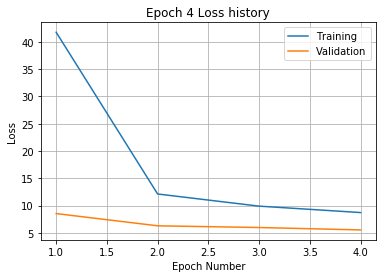

Training
Iteration 0: with minibatch training loss = 7.16 and relative error of 0.29
Iteration 20: with minibatch training loss = 9.24 and relative error of 0.35
Iteration 40: with minibatch training loss = 6.31 and relative error of 0.29
Iteration 60: with minibatch training loss = 6.46 and relative error of 0.29
Iteration 80: with minibatch training loss = 9.46 and relative error of 0.36
Iteration 100: with minibatch training loss = 9.3 and relative error of 0.36
Iteration 120: with minibatch training loss = 8.53 and relative error of 0.33
Iteration 140: with minibatch training loss = 9.91 and relative error of 0.35
Iteration 160: with minibatch training loss = 8.16 and relative error of 0.33
Iteration 180: with minibatch training loss = 7.3 and relative error of 0.31
Iteration 200: with minibatch training loss = 10.8 and relative error of 0.39
Iteration 220: with minibatch training loss = 7.62 and relative error of 0.33
Epoch 5, Overall loss = 8.03, relative error = 0.324, and proce

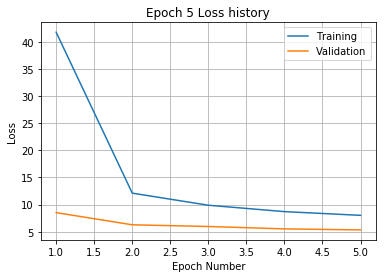

Training
Iteration 0: with minibatch training loss = 5.98 and relative error of 0.28
Iteration 20: with minibatch training loss = 8.49 and relative error of 0.35
Iteration 40: with minibatch training loss = 9.34 and relative error of 0.36
Iteration 60: with minibatch training loss = 6.11 and relative error of 0.27
Iteration 80: with minibatch training loss = 7.63 and relative error of 0.31
Iteration 100: with minibatch training loss = 8.9 and relative error of 0.33
Iteration 120: with minibatch training loss = 7.46 and relative error of 0.32
Iteration 140: with minibatch training loss = 6.46 and relative error of 0.3
Iteration 160: with minibatch training loss = 8.47 and relative error of 0.34
Iteration 180: with minibatch training loss = 7.23 and relative error of 0.3
Iteration 200: with minibatch training loss = 6.79 and relative error of 0.3
Iteration 220: with minibatch training loss = 5.67 and relative error of 0.28
Epoch 6, Overall loss = 7.38, relative error = 0.31, and process 

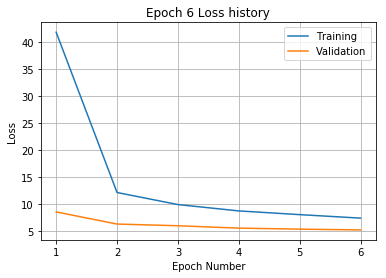

Training
Iteration 0: with minibatch training loss = 5.72 and relative error of 0.27
Iteration 20: with minibatch training loss = 7.25 and relative error of 0.31
Iteration 40: with minibatch training loss = 8.54 and relative error of 0.34
Iteration 60: with minibatch training loss = 9.42 and relative error of 0.35
Iteration 80: with minibatch training loss = 6.5 and relative error of 0.31
Iteration 100: with minibatch training loss = 8.41 and relative error of 0.34
Iteration 120: with minibatch training loss = 5.35 and relative error of 0.27
Iteration 140: with minibatch training loss = 9.09 and relative error of 0.35
Iteration 160: with minibatch training loss = 6.86 and relative error of 0.31
Iteration 180: with minibatch training loss = 7.16 and relative error of 0.29
Iteration 200: with minibatch training loss = 7.12 and relative error of 0.3
Iteration 220: with minibatch training loss = 6.58 and relative error of 0.3
Epoch 7, Overall loss = 7.02, relative error = 0.303, and proces

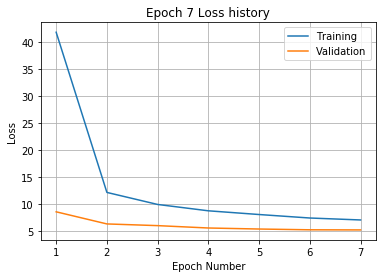

Training
Iteration 0: with minibatch training loss = 7.86 and relative error of 0.32
Iteration 20: with minibatch training loss = 7.38 and relative error of 0.3
Iteration 40: with minibatch training loss = 6.65 and relative error of 0.29
Iteration 60: with minibatch training loss = 9.33 and relative error of 0.33
Iteration 80: with minibatch training loss = 6.69 and relative error of 0.28
Iteration 100: with minibatch training loss = 5.18 and relative error of 0.27
Iteration 120: with minibatch training loss = 5.9 and relative error of 0.27
Iteration 140: with minibatch training loss = 8.38 and relative error of 0.32
Iteration 160: with minibatch training loss = 4.72 and relative error of 0.25
Iteration 180: with minibatch training loss = 4.51 and relative error of 0.24
Iteration 200: with minibatch training loss = 6.73 and relative error of 0.29
Iteration 220: with minibatch training loss = 4.77 and relative error of 0.26
Epoch 8, Overall loss = 6.67, relative error = 0.295, and proce

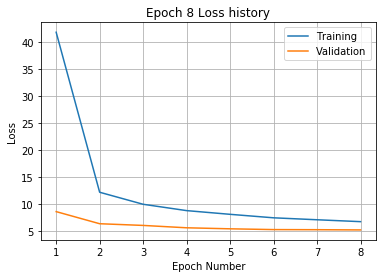

Training
Iteration 0: with minibatch training loss = 6.9 and relative error of 0.3
Iteration 20: with minibatch training loss = 6.42 and relative error of 0.29
Iteration 40: with minibatch training loss = 7.84 and relative error of 0.32
Iteration 60: with minibatch training loss = 5.73 and relative error of 0.27
Iteration 80: with minibatch training loss = 5.67 and relative error of 0.27
Iteration 100: with minibatch training loss = 6.69 and relative error of 0.29
Iteration 120: with minibatch training loss = 6.26 and relative error of 0.28
Iteration 140: with minibatch training loss = 6.22 and relative error of 0.3
Iteration 160: with minibatch training loss = 6.86 and relative error of 0.31
Iteration 180: with minibatch training loss = 6.16 and relative error of 0.29
Iteration 200: with minibatch training loss = 5.56 and relative error of 0.26
Iteration 220: with minibatch training loss = 5.35 and relative error of 0.27
Epoch 9, Overall loss = 6.41, relative error = 0.289, and proces

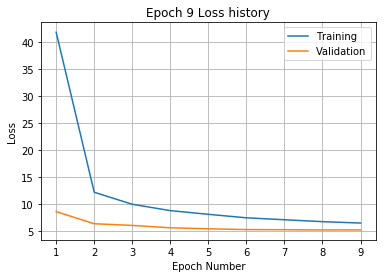

Training
Iteration 0: with minibatch training loss = 6.45 and relative error of 0.29
Iteration 20: with minibatch training loss = 8.08 and relative error of 0.32
Iteration 40: with minibatch training loss = 5.41 and relative error of 0.27
Iteration 60: with minibatch training loss = 5 and relative error of 0.26
Iteration 80: with minibatch training loss = 5.99 and relative error of 0.29
Iteration 100: with minibatch training loss = 5.05 and relative error of 0.25
Iteration 120: with minibatch training loss = 6.23 and relative error of 0.28
Iteration 140: with minibatch training loss = 4.19 and relative error of 0.23
Iteration 160: with minibatch training loss = 6.1 and relative error of 0.27
Iteration 180: with minibatch training loss = 8.34 and relative error of 0.34
Iteration 200: with minibatch training loss = 7.07 and relative error of 0.31
Iteration 220: with minibatch training loss = 5.75 and relative error of 0.28
Epoch 10, Overall loss = 6.23, relative error = 0.285, and proces

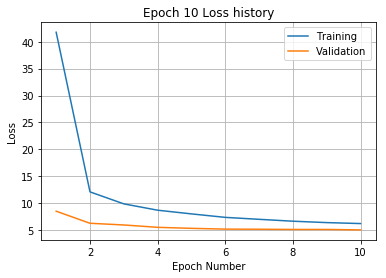

Training
Iteration 0: with minibatch training loss = 4.9 and relative error of 0.25
Iteration 20: with minibatch training loss = 6.9 and relative error of 0.31
Iteration 40: with minibatch training loss = 5.82 and relative error of 0.27
Iteration 60: with minibatch training loss = 6.56 and relative error of 0.3
Iteration 80: with minibatch training loss = 9.27 and relative error of 0.33
Iteration 100: with minibatch training loss = 6.82 and relative error of 0.31
Iteration 120: with minibatch training loss = 4.69 and relative error of 0.25
Iteration 140: with minibatch training loss = 7.76 and relative error of 0.32
Iteration 160: with minibatch training loss = 5.31 and relative error of 0.27
Iteration 180: with minibatch training loss = 6.62 and relative error of 0.3
Iteration 200: with minibatch training loss = 3.8 and relative error of 0.22
Iteration 220: with minibatch training loss = 4.69 and relative error of 0.25
Epoch 11, Overall loss = 6.06, relative error = 0.281, and process

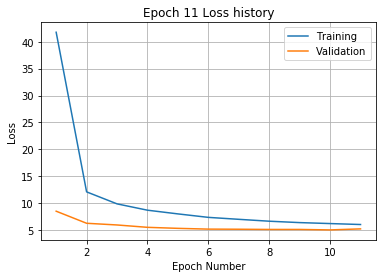

Training
Iteration 0: with minibatch training loss = 6.8 and relative error of 0.29
Iteration 20: with minibatch training loss = 4.94 and relative error of 0.26
Iteration 40: with minibatch training loss = 7.2 and relative error of 0.3
Iteration 60: with minibatch training loss = 6.5 and relative error of 0.29
Iteration 80: with minibatch training loss = 7.37 and relative error of 0.31
Iteration 100: with minibatch training loss = 6.24 and relative error of 0.28
Iteration 120: with minibatch training loss = 4.91 and relative error of 0.25
Iteration 140: with minibatch training loss = 4.7 and relative error of 0.25
Iteration 160: with minibatch training loss = 4.58 and relative error of 0.24
Iteration 180: with minibatch training loss = 6.83 and relative error of 0.32
Iteration 200: with minibatch training loss = 5.77 and relative error of 0.27
Iteration 220: with minibatch training loss = 6.27 and relative error of 0.29
Epoch 12, Overall loss = 5.85, relative error = 0.276, and process

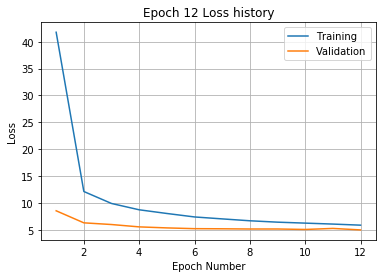

Training
Iteration 0: with minibatch training loss = 4.32 and relative error of 0.24
Iteration 20: with minibatch training loss = 6.07 and relative error of 0.28
Iteration 40: with minibatch training loss = 5.05 and relative error of 0.27
Iteration 60: with minibatch training loss = 6.06 and relative error of 0.27
Iteration 80: with minibatch training loss = 6.3 and relative error of 0.28
Iteration 100: with minibatch training loss = 5.12 and relative error of 0.26
Iteration 120: with minibatch training loss = 6.35 and relative error of 0.29
Iteration 140: with minibatch training loss = 5.44 and relative error of 0.26
Iteration 160: with minibatch training loss = 6.17 and relative error of 0.28
Iteration 180: with minibatch training loss = 5.42 and relative error of 0.27
Iteration 200: with minibatch training loss = 4.3 and relative error of 0.25
Iteration 220: with minibatch training loss = 4.41 and relative error of 0.25
Epoch 13, Overall loss = 5.73, relative error = 0.273, and proc

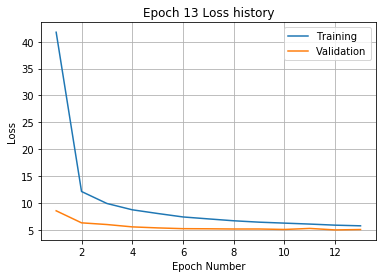

Training
Iteration 0: with minibatch training loss = 5.43 and relative error of 0.26
Iteration 20: with minibatch training loss = 7.72 and relative error of 0.32
Iteration 40: with minibatch training loss = 5.71 and relative error of 0.28
Iteration 60: with minibatch training loss = 3.83 and relative error of 0.22
Iteration 80: with minibatch training loss = 5.95 and relative error of 0.28
Iteration 100: with minibatch training loss = 6.02 and relative error of 0.29
Iteration 120: with minibatch training loss = 6.04 and relative error of 0.27
Iteration 140: with minibatch training loss = 5.89 and relative error of 0.27
Iteration 160: with minibatch training loss = 4.41 and relative error of 0.24
Iteration 180: with minibatch training loss = 5.64 and relative error of 0.28
Iteration 200: with minibatch training loss = 5.61 and relative error of 0.27
Iteration 220: with minibatch training loss = 4.92 and relative error of 0.25
Epoch 14, Overall loss = 5.58, relative error = 0.27, and pro

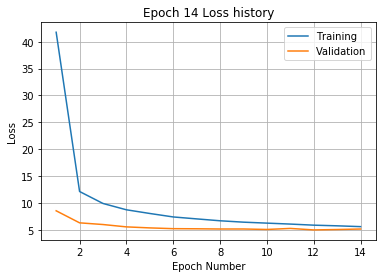

Training
Iteration 0: with minibatch training loss = 3.6 and relative error of 0.22
Iteration 20: with minibatch training loss = 4.72 and relative error of 0.25
Iteration 40: with minibatch training loss = 7.44 and relative error of 0.31
Iteration 60: with minibatch training loss = 4.54 and relative error of 0.24
Iteration 80: with minibatch training loss = 5.83 and relative error of 0.27
Iteration 100: with minibatch training loss = 4.34 and relative error of 0.25
Iteration 120: with minibatch training loss = 4.65 and relative error of 0.24
Iteration 140: with minibatch training loss = 3.68 and relative error of 0.22
Iteration 160: with minibatch training loss = 3.88 and relative error of 0.23
Iteration 180: with minibatch training loss = 3.48 and relative error of 0.21
Iteration 200: with minibatch training loss = 7.5 and relative error of 0.31
Iteration 220: with minibatch training loss = 7.65 and relative error of 0.32
Epoch 15, Overall loss = 5.49, relative error = 0.267, and proc

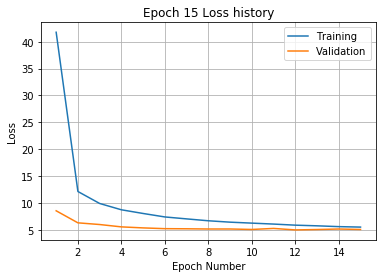

Training
Iteration 0: with minibatch training loss = 6.15 and relative error of 0.28
Iteration 20: with minibatch training loss = 4.7 and relative error of 0.26
Iteration 40: with minibatch training loss = 7.12 and relative error of 0.3
Iteration 60: with minibatch training loss = 5.21 and relative error of 0.26
Iteration 80: with minibatch training loss = 6.61 and relative error of 0.28
Iteration 100: with minibatch training loss = 7.97 and relative error of 0.33
Iteration 120: with minibatch training loss = 8.67 and relative error of 0.32
Iteration 140: with minibatch training loss = 3.45 and relative error of 0.21
Iteration 160: with minibatch training loss = 4.18 and relative error of 0.23
Iteration 180: with minibatch training loss = 5.67 and relative error of 0.27
Iteration 200: with minibatch training loss = 6.4 and relative error of 0.3
Iteration 220: with minibatch training loss = 4.71 and relative error of 0.25
Epoch 16, Overall loss = 5.34, relative error = 0.264, and proces

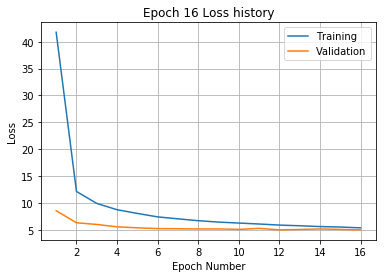

Training
Iteration 0: with minibatch training loss = 4.87 and relative error of 0.26
Iteration 20: with minibatch training loss = 5.51 and relative error of 0.27
Iteration 40: with minibatch training loss = 4.46 and relative error of 0.25
Iteration 60: with minibatch training loss = 4.15 and relative error of 0.23
Iteration 80: with minibatch training loss = 4.98 and relative error of 0.26
Iteration 100: with minibatch training loss = 4.32 and relative error of 0.23
Iteration 120: with minibatch training loss = 5.13 and relative error of 0.26
Iteration 140: with minibatch training loss = 6.32 and relative error of 0.29
Iteration 160: with minibatch training loss = 7.19 and relative error of 0.31
Iteration 180: with minibatch training loss = 5.21 and relative error of 0.26
Iteration 200: with minibatch training loss = 4.96 and relative error of 0.25
Iteration 220: with minibatch training loss = 5.2 and relative error of 0.26
Epoch 17, Overall loss = 5.22, relative error = 0.261, and pro

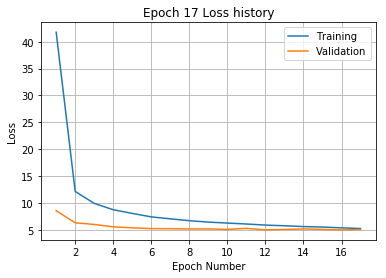

Training
Iteration 0: with minibatch training loss = 4.78 and relative error of 0.25
Iteration 20: with minibatch training loss = 3.79 and relative error of 0.23
Iteration 40: with minibatch training loss = 5.27 and relative error of 0.26
Iteration 60: with minibatch training loss = 6.34 and relative error of 0.28
Iteration 80: with minibatch training loss = 5.28 and relative error of 0.27
Iteration 100: with minibatch training loss = 5.43 and relative error of 0.27
Iteration 120: with minibatch training loss = 5.81 and relative error of 0.28
Iteration 140: with minibatch training loss = 6.27 and relative error of 0.29
Iteration 160: with minibatch training loss = 5.32 and relative error of 0.26
Iteration 180: with minibatch training loss = 3.52 and relative error of 0.22
Iteration 200: with minibatch training loss = 4.24 and relative error of 0.24
Iteration 220: with minibatch training loss = 5.05 and relative error of 0.25
Epoch 18, Overall loss = 5.1, relative error = 0.258, and pro

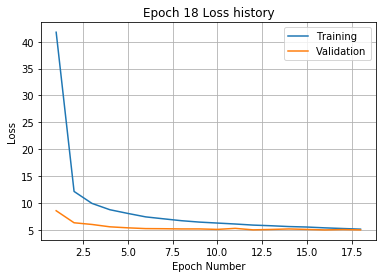

Training
Iteration 0: with minibatch training loss = 4.61 and relative error of 0.25
Iteration 20: with minibatch training loss = 4.16 and relative error of 0.24
Iteration 40: with minibatch training loss = 4.29 and relative error of 0.24
Iteration 60: with minibatch training loss = 8.18 and relative error of 0.35
Iteration 80: with minibatch training loss = 4.6 and relative error of 0.24
Iteration 100: with minibatch training loss = 5.83 and relative error of 0.28
Iteration 120: with minibatch training loss = 5.4 and relative error of 0.27
Iteration 140: with minibatch training loss = 4.1 and relative error of 0.24
Iteration 160: with minibatch training loss = 4.34 and relative error of 0.24
Iteration 180: with minibatch training loss = 3.58 and relative error of 0.22
Iteration 200: with minibatch training loss = 5.6 and relative error of 0.28
Iteration 220: with minibatch training loss = 5.46 and relative error of 0.26
Epoch 19, Overall loss = 5.08, relative error = 0.257, and proces

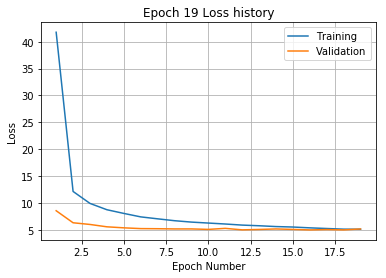

Training
Iteration 0: with minibatch training loss = 5.46 and relative error of 0.27
Iteration 20: with minibatch training loss = 5.89 and relative error of 0.28
Iteration 40: with minibatch training loss = 5.26 and relative error of 0.27
Iteration 60: with minibatch training loss = 5.52 and relative error of 0.27
Iteration 80: with minibatch training loss = 5.42 and relative error of 0.27
Iteration 100: with minibatch training loss = 5.03 and relative error of 0.25
Iteration 120: with minibatch training loss = 4.32 and relative error of 0.24
Iteration 140: with minibatch training loss = 4.53 and relative error of 0.25
Iteration 160: with minibatch training loss = 6.22 and relative error of 0.29
Iteration 180: with minibatch training loss = 3.49 and relative error of 0.22
Iteration 200: with minibatch training loss = 5.15 and relative error of 0.26
Iteration 220: with minibatch training loss = 5.08 and relative error of 0.26
Epoch 20, Overall loss = 4.9, relative error = 0.252, and pro

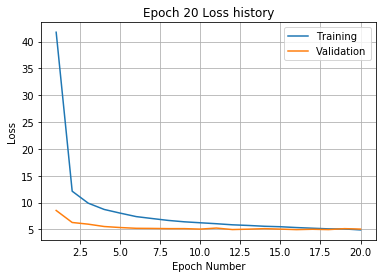

Training
Iteration 0: with minibatch training loss = 3.54 and relative error of 0.21
Iteration 20: with minibatch training loss = 5.55 and relative error of 0.26
Iteration 40: with minibatch training loss = 6.04 and relative error of 0.29
Iteration 60: with minibatch training loss = 5.01 and relative error of 0.27
Iteration 80: with minibatch training loss = 5.22 and relative error of 0.26
Iteration 100: with minibatch training loss = 4.85 and relative error of 0.24
Iteration 120: with minibatch training loss = 3.01 and relative error of 0.2
Iteration 140: with minibatch training loss = 4.92 and relative error of 0.24
Iteration 160: with minibatch training loss = 6.06 and relative error of 0.27
Iteration 180: with minibatch training loss = 6.84 and relative error of 0.3
Iteration 200: with minibatch training loss = 4.54 and relative error of 0.26
Iteration 220: with minibatch training loss = 5.43 and relative error of 0.27
Epoch 21, Overall loss = 4.84, relative error = 0.251, and proc

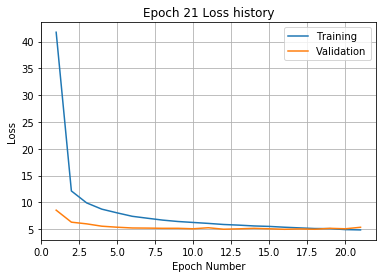

Validation error has stopped improving! Training on repetition 10 stopped!


In [5]:
# Create a list of variables and a list of data. They must have strict correspondence
Xy_var = [x_var, x2_var, y_var]
data_trainval = [images_trainval,pv_log_trainval,pv_pred_trainval]

# Run training process
save_path,training_history = run_training(num_rep, num_epochs, plotting, output_folder, model_name,"/gpu:0",
                                          Xy_var, is_training, loss_var, rel_err_var, train_step, data_trainval, 
                                          batch_size = batch_size)
                                          

# unpack the training history cache    
train_loss_hist,train_error_hist,val_loss_hist,val_error_hist = training_history

np.save(os.path.join(output_folder, "train_loss.npy"), train_loss_hist)
np.save(os.path.join(output_folder, "train_error.npy"), train_error_hist)
np.save(os.path.join(output_folder, "val_loss.npy"), val_loss_hist)
np.save(os.path.join(output_folder, "val_error.npy"), val_error_hist)


In [6]:
# load PV output and images for the test
pv_log_test = np.load(pv_log_test_path)
images_test = np.load(image_log_test_path)
pv_pred_test = np.load(pv_pred_test_path)
times_test = np.load(os.path.join(times_test_path))

# stack up the log and color channels into a unified dimension
images_test = images_test.transpose((0,2,3,4,1))
images_test = images_test.reshape((images_test.shape[0],images_test.shape[1],images_test.shape[2],-1))

In [7]:
#Find the index of the first rainy day.
first_cloudy_idx = find_idx_with_dates(times_test, [first_cloudy_test])[0]

# Find the MSE of the persistence model on trainval set
pers_mse_trainval = np.mean(np.square(pv_pred_trainval - pv_log_trainval[:,0]))
pers_mse_test = np.mean(np.square(pv_pred_test - pv_log_test[:,0]))
print('Persistence MSE of the trainval set: {0:.2f},test set: {1:.2f}'.format(pers_mse_trainval,pers_mse_test))

# Find the MSE of the persistence model on test set
pers_mse_sunny_test = np.mean(np.square(pv_pred_test - pv_log_test[:,0])[:first_cloudy_idx])
pers_mse_cloudy_test = np.mean(np.square(pv_pred_test - pv_log_test[:,0])[first_cloudy_idx:])
print('Persistence MSE of the sunny test set: {0:.2f},cloudy test set: {1:.2f}'
      .format(pers_mse_sunny_test,pers_mse_cloudy_test))

Persistence MSE of the trainval set: 6.35,test set: 9.64
Persistence MSE of the sunny test set: 5.51,cloudy test set: 13.79


In [2]:
def find_best_loss(output_folder):
    # Restore error history
    train_loss = np.load(os.path.join(output_folder,"train_loss.npy"))
    val_loss = np.load(os.path.join(output_folder,"val_loss.npy"))
    
    num_rep = val_loss.shape[0]
    
    # Only obtain results for best model
    best_idx = np.zeros(num_rep,dtype =int)
    for i in range(num_rep):
        best_idx[i] = np.argmin(val_loss[i][val_loss[i]>0])

    train_best = train_loss[np.arange(num_rep),best_idx] 
    val_best = val_loss[np.arange(num_rep),best_idx]
    
    return [train_best,val_best]

In [4]:
pers_mse_trainval = 6.35

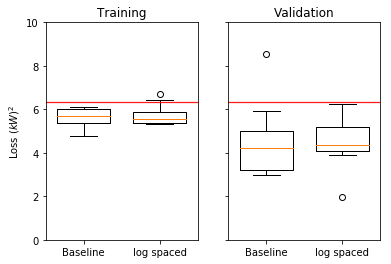

In [5]:
# Compare the training and validation loss boxchart with baseline model

baseline_model_name = 'CNN_1.0_Baseline'
output_folder_baseline = os.path.join('models',baseline_model_name)

best_loss_baseline = find_best_loss(output_folder_baseline)
best_loss_curr = find_best_loss(output_folder)

# Compare the rRMSE between this model and baseline model
f,axarr = plt.subplots(1,2,sharey = True)
set_name = ['Training','Validation']
model_label = ['Baseline','log spaced']

for i in range(len(axarr)):
    axarr[i].boxplot(np.vstack((best_loss_baseline[i],best_loss_curr[i])).T,
                     labels = model_label,widths = 0.7)
    
    axarr[i].set_title(set_name[i])
    axarr[i].grid(False)
    axarr[i].axhline(y=pers_mse_trainval,color= 'r',linewidth =1.25, alpha = 0.9)

axarr[0].set_ylabel('Loss $(kW)^2$')
plt.ticklabel_format(axis='y', style='sci', scilimits=(-2,2))

plt.ylim(0,10)
plt.savefig(os.path.join(output_folder,'Loss_compared_to_baseline.png'),bbox_inches = 'tight')
plt.show()

## visualize the nonlinear log interval

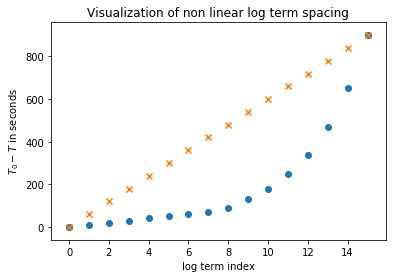

In [19]:
# For each log term, its time difference with the current time point
log_interval_all = [0,10,20,30, 
                    40,50,60,70,
                    90,130,180,250,
                    340,470,650,900]
lin_interval_all = np.arange(0,16)*60

plt.scatter(np.arange(16), log_interval_all, label ='Logarithmic Spacing', marker = 'o')
plt.scatter(np.arange(16), lin_interval_all, label = 'Linear Spacing', marker = 'x')

plt.xlabel('log term index')
plt.ylabel('$T_0-T$ in seconds')
plt.title('Visualization of non linear log term spacing')

plt.show()